# Setup

## Types

In [1]:
from enum import Enum
from typing import Protocol, List, Optional, Dict, Tuple, Any
from datetime import datetime
from dataclasses import dataclass

# Enums -----------------------------------------------------------

class AgentStatus(Enum):
    """Possible states of an agent."""
    IDLE = "IDLE"
    MOVING = "MOVING"
    WORKING = "WORKING"
    CHARGING = "CHARGING"
    ERROR = "ERROR"

class AgentType(Enum):
    """Types of agents in the warehouse."""
    PICKER = "PICKER"
    TRANSPORTER = "TRANSPORTER"

class NodeType(Enum):
    """Types of nodes in the warehouse."""
    ENTRY = "ENTRY"
    EXIT = "EXIT"
    NORMAL = "NORMAL"
    CENTER = "CENTER"

class TaskType(Enum):
    """Types of tasks in the warehouse."""
    PICK = "PICK"
    PLACE = "PLACE"
    MOVE = "MOVE"
    CHARGE = "CHARGE"

class TaskStatus(Enum):
    """Possible states of a task."""
    PENDING = "PENDING"
    IN_PROGRESS = "IN_PROGRESS"
    COMPLETED = "COMPLETED"
    FAILED = "FAILED"

# Interfaces -----------------------------------------------------------

class INode(Protocol):
    """Protocol defining the interface for a Node."""
    hash: str
    x: float
    y: float
    neighbours: Dict['INode', float]
    heuristic: float
    type: NodeType
    locked: bool
    is_goal: bool

class ITask(Protocol):
    """Protocol defining the interface for a Task."""
    hash_id: str
    initial_state: str
    goal_state: str
    job: TaskType
    priority: int

class IAgent(Protocol):
    """Interface for agent objects."""
    agent_id: int
    node: 'NodeType'
    weight: float
    status: AgentStatus
    goal_state: str
    mixer: Optional['IMixer']
    path: List['NodeType']
    battery: float
    agent_type: AgentType
    hash_id: str

class IMixer(Protocol):
    """Interface for mixer objects."""
    warehouse: 'IWarehouse'
    tasks: List['TaskType']
    priority_tasks: List['TaskType']
    agents: Dict[str, IAgent]
    logs: List[str]
    log_file: str

    def log_event(self, event_type: str, message: str, agent: Optional[IAgent] = None, task: Optional['Task'] = None) -> None:
        """Logs an event in the system."""
        pass

class IWarehouse(Protocol):
    """Interface for warehouse objects."""
    name: str
    location: str
    width: float
    length: float
    height: float
    racks: List['Rack']
    shelves: List['Shelf']
    items: Dict[str, 'ItemInformation']
    transactions: List['Transaction']

# Data Models -----------------------------------------------------------

@dataclass
class ItemInformation:
    """Data model for storing item information in the warehouse system."""
    item_id: str  # PK
    name: str
    category: str
    box_weight: float
    box_height: float
    box_price: float
    expiry: Optional[datetime]
    counter: int = 0

@dataclass
class ItemShelf:
    """Data model for mapping items to shelves in the warehouse."""
    item_id: str  # FK
    shelf_id: str  # FK
    order_in_shelf: int
    addition_date: datetime
    accessible_nodes: List[str]
    finale: bool = False

@dataclass
class Rack:
    """Data model for storage racks in the warehouse."""
    rack_id: str  # PK
    is_frozen: bool
    current_capacity: float
    start_coords: Tuple[float, float]  # [x,y]
    center_coords: Tuple[float, float]  # [x,y]
    end_coords: Tuple[float, float]    # [x,y]

@dataclass
class Shelf:
    """Data model for shelves within racks."""
    shelf_id: str  # PK
    rack_id: str   # FK -> Rack
    z_level: float
    current_weight: float
    is_locked: bool = False

@dataclass
class Transaction:
    """Data model for warehouse transactions."""
    transaction_id: str  # PK
    transaction_type: str
    item_id: str  # FK -> ItemInformation
    quantity: int
    date: datetime

@dataclass
class FactsTable:
    """Data model for warehouse configuration and constraints."""
    name: str
    location: str
    warehouse_width: float
    warehouse_length: float
    warehouse_height: float
    n_racks: int
    n_shelfs_per_rack: int
    shelfs_max_height: List[float]  # [z1,z2..]
    shelf_max_width: float
    item_length: float

    warehouse_height: float
    n_racks: int
    n_shelfs_per_rack: int
    shelfs_max_height: List[float]  # [z1,z2..]
    shelf_max_width: float
    item_length: float

## Task

In [2]:
from typing import Optional
import uuid

class Task(ITask):
    """Represents a task to be performed by an agent within the warehouse environment.
    
    Attributes:
        hash_id (str): Unique identifier for the task
        initial_state (str): Starting state/location of the task
        goal_state (str): Target state/location for the task
        job (TaskType): Type of job to be performed
        priority (int): Priority level of the task (0 = normal, 1 = high)
    """

    def __init__(self, goal_state: str, job: TaskType, priority: int = 0, initial_state: str = "", hash_id: Optional[str] = None):
        """Initializes a Task instance.

        Args:
            goal_state (str): Description or identifier of the target state/location for the task.
            job (TaskType): The type of job to be performed
            priority (int, optional): The priority level of the task (0 = normal, 1 = high)
            initial_state (str, optional): Description or identifier of the starting state/location
            hash_id (Optional[str], optional): A unique identifier (Primary Key) for the task

        Raises:
            ValueError: If goal_state or job is empty, or if priority is negative
        """
        if not goal_state:
            raise ValueError("Goal state cannot be empty")
        if not job:
            raise ValueError("Job type cannot be empty")
        if priority < 0:
            raise ValueError("Priority cannot be negative")

        self.hash_id: str = hash_id if hash_id is not None else str(uuid.uuid4())
        self.initial_state: str = initial_state
        self.goal_state: str = goal_state
        self.job: TaskType = job
        self.priority: int = priority

    def __str__(self) -> str:
        """Return a string representation of the task.
        
        Returns:
            str: A human-readable string representation of the task
        """
        return f"Task(Job='{self.job.name}', Goal='{self.goal_state}', Priority={self.priority}, ID='{self.hash_id}')"

    def __repr__(self) -> str:
        """Return a detailed string representation for debugging.
        
        Returns:
            str: A detailed string representation of the task
        """
        return (f"Task(hash_id='{self.hash_id}', initial_state='{self.initial_state}', "
                f"goal_state='{self.goal_state}', job='{self.job.name}', priority={self.priority})")

    def __eq__(self, other: object) -> bool:
        """Check if two tasks are equal based on their unique hash_id.
        
        Args:
            other (object): The object to compare with
            
        Returns:
            bool: True if the tasks are equal, False otherwise
        """
        if not isinstance(other, Task):
            return NotImplemented
        return self.hash_id == other.hash_id

    def __hash__(self) -> int:
        """Return a hash based on the task's unique hash_id.
        
        Returns:
            int: A hash value computed from the task's hash_id
        """
        return hash(self.hash_id)

## Nodes

In [3]:
from typing import Dict, Optional, List
from enum import Enum, auto
from dataclasses import dataclass, field

@dataclass
class Node:
    """Represents a node in the warehouse grid.
    
    Attributes:
        x (int): X coordinate
        y (int): Y coordinate
        node_type (NodeType): Type of the node
        name (str): Name of the node (e.g., "A1", "B2")
        neighbours (Dict[Node, float]): Dictionary of neighboring nodes and their distances
        locked_by (Optional[str]): ID of the agent that has locked this node
    """
    x: int
    y: int
    node_type: NodeType
    name: str
    neighbours: Dict['Node', float] = field(default_factory=dict)
    locked_by: Optional[str] = None
    locked: bool = False
    is_goal: bool = False

    def add_neighbor(self, node: 'Node', distance: float = 1.0) -> None:
        """Adds a neighboring node with the given distance."""
        self.neighbours[node] = distance
        node.neighbours[self] = distance

    def is_locked(self) -> bool:
        """Returns whether the node is currently locked by an agent."""
        return self.locked

    def lock(self, agent_id: str) -> bool:
        """Attempts to lock the node for an agent.
        
        Args:
            agent_id (str): ID of the agent attempting to lock the node
            
        Returns:
            bool: True if the node was successfully locked, False otherwise
        """
        if not self.is_locked():
            self.locked = True
            self.locked_by = agent_id
            return True
        return False

    def unlock(self, agent_id: str) -> bool:
        """Attempts to unlock the node for an agent.
        
        Args:
            agent_id (str): ID of the agent attempting to unlock the node
            
        Returns:
            bool: True if the node was successfully unlocked, False otherwise
        """
        if self.locked and self.locked_by == agent_id:
            self.locked = False
            self.locked_by = None
            return True
        return False

    def __hash__(self) -> int:
        """Returns a hash value for the node."""
        return hash((self.x, self.y))

    def __eq__(self, other: object) -> bool:
        """Checks if two nodes are equal."""
        if not isinstance(other, Node):
            return False
        return self.x == other.x and self.y == other.y

    def __str__(self) -> str:
        """Returns a string representation of the node."""
        return f"{self.name} ({self.x}, {self.y})"

    def get_locking_agent(self) -> Optional[str]:
        """Gets the agent that currently has the node locked.

        Returns:
            Optional[str]: The agent that locked the node, or None if the node is not locked
        """
        return self.locked_by

    def set_type(self, node_type: NodeType) -> None:
        """Sets the type of the node.

        Args:
            node_type (NodeType): The new type for the node
        """
        self.node_type = node_type

    def set_goal(self, is_goal: bool = True) -> None:
        """Sets whether this node is a goal node.

        Args:
            is_goal (bool, optional): Whether this is a goal node. Defaults to True.
        """
        self.is_goal = is_goal


## Warehouse 

In [4]:
from typing import Dict, Optional, List, TYPE_CHECKING
from math import sqrt
from dataclasses import dataclass, field
import uuid
import json
import os

if TYPE_CHECKING:
    from backend.core.agent import Agent

@dataclass
class Warehouse:
    """Represents the warehouse environment.
    
    Attributes:
        facts (FactsTable): Warehouse configuration and facts
        nodes (Dict[str, Node]): All nodes in the warehouse, keyed by node name
        racks (Dict[str, Rack]): All racks in the warehouse, keyed by rack ID
        shelves (Dict[str, Shelf]): All shelves in the warehouse, keyed by shelf ID
        agents (Dict[str, Agent]): All agents in the warehouse
        tasks (List[Task]): All tasks in the warehouse
        goal (Optional[Node]): Current goal node for pathfinding
    """
    facts: FactsTable
    nodes: Dict[str, Node] = field(default_factory=dict)
    racks: Dict[str, Rack] = field(default_factory=dict)
    shelves: Dict[str, Shelf] = field(default_factory=dict)
    agents: Dict[str, 'Agent'] = field(default_factory=dict)
    tasks: List[Task] = field(default_factory=list)
    goal: Optional[Node] = None
    
    @classmethod
    def create_default(cls) -> 'Warehouse':
        """Creates a default warehouse configuration for testing/example purposes."""
        # Create facts table
        facts = FactsTable(
            name="Example Warehouse",
            location="Test Location",
            warehouse_width=20.0,
            warehouse_length=30.0,
            warehouse_height=5.0,
            n_racks=4,
            n_shelfs_per_rack=3,
            shelfs_max_height=[1.0, 2.0, 3.0],
            shelf_max_width=2.0,
            item_length=0.5
        )
        
        # Create a 5x5 grid of nodes
        nodes: Dict[str, Node] = {}
        for i in range(5):
            for j in range(5):
                node_hash = f"node_{i}_{j}"
                nodes[node_hash] = Node(float(i), float(j), node_hash, {}, 0.0)
        
        # Connect nodes (up, down, left, right)
        for i in range(5):
            for j in range(5):
                current = nodes[f"node_{i}_{j}"]
                neighbors = {}
                
                # Check all adjacent positions
                for di, dj in [(0, 1), (0, -1), (1, 0), (-1, 0)]:
                    ni, nj = i + di, j + dj
                    if 0 <= ni < 5 and 0 <= nj < 5:
                        neighbor = nodes[f"node_{ni}_{nj}"]
                        neighbors[neighbor] = 1.0
                
                current.neighbours = neighbors
        
        # Create racks
        racks: Dict[str, Rack] = {}
        rack_positions = [(1, 1), (1, 3), (3, 1), (3, 3)]
        for i, (x, y) in enumerate(rack_positions):
            rack_id = f"rack_{i+1}"
            racks[rack_id] = Rack(
                rack_id=rack_id,
                is_frozen=False,
                current_capacity=0.0,
                start_coords=(float(x-0.5), float(y-0.5)),
                center_coords=(float(x), float(y)),
                end_coords=(float(x+0.5), float(y+0.5))
            )
            # Mark the node as a center
            nodes[f"node_{x}_{y}"].set_type(NodeType.CENTER)
        
        # Create shelves
        shelves: Dict[str, Shelf] = {}
        for rack_id, rack in racks.items():
            for level in range(3):
                shelf_id = f"{rack_id}_shelf_{level+1}"
                shelves[shelf_id] = Shelf(
                    shelf_id=shelf_id,
                    rack_id=rack_id,
                    z_level=float(level + 1),
                    current_weight=0.0,
                    is_locked=False
                )
        
        return cls(facts=facts, nodes=nodes, racks=racks, shelves=shelves)
    
    @classmethod
    def load_from_json(cls, json_path: str) -> 'Warehouse':
        """Loads warehouse configuration from a JSON file.
        
        Args:
            json_path (str): Path to the JSON configuration file
            
        Returns:
            Warehouse: A new Warehouse instance with the loaded configuration
            
        Raises:
            ValueError: If the JSON file is invalid or missing required fields
        """
        try:
            with open(json_path, 'r') as f:
                config = json.load(f)
                
            # Create default facts table
            facts = FactsTable(
                name="Warehouse",
                location="Default",
                warehouse_width=20.0,  # meters
                warehouse_length=30.0,  # meters
                warehouse_height=5.0,   # meters
                n_racks=5,             # number of racks
                n_shelfs_per_rack=3,   # shelves per rack
                shelfs_max_height=[1.0, 2.0, 3.0],  # height of each shelf level
                shelf_max_width=2.0,   # meters
                item_length=0.5        # meters
            )
                
            # Create warehouse instance with facts
            warehouse = cls(facts=facts)
            
            # Create nodes
            nodes = {}
            for node_name, node_data in config['nodes'].items():
                # Convert node type string to enum
                try:
                    node_type = NodeType[node_data['type']]
                except KeyError:
                    raise ValueError(f"Invalid node type: {node_data['type']}")
                    
                node = Node(
                    x=node_data['x'],
                    y=node_data['y'],
                    node_type=node_type,
                    name=node_name
                )
                nodes[node_name] = node
                
            # Create connections
            for node1_name, node2_name in config['connections']:
                node1 = nodes[node1_name]
                node2 = nodes[node2_name]
                node1.add_neighbor(node2)
                node2.add_neighbor(node1)
                
            warehouse.nodes = list(nodes.values())
            
            # Create racks and shelves
            for rack_id, rack_data in config['racks'].items():
                center_node = nodes[rack_data['center']]
                rack = Rack(
                    rack_id=rack_id,
                    is_frozen=False,
                    current_capacity=0.0,
                    start_coords=(center_node.x - 0.5, center_node.y - 0.5),
                    center_coords=(center_node.x, center_node.y),
                    end_coords=(center_node.x + 0.5, center_node.y + 0.5)
                )
                warehouse.racks.append(rack)
                
                # Create shelves for the rack
                for shelf_id in rack_data['shelves']:
                    shelf = Shelf(
                        shelf_id=shelf_id,
                        rack_id=rack.rack_id,
                        z_level=len(rack.shelves) + 1,
                        current_weight=0.0,
                        is_locked=False
                    )
                    warehouse.shelves.append(shelf)
                    
            return warehouse
            
        except Exception as e:
            raise ValueError(f"Failed to load warehouse from {json_path}: {str(e)}")
    
    def get_node(self, x: int, y: int) -> Optional[Node]:
        """Returns the node at the given coordinates."""
        for node in self.nodes.values():
            if node.x == x and node.y == y:
                return node
        return None

    def get_node_by_name(self, name: str) -> Optional[Node]:
        """Returns the node with the given name."""
        return self.nodes.get(name)

    def get_rack_at_node(self, node: Node) -> Optional[Rack]:
        """Returns the rack at the given node."""
        for rack in self.racks.values():
            if rack.center_node == node:
                return rack
        return None

    def get_shelves_for_rack(self, rack: Rack) -> List[Shelf]:
        """Returns all shelves in the given rack."""
        return list(rack.shelves.values())

    def get_distance(self, n1: Node, n2: Node) -> float:
        """Calculates Euclidean distance between two nodes.

        Args:
            n1 (Node): First node.
            n2 (Node): Second node.

        Returns:
            float: Euclidean distance between n1 and n2.
        """
        return sqrt((n1.x - n2.x) ** 2 + (n1.y - n2.y) ** 2)

    def get_actions(self, node: Node) -> Dict[str, float]:
        """Returns a dictionary of possible actions (neighboring nodes) from a given node.

        Args:
            node (Node): The node to get actions from.

        Returns:
            Dict[str, float]: Dictionary of neighboring nodes and their distances.
        """
        return {k: v for k, v in node.neighbours.items() if k != node.parent}

    def assign_heuristics(self):
        """Assigns heuristic values to nodes based on the goal location."""
        if not self.goal:
            return
        for node in self.nodes.values():
            node.set_heuristic(self.get_distance(node, self.goal))

    def add_task(self, task: Task):
        """Adds a task to the warehouse task list.

        Args:
            task (Task): The task to add.
        """
        self.tasks.append(task)

    def assign_task(self, agent: 'Agent'):
        """Assigns the highest priority task to an agent.

        Args:
            agent (Agent): The agent to assign the task to.
        """
        if self.tasks:
            # Sort tasks by priority (lower priority value means higher priority)
            self.tasks.sort(key=lambda x: x.priority)
            task = self.tasks.pop(0)  # Get the highest priority task
            agent.set_goal(task.goal_state)
            print(f"Assigned Task {task.job} to Agent {agent}.")
        else:
            print(f"No tasks available for Agent {agent}.")

    def calculate_heuristics(self, goal_node: Node, agent_type: AgentType) -> Dict[str, float]:
        """Calculates heuristic values for all nodes based on the goal and agent type."""
        heuristics = {}
        
        for node_name, node in self.nodes.items():
            # Base heuristic is Manhattan distance
            distance = abs(node.x - goal_node.x) + abs(node.y - goal_node.y)
            
            # Adjust heuristic based on agent type
            if agent_type == AgentType.PICKER:
                # Pickers prefer paths with fewer obstacles
                if node.type == NodeType.CENTER:
                    distance += 2  # Penalize rack centers
                elif node.type == NodeType.ENTRY or node.type == NodeType.EXIT:
                    distance -= 1  # Favor entry/exit points
            elif agent_type == AgentType.TRANSPORTER:
                # Transporters prefer straight paths
                if node.type == NodeType.CENTER:
                    distance += 3  # Strongly penalize rack centers
                elif node.type == NodeType.ENTRY or node.type == NodeType.EXIT:
                    distance -= 2  # Strongly favor entry/exit points
            
            heuristics[node_name] = distance
            
        return heuristics

    def __repr__(self):
        """String representation of the Warehouse map."""
        return f"Warehouse(Agents: {len(self.agents)}, Tasks: {len(self.tasks)})"


## Agents

In [5]:
from typing import List, Optional
from dataclasses import dataclass, field
import uuid

@dataclass
class Agent(IAgent):
    """Represents an agent in the warehouse system.
    
    Attributes:
        agent_id (int): Unique identifier for the agent
        node (Node): Current node where the agent is located
        weight (float): Weight of the agent (used for priority)
        status (AgentStatus): Current status of the agent
        goal_state (str): Target state/location for the agent
        mixer (Optional[IMixer]): Reference to the global mixer instance
        path (List[Node]): Current planned path
        battery (float): Current battery level (0-100)
        agent_type (AgentType): Type of agent
    """
    agent_id: int
    node: Node
    weight: float
    status: AgentStatus = AgentStatus.IDLE
    goal_state: str = ""
    mixer: Optional[IMixer] = None
    path: List[Node] = field(default_factory=list)
    battery: float = 100.0
    agent_type: AgentType = AgentType.PICKER
    hash_id: str = field(default_factory=lambda: str(uuid.uuid4()))

    def __post_init__(self):
        """Initializes an Agent with its node and registers with the mixer."""
        if not self.node:
            raise ValueError("Agent must be initialized with a valid node")
            
        # Add initial node to path
        self.path.append(self.node)
        if not self.node.lock(self):
            raise RuntimeError(f"Failed to lock initial node {self.node}")
            
        # Register with the global Mixer if available
        if self.mixer:
            self.mixer.log_event('agent_creation', f"Agent {self.agent_id} created at {self.node}", self)

    def move(self, new_node: Node) -> bool:
        """Moves the agent to a new node and logs the action."""
        if not new_node:
            if self.mixer:
                self.mixer.log_event('movement_failed', "Cannot move to None node", self)
            return False
            
        # Try to lock the new node
        if not new_node.lock(self):
            if self.mixer:
                self.mixer.log_event('movement_failed', f"Failed to move to {new_node} - node locked", self)
            return False
            
        # Unlock the current node
        self.node.unlock(self)
        
        # Update node and path
        self.node = new_node
        self.path.append(new_node)
        
        # Log the movement if mixer is available
        if self.mixer:
            self.mixer.log_event('movement', f"Moved to {new_node}", self)
        return True

    def backtrack(self, steps: int = 1) -> bool:
        """Moves the agent back along its path history.
        
        Args:
            steps (int): Number of steps to backtrack
            
        Returns:
            bool: True if backtrack was successful, False otherwise
        """
        if steps <= 0:
            if self.mixer:
                self.mixer.log_event('backtrack_failed', f"Invalid number of steps: {steps}", self)
            return False
            
        if len(self.path) <= steps:
            if self.mixer:
                self.mixer.log_event('backtrack_failed', f"Not enough path history to backtrack {steps} steps", self)
            return False
            
        # Get the target node to backtrack to
        target_node = self.path[-steps-1]
        
        # Try to lock the target node
        if not target_node.lock(self):
            if self.mixer:
                self.mixer.log_event('backtrack_failed', f"Failed to backtrack to {target_node} - node locked", self)
            return False
            
        # Unlock the current node
        self.node.unlock(self)
        
        # Update node and path history
        self.node = target_node
        self.path = self.path[:-steps]
        
        # Log the backtrack if mixer is available
        if self.mixer:
            self.mixer.log_event('backtrack', f"Backtracked {steps} steps to {target_node}", self)
        return True

    def set_goal(self, goal: str) -> None:
        """Sets a new goal state for the agent."""
        if not goal:
            raise ValueError("Goal cannot be empty")
            
        self.goal_state = goal
        if self.mixer:
            self.mixer.log_event('goal_change', f"Goal set to {goal}", self)

    def complete_task(self, task: Task) -> None:
        """Completes the given task and logs the completion.
        
        Args:
            task (Task): The task to complete
        """
        if not task:
            raise ValueError("Task cannot be None")
            
        if self.mixer:
            self.mixer.log_event('task_completion', f"Completed task: {task.job} to goal {task.goal_state}", self, task)

    def get_last_node(self) -> Optional[Node]:
        """Returns the last node in the path history.
        
        Returns:
            Optional[Node]: The last node in the path history, or None if history is empty
        """
        return self.path[-1] if self.path else None

    def clear_path_history(self) -> None:
        """Clears the path history, keeping only the current node."""
        if self.path:
            current_node = self.path[-1]
            self.path = [current_node]
            
    def update_battery(self, level: float) -> None:
        """Updates the agent's battery level.
        
        Args:
            level (float): New battery level (0-100)
            
        Raises:
            ValueError: If battery level is not between 0 and 100
        """
        if not 0 <= level <= 100:
            raise ValueError("Battery level must be between 0 and 100")
        self.battery = level
        
        if self.mixer and level < 20:
            self.mixer.log_event('battery_low', f"Battery low ({level}%)", self)

    def __str__(self) -> str:
        """Returns a string representation of the agent."""
        return f"Agent({self.agent_id}, {self.status.name}, {self.node})"

## Mixer

In [6]:
from typing import List, Dict, Optional, Any
from queue import Queue
import json
import os
from datetime import datetime
import uuid

class Mixer(IMixer):
    """Handles task assignment, prioritization, and monitoring for agents in the warehouse system.
    Also plays the role of Monitor.
    
    Attributes:
        warehouse (Dict[str, Any]): Reference to the warehouse configuration
        tasks (Queue): Regular tasks queue
        priority_tasks (Queue): High-priority tasks queue
        agents (List[Agent]): List of agents in the system
    """
    
    _instance = None
    LOG_BATCH_SIZE = 100  # Number of logs to accumulate before saving
    
    def __new__(cls, *args, **kwargs):
        if cls._instance is None:
            cls._instance = super(Mixer, cls).__new__(cls)
            cls._instance._initialized = False
        return cls._instance
    
    def __init__(self, warehouse: Any = None, agents: List[IAgent] = None):
        if self._initialized:
            return
            
        self.warehouse = warehouse  # FK
        self.tasks = Queue()  # Regular tasks queue
        self.priority_tasks = Queue()  # High-priority tasks queue
        self.agents = agents or []  # FK
        self.logs = []  # List to store all system logs
        self._log_file_path = os.path.join(os.path.dirname(__file__), '..', 'data', 'logs')
        self._ensure_log_directory()
        self._initialized = True

    def _ensure_log_directory(self) -> None:
        """Ensures the log directory exists."""
        os.makedirs(self._log_file_path, exist_ok=True)

    def _get_log_file_path(self) -> str:
        """Returns the path to the current log file."""
        timestamp = datetime.now().strftime("%Y%m%d")
        return os.path.join(self._log_file_path, f"warehouse_logs_{timestamp}.json")

    def _save_logs(self) -> None:
        """Saves the current logs to a file."""
        if not self.logs:
            return

        log_file = self._get_log_file_path()
        try:
            # Read existing logs if file exists
            existing_logs = []
            if os.path.exists(log_file):
                with open(log_file, 'r') as f:
                    existing_logs = json.load(f)

            # Append new logs
            existing_logs.extend(self.logs)
            
            # Save all logs
            with open(log_file, 'w') as f:
                json.dump(existing_logs, f, indent=2)
            
            # Clear the in-memory logs
            self.logs = []
            
        except Exception as e:
            print(f"Error saving logs: {e}")

    def log_event(self, event_type: str, message: str, agent: Optional[IAgent] = None, task: Optional[ITask] = None) -> None:
        """Logs an event in the system and saves logs if batch size is reached.
        
        Args:
            event_type (str): Type of event (e.g., 'movement', 'task', 'deadlock')
            message (str): Description of the event
            agent (Agent, optional): Agent involved in the event
            task (Task, optional): Task involved in the event
        """
        log_entry = {
            'id': str(uuid.uuid4()),
            'timestamp': datetime.now().isoformat(),
            'type': event_type,
            'message': message,
            'agent_id': agent.hash_id if agent else None,
            'task_id': task.hash_id if task else None
        }
        self.logs.append(log_entry)
        print(f"[{log_entry['timestamp']}] {event_type}: {message}")

        # Save logs if batch size is reached
        if len(self.logs) >= self.LOG_BATCH_SIZE:
            self._save_logs()

    def get_logs(self, event_type: Optional[str] = None, agent_id: Optional[str] = None, task_id: Optional[str] = None) -> List[Dict]:
        """Retrieves logs based on filters.
        
        Args:
            event_type (str, optional): Filter by event type
            agent_id (str, optional): Filter by agent ID
            task_id (str, optional): Filter by task ID
            
        Returns:
            List[dict]: Filtered log entries
        """
        filtered_logs = self.logs
        if event_type:
            filtered_logs = [log for log in filtered_logs if log['type'] == event_type]
        if agent_id:
            filtered_logs = [log for log in filtered_logs if log['agent_id'] == agent_id]
        if task_id:
            filtered_logs = [log for log in filtered_logs if log['task_id'] == task_id]
        return filtered_logs

    def _load_deadlock_table(self) -> dict:
        """Loads the deadlock table from the JSON file."""
        try:
            file_path = os.path.join(os.path.dirname(__file__), '..', 'data', 'deadlock_table.json')
            with open(file_path, 'r') as f:
                return json.load(f)
        except FileNotFoundError:
            print("Warning: deadlock_table.json not found. Using default deadlock handling.")
            return {
                "deadlock_scenarios": {
                    "agent_blocked": {
                        "action": "move_agent_back",
                        "parameters": {"steps": 1}
                    }
                },
                "default_resolution": {
                    "action": "move_agent_back",
                    "parameters": {"steps": 1}
                }
            }

    def _enqueue(self, agent: Agent, task: Task):
        """Helper method to enqueue tasks based on priority."""
        queue = self.priority_tasks if task.priority == 1 else self.tasks
        queue.put({
            'agent': agent,
            'goal': task.goal_state,
            'job': task.job
        })

    def order(self, agent: Agent, task: Task):
        """Orders a task for an agent by enqueuing it into the appropriate queue."""
        self._enqueue(agent, task)

    def assign_task(self, agent: IAgent) -> None:
        """Assigns tasks from the priority queue first, then from the regular queue."""
        task_assigned = False

        if not self.priority_tasks.empty():
            task = self.priority_tasks.get()
            agent.set_goal(task['goal'])
            task_assigned = True
            print(f"Assigned high-priority Task {task['job']} to Agent {agent}.")
        
        if not task_assigned and not self.tasks.empty():
            task = self.tasks.get()
            agent.set_goal(task['goal'])
            print(f"Assigned Task {task['job']} to Agent {agent}.")

    def detect_and_resolve_deadlock(self):
        """Detects deadlock and resolves it using the deadlock table."""
        blocked_agents = [agent for agent in self.agents if agent.state == "blocked"]

        if len(blocked_agents) > 0:
            # Identify deadlock scenario based on blocked agents
            deadlock_type = self.identify_deadlock_type(blocked_agents)
            scenario = self.deadlock_table["deadlock_scenarios"].get(deadlock_type)
            
            if scenario:
                print(f"Deadlock detected: {scenario['description']}")
                print(f"Resolution: {scenario['resolution']}")
                self.resolve_deadlock(deadlock_type, blocked_agents, scenario)
            else:
                # Use default resolution if scenario not found
                default = self.deadlock_table["default_resolution"]
                print(f"Deadlock detected. Using default resolution: {default['action']}")
                self.resolve_deadlock(deadlock_type, blocked_agents, default)

    def identify_deadlock_type(self, blocked_agents: List[Agent]) -> str:
        """Identifies the type of deadlock based on the blocked agents' situation."""
        if len(blocked_agents) == 1:
            return "agent_blocked"
        elif len(blocked_agents) > 1:
            return "agents_blocked"
        else:
            return "path_blocked"

    def resolve_deadlock(self, deadlock_type: str, blocked_agents: List[Agent], scenario: dict):
        """Resolves the deadlock based on the deadlock type and blocked agents."""
        action = scenario["action"]
        params = scenario.get("parameters", {})

        if action == "move_agent_back":
            self.move_agent_back(blocked_agents, params)
        elif action == "switch_agent_positions":
            self.switch_agent_positions(blocked_agents, params)
        elif action == "recalculate_path":
            self.recalculate_path(blocked_agents, params)
        elif action == "break_circular_wait":
            self.break_circular_wait(blocked_agents, params)
        elif action == "release_resources":
            self.release_resources(blocked_agents, params)

    def move_agent_back(self, agents: List[Agent], params: dict):
        """Moves a blocked agent back along its path history."""
        agent = agents[0]
        steps = params.get("steps", 1)
        
        # Try to backtrack the specified number of steps
        success = agent.backtrack(steps)
        if not success:
            print(f"Warning: Could not backtrack {steps} steps for {agent}. Not enough path history.")
            # If we can't backtrack, try to move back one step at a time
            for _ in range(steps):
                if not agent.backtrack(1):
                    break

    def switch_agent_positions(self, agents: List[Agent], params: dict):
        """Switches positions between two blocked agents."""
        max_agents = params.get("max_agents", 2)
        if len(agents) > max_agents:
            agents = agents[:max_agents]
            
        agent1, agent2 = agents
        # Store current positions
        pos1 = agent1.node
        pos2 = agent2.node
        
        # Move agents to each other's positions
        agent1.move(pos2)
        agent2.move(pos1)
        
        print(f"Switched positions between {agent1} and {agent2}.")

    def recalculate_path(self, agents: List[Agent], params: dict):
        """Recalculates the path for blocked agents."""
        algorithm = params.get("algorithm", "A*")
        max_attempts = params.get("max_attempts", 3)
        print(f"Recalculating path for {agents} using {algorithm} (max attempts: {max_attempts})")

    def break_circular_wait(self, agents: List[Agent], params: dict):
        """Breaks circular wait by moving the lowest weight agent back."""
        priority = params.get("priority", "lowest_weight")
        if priority == "lowest_weight":
            agent = min(agents, key=lambda a: a.weight)
            self.move_agent_back([agent], {"steps": 1})
            print(f"Broke circular wait by moving lowest weight agent: {agent}")

    def release_resources(self, agents: List[Agent], params: dict):
        """Releases and reacquires resources for deadlocked agents."""
        timeout = params.get("timeout", 5)
        retry_interval = params.get("retry_interval", 1)
        print(f"Releasing resources for {agents} (timeout: {timeout}s, retry interval: {retry_interval}s)")


# --------------------------------------------------------------------------------------------

# Item Insertion

## Simmulated Annealing

Starting optimization...
Iter 0: Cost=78387.49777777774, Perfect=15, Util=52.2%
Iter 100: Cost=58438.70777777775, Perfect=13, Util=52.2%
Iter 200: Cost=52872.17777777775, Perfect=13, Util=52.2%
Iter 300: Cost=49744.13777777779, Perfect=11, Util=52.2%
Iter 400: Cost=49833.35777777779, Perfect=10, Util=52.2%
Iter 500: Cost=41831.597777777795, Perfect=8, Util=52.2%
Iter 600: Cost=39111.777777777796, Perfect=8, Util=52.2%
Iter 700: Cost=34551.72777777781, Perfect=8, Util=52.2%
Iter 800: Cost=33762.727777777814, Perfect=11, Util=52.2%
Iter 900: Cost=33287.62777777781, Perfect=12, Util=52.2%
Iter 1000: Cost=31317.927777777797, Perfect=12, Util=52.2%
Iter 1100: Cost=30752.497777777797, Perfect=15, Util=52.2%
Iter 1200: Cost=30565.117777777796, Perfect=15, Util=52.2%
Iter 1300: Cost=29715.6877777778, Perfect=15, Util=52.2%
Iter 1400: Cost=29352.587777777793, Perfect=15, Util=52.2%
Iter 1500: Cost=29019.49777777779, Perfect=17, Util=52.2%
Iter 1600: Cost=28982.19777777779, Perfect=16, Util=52.2

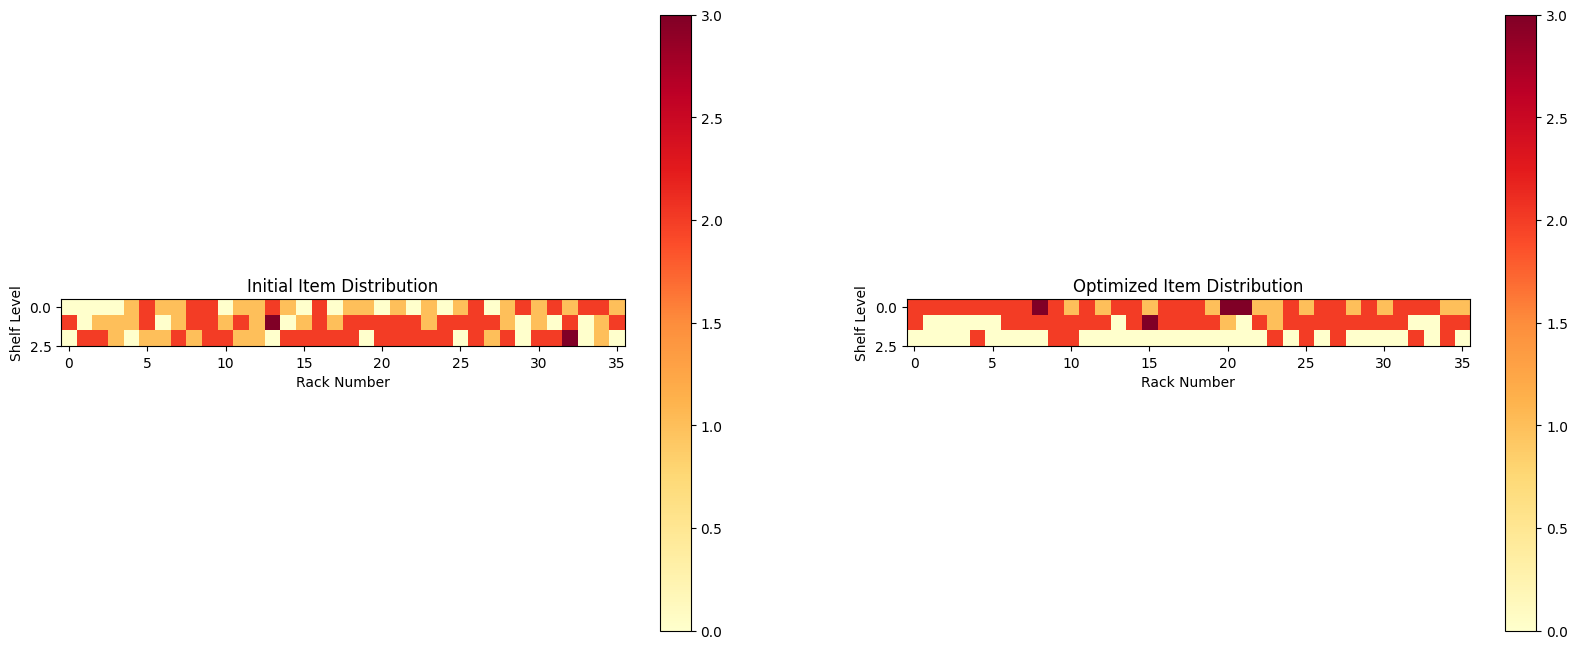

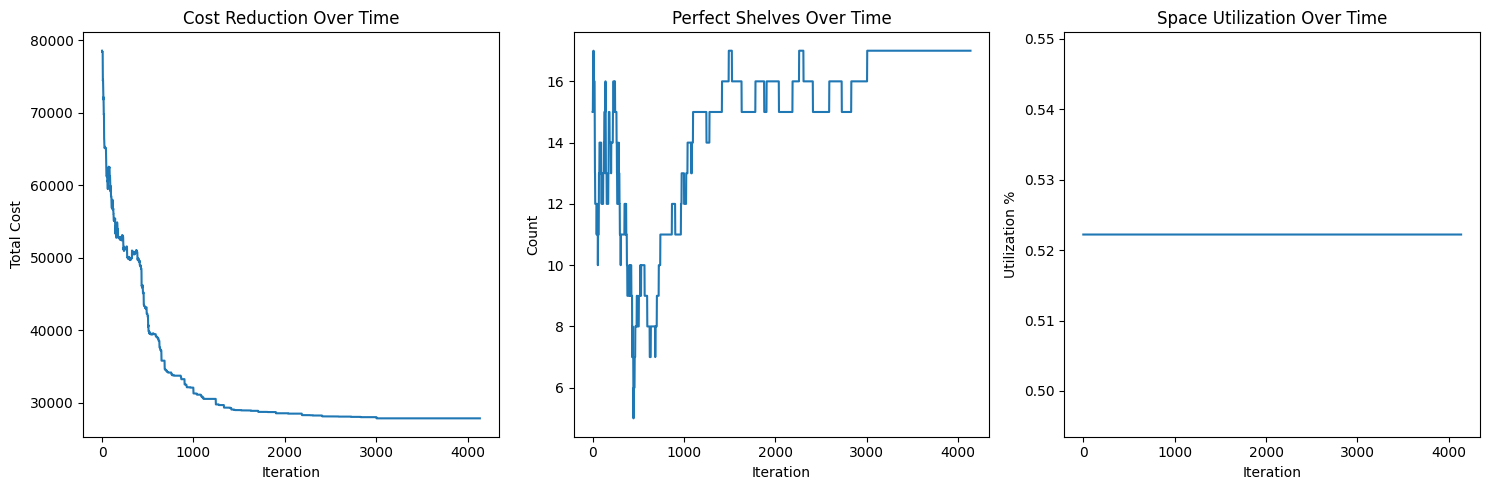

In [7]:
import random
import math
import csv
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

class Candidate:
    """Represents a candidate solution with its state, cost, and efficiency metrics"""
    def __init__(self, state, value, efficiency):
        self.state = state
        self.value = value
        self.efficiency = efficiency

class Problem:
    """Defines the warehouse optimization problem with all constraints"""
    def __init__(self, filename):
        self.filename = filename
        self.items = []
        self.box_sizes = {
            'L': {'width': 180, 'bins': 3},
            'M': {'width': 120, 'bins': 2},
            'S': {'width': 60, 'bins': 1}
        }
        self.load_items()
        
        # Warehouse configuration
        self.num_racks = 36
        self.freezer_racks = {1, 2, 3, 4, 5, 6}
        self.normal_racks = set(range(7, 37))
        self.shelf_levels = 3
        self.bins_per_shelf = 5
        self.bin_size = 60
        self.shelf_length = self.bins_per_shelf * self.bin_size
        
        self.weight_limits = {1: 400, 2: 250, 3: 150}
        self.category_conflicts = {
            'food': ['chemicals'],
            'beverages': ['chemicals'],
            'chemicals': ['food', 'beverages'],
            'frozen': [],
            'household goods': []
        }

    def load_items(self):
        with open(self.filename, mode='r') as file:
            reader = csv.DictReader(file)
            for row in reader:
                size = row['item_size'][0].upper()
                if size not in self.box_sizes:
                    raise ValueError(f"Invalid item size '{row['item_size']}'")
                
                self.items.append({
                    'id': int(row['item_id']),
                    'name': row['item_name'],
                    'size': size,
                    'category': row['category'].lower(),
                    'weight': float(row['weight']),
                    'frequency': float(row['frequency']),
                    'is_frozen': row['category'].lower() == 'frozen'
                })

    def get_bin_requirements(self, size):
        """
        Get bin requirements for an item size
        
        Args:
            size: Item size ('L', 'M', or 'S')
            
        Returns:
            tuple: (bins_needed, possible_starting_positions)
        """
        bins = self.box_sizes[size]['bins']
        possible_starts = list(range(1, self.bins_per_shelf - bins + 2))
        return bins, possible_starts

    def generate_initial_state(self):
        """Generate initial random state respecting all constraints"""
        state = {}
        shelf_usage = defaultdict(set)  # {(rack, shelf): set of occupied bins}
        
        for item in self.items:
            placed = False
            attempts = 0
            bins_needed, possible_starts = self.get_bin_requirements(item['size'])
            
            while not placed and attempts < 100:
                # Choose appropriate racks
                valid_racks = self.freezer_racks if item['is_frozen'] else self.normal_racks
                rack = random.choice(list(valid_racks))
                shelf = random.randint(1, self.shelf_levels)
                
                # Find available consecutive bins
                available_starts = [
                    s for s in possible_starts
                    if all(b not in shelf_usage[(rack, shelf)] 
                      for b in range(s, s + bins_needed))
                ]
                
                if available_starts:
                    start = random.choice(available_starts)
                    positions = list(range(start, start + bins_needed))
                    
                    # Place the item
                    state[item['id']] = (rack, shelf, positions)
                    for pos in positions:
                        shelf_usage[(rack, shelf)].add(pos)
                    placed = True
                else:
                    attempts += 1
            
            if not placed:
                # Fallback placement (may violate constraints)
                valid_racks = self.freezer_racks if item['is_frozen'] else self.normal_racks
                rack = random.choice(list(valid_racks))
                shelf = random.randint(1, self.shelf_levels)
                start = random.randint(1, self.bins_per_shelf - bins_needed + 1)
                positions = list(range(start, start + bins_needed))
                state[item['id']] = (rack, shelf, positions)
        
        return state

    def calculate_efficiency(self, state):
        """
        Calculate shelf efficiency metrics
        
        Args:
            state: Current solution state
            
        Returns:
            tuple: (perfect_shelves, good_shelves, poor_shelves, utilization)
        """
        shelf_stats = defaultdict(lambda: {'used_bins': set(), 'weight': 0, 'categories': set()})
        
        # Track shelf usage
        for item_id, (rack, shelf, positions) in state.items():
            item = next(i for i in self.items if i['id'] == item_id)
            shelf_stats[(rack, shelf)]['used_bins'].update(positions)
            shelf_stats[(rack, shelf)]['weight'] += item['weight']
            shelf_stats[(rack, shelf)]['categories'].add(item['category'])
        
        perfect = good = poor = 0
        total_used = 0
        
        # Classify each shelf
        for (rack, shelf), stats in shelf_stats.items():
            used_width = len(stats['used_bins']) * self.bin_size
            remaining = self.shelf_length - used_width
            
            if remaining == 0:
                perfect += 1
            elif remaining <= self.bin_size:  # Can fit at least one S
                good += 1
            elif remaining >= (self.shelf_length / 2):  # More than half empty
                poor += 1
            
            total_used += used_width
        
        # Calculate overall utilization
        total_space = self.num_racks * self.shelf_levels * self.shelf_length
        utilization = total_used / total_space
        
        return (perfect, good, poor, utilization)

    def evaluate(self, state):
        """
        Evaluate the cost of a solution state
        
        Args:
            state: Solution state to evaluate
            
        Returns:
            tuple: (total_cost, efficiency_metrics)
        """
        cost = 0
        shelf_stats = defaultdict(lambda: {'used_bins': set(), 'weight': 0, 'categories': set(), 'items': []})
        
        # Check hard constraints
        for item_id, (rack, shelf, positions) in state.items():
            item = next(i for i in self.items if i['id'] == item_id)
            shelf_key = (rack, shelf)
            stats = shelf_stats[shelf_key]
            
            # Track shelf usage
            stats['used_bins'].update(positions)
            stats['weight'] += item['weight']
            stats['categories'].add(item['category'])
            stats['items'].append(item)
            
            # Frozen items must be in freezer racks
            if item['is_frozen'] and rack not in self.freezer_racks:
                cost += 10000
                
            # Check weight limits
            if stats['weight'] > self.weight_limits[shelf]:
                cost += 1000
                
            # Check category conflicts
            for other in stats['items']:
                if other['category'] in self.category_conflicts[item['category']]:
                    cost += 1000
        
        # Calculate soft costs
        for item_id, (rack, shelf, positions) in state.items():
            item = next(i for i in self.items if i['id'] == item_id)
            cost += item['frequency'] * shelf  # Accessibility cost
            cost += item['weight'] * shelf     # Weight distribution cost
        
        # Add efficiency metrics
        perfect, good, poor, utilization = self.calculate_efficiency(state)
        cost -= perfect * 50  # Reward perfect shelves
        cost += poor * 100    # Penalize poor shelves
        if utilization < 0.85:
            cost += 1000 * (0.85 - utilization)  # Utilization penalty
            
        return cost, (perfect, good, poor, utilization)

    def generate_neighbor(self, current_state):
        """Generate a valid neighboring state by moving one item"""
        new_state = current_state.copy()
        item_id = random.choice(list(new_state.keys()))
        item = next(i for i in self.items if i['id'] == item_id)
        
        # Try up to 20 random moves
        for _ in range(20):
            # Choose appropriate racks
            valid_racks = self.freezer_racks if item['is_frozen'] else self.normal_racks
            rack = random.choice(list(valid_racks))
            shelf = random.randint(1, self.shelf_levels)
            
            bins_needed, possible_starts = self.get_bin_requirements(item['size'])
            
            # Get current shelf usage
            used_bins = set()
            for other_id, (r, s, positions) in new_state.items():
                if r == rack and s == shelf:
                    used_bins.update(positions)
            
            # Find available consecutive bins
            available_starts = [
                s for s in possible_starts
                if all(b not in used_bins for b in range(s, s + bins_needed))
            ]
            
            if available_starts:
                start = random.choice(available_starts)
                positions = list(range(start, start + bins_needed))
                new_state[item_id] = (rack, shelf, positions)
                return new_state
        
        return current_state  # Return original if no valid move found


def simulated_annealing(problem, initial_temp, cooling_rate, iterations):
    """
    Perform simulated annealing optimization
    
    Args:
        problem: Problem instance
        initial_temp: Starting temperature
        cooling_rate: Temperature reduction factor
        iterations: Maximum iterations
        
    Returns:
        tuple: (best_state, best_cost, best_eff, cost_history, perfect_history, util_history, movement_log)
    """
    current_state = problem.generate_initial_state()
    current_cost, current_eff = problem.evaluate(current_state)
    best_state = current_state.copy()
    best_cost = current_cost
    best_eff = current_eff
    
    # Progress tracking
    cost_history = [current_cost]
    perfect_history = [current_eff[0]]
    util_history = [current_eff[3]]
    movement_log = []
    
    for i in range(iterations):
        temp = initial_temp * (cooling_rate ** i)
        if temp < 1e-6:
            break
            
        neighbor = problem.generate_neighbor(current_state)
        neighbor_cost, neighbor_eff = problem.evaluate(neighbor)
        
        # Acceptance probability
        if neighbor_cost < current_cost or random.random() < math.exp((current_cost - neighbor_cost)/temp):
            # Log changes
            changed_items = [
                item_id for item_id in current_state
                if current_state[item_id] != neighbor.get(item_id, None)
            ]
            
            for item_id in changed_items:
                item = next(i for i in problem.items if i['id'] == item_id)
                old_pos = current_state[item_id]
                new_pos = neighbor[item_id]
                reason = determine_move_reason(problem, item, old_pos, new_pos, neighbor_cost - current_cost)
                movement_log.append(create_movement_record(item, old_pos, new_pos, reason, neighbor_cost - current_cost, i))
            
            current_state = neighbor
            current_cost = neighbor_cost
            current_eff = neighbor_eff
            
            if neighbor_cost < best_cost:
                best_state = neighbor
                best_cost = neighbor_cost
                best_eff = neighbor_eff
        
        # Record progress
        cost_history.append(current_cost)
        perfect_history.append(current_eff[0])
        util_history.append(current_eff[3])
        
        if i % 100 == 0:
            print(f"Iter {i}: Cost={current_cost}, Perfect={current_eff[0]}, Util={current_eff[3]:.1%}")
    
    # Add initial to final movement records
    initial_state = problem.generate_initial_state()
    for item in problem.items:
        item_id = item['id']
        initial_pos = initial_state[item_id]
        final_pos = best_state.get(item_id, None)
        
        if final_pos and initial_pos != final_pos:
            reason = "Initial optimization"
            cost_impact = best_cost - cost_history[0]
            movement_log.append(create_movement_record(item, initial_pos, final_pos, reason, cost_impact, "Initial"))
    
    return best_state, best_cost, best_eff, cost_history, perfect_history, util_history, movement_log


def create_movement_record(item, old_pos, new_pos, reason, cost_impact, iteration):
    """
    Create a standardized movement record dictionary
    
    Args:
        item: Item being moved
        old_pos: Original position (rack, shelf, positions)
        new_pos: New position (rack, shelf, positions)
        reason: Reason for move
        cost_impact: Cost change from this move
        iteration: Iteration number
        
    Returns:
        dict: Movement record
    """
    return {
        'item_id': item['id'],
        'item_name': item['name'],
        'category': item['category'],
        'size': item['size'],
        'old_rack': old_pos[0],
        'old_shelf': old_pos[1],
        'old_positions': format_positions(old_pos[2]),
        'new_rack': new_pos[0],
        'new_shelf': new_pos[1],
        'new_positions': format_positions(new_pos[2]),
        'reason': reason,
        'cost_impact': cost_impact,
        'iteration': iteration
    }


def format_positions(positions):
    """
    Format position list as human-readable string
    
    Args:
        positions: List of bin positions
        
    Returns:
        str: Formatted position string (e.g., "2-4" for [2,3,4])
    """
    if len(positions) == 1:
        return str(positions[0])
    return f"{positions[0]}-{positions[-1]}"


def determine_move_reason(problem, item, old_pos, new_pos, cost_change):
    """
    Determine the reason for an item movement
    
    Args:
        problem: Problem instance
        item: Item being moved
        old_pos: Original position
        new_pos: New position
        cost_change: Cost impact of move
        
    Returns:
        str: Reason description
    """
    # Frozen items
    if item['is_frozen'] and new_pos[0] in problem.freezer_racks and old_pos[0] not in problem.freezer_racks:
        return "Moved to freezer rack"
    
    # Category conflicts
    # ... [category conflict checking logic] ...
    
    # Weight distribution
    if new_pos[1] < old_pos[1]:  # Moved to lower shelf
        return "Better weight distribution"
    
    # Space utilization
    old_gaps = calculate_gaps(old_pos[2], problem.bins_per_shelf)
    new_gaps = calculate_gaps(new_pos[2], problem.bins_per_shelf)
    if min(new_gaps) > min(old_gaps):
        return "Improved space utilization"
    
    return "General optimization" if cost_change < 0 else "Exploratory move"


def calculate_gaps(positions, total_bins):
    """
    Calculate gaps between occupied bins
    
    Args:
        positions: List of occupied bin positions
        total_bins: Total bins per shelf
        
    Returns:
        list: Sizes of gaps between occupied bins
    """
    occupied = set(positions)
    gaps = []
    current_gap = 0
    
    for bin in range(1, total_bins + 1):
        if bin in occupied:
            if current_gap > 0:
                gaps.append(current_gap)
            current_gap = 0
        else:
            current_gap += 1
    
    if current_gap > 0:
        gaps.append(current_gap)
    
    return gaps if gaps else [0]



def generate_movement_report(initial_state, best_state, problem, filename='item_movements.csv'):
    """Generate CSV with exact format requested"""
    with open(filename, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow([
            'item_id', 'name', 'category', 'size',
            'initial_position', 'new_position'
        ])
        
        for item in problem.items:
            item_id = item['id']
            old_pos = initial_state.get(item_id, (None, None, []))
            new_pos = best_state.get(item_id, (None, None, []))
            
            if old_pos[0] and new_pos[0]:  # Only include properly placed items
                writer.writerow([
                    item_id,
                    item['name'],
                    item['category'],
                    item['size'],
                    f"({old_pos[0]},{old_pos[1]},{format_positions(old_pos[2])})",
                    f"({new_pos[0]},{new_pos[1]},{format_positions(new_pos[2])})"
                ])

def generate_heatmaps(initial_state, best_state, problem):
    """Generate before/after heatmaps"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Prepare data
    def prepare_heatmap_data(state):
        heatmap = np.zeros((problem.shelf_levels, problem.num_racks))
        for (rack, shelf, _) in state.values():
            heatmap[shelf-1][rack-1] += 1
        return heatmap
    
    # Initial state heatmap
    im1 = ax1.imshow(prepare_heatmap_data(initial_state), cmap='YlOrRd')
    ax1.set_title('Initial Item Distribution')
    ax1.set_xlabel('Rack Number')
    ax1.set_ylabel('Shelf Level')
    fig.colorbar(im1, ax=ax1)
    
    # Optimized state heatmap
    im2 = ax2.imshow(prepare_heatmap_data(best_state), cmap='YlOrRd')
    ax2.set_title('Optimized Item Distribution')
    ax2.set_xlabel('Rack Number')
    ax2.set_ylabel('Shelf Level')
    fig.colorbar(im2, ax=ax2)
    
    plt.savefig('placement_heatmaps.png')

def format_positioSns(positions):
    """Improved bin formatting"""
    if not positions:
        return ""
    if len(positions) == 1:
        return str(positions[0])
    return f"{positions[0]}-{positions[-1]}"
def generate_visualization(cost_history, perfect_history, util_history):
    """
    Generate optimization progress plots
    
    Args:
        cost_history: List of cost values over iterations
        perfect_history: List of perfect shelf counts
        util_history: List of utilization percentages
    """
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(cost_history)
    plt.title('Cost Reduction Over Time')
    plt.xlabel('Iteration')
    plt.ylabel('Total Cost')
    
    plt.subplot(1, 3, 2)
    plt.plot(perfect_history)
    plt.title('Perfect Shelves Over Time')
    plt.xlabel('Iteration')
    plt.ylabel('Count')
    
    plt.subplot(1, 3, 3)
    plt.plot(util_history)
    plt.title('Space Utilization Over Time')
    plt.xlabel('Iteration')
    plt.ylabel('Utilization %')
    
    plt.tight_layout()
    plt.savefig('optimization_progress.png')


def generate_text_report(problem, best_state, best_cost, best_eff):
    """
    Generate detailed text report of final solution
    
    Args:
        problem: Problem instance
        best_state: Optimal solution state
        best_cost: Solution cost
        best_eff: Efficiency metrics
    """
    shelf_details = defaultdict(list)
    for item_id, (rack, shelf, positions) in best_state.items():
        item = next(i for i in problem.items if i['id'] == item_id)
        shelf_details[(rack, shelf)].append((item, positions))
    
    report = [
        "="*80,
        "WAREHOUSE OPTIMIZATION REPORT",
        "="*80,
        f"\nFinal Statistics:",
        f"- Total Cost: {best_cost}",
        f"- Perfect Shelves: {best_eff[0]} (fully packed)",
        f"- Good Shelves: {best_eff[1]} (<60cm unused)",
        f"- Poor Shelves: {best_eff[2]} (>150cm unused)",
        f"- Space Utilization: {best_eff[3]:.1%}",
        "\n" + "="*80,
        "SHELF DETAILS (POORLY UTILIZED SHELVES):",
        "="*80
    ]
    
    # Show worst shelves
    poor_shelves = sorted(
        [(k, v) for k, v in shelf_details.items()],
        key=lambda x: problem.shelf_length - sum(problem.box_sizes[i['size']]['width'] for i, _ in x[1]),
        reverse=True
    )[:10]  # Top 10 worst
    
    for (rack, shelf), items in poor_shelves:
        used = sum(problem.box_sizes[i['size']]['width'] for i, _ in items)
        report.append(
            f"\nRack {rack} Shelf {shelf} (Used: {used}cm/{problem.shelf_length}cm):"
        )
        for item, positions in items:
            report.append(
                f"  - ID {item['id']}: {item['name']} ({item['size']}, "
                f"{item['weight']}kg, {item['category']}) "
                f"in positions {format_positions(positions)}"
            )
    
    with open('optimization_report.txt', 'w') as f:
        f.write("\n".join(report))



if __name__ == "__main__":
    try:
        # Initialize problem
        problem = Problem('items.csv')
        
        # Get initial state before optimization
        initial_state = problem.generate_initial_state()
        
        # Run optimization
        print("Starting optimization...")
        results = simulated_annealing(
            problem,
            initial_temp=1000,
            cooling_rate=0.995,
            iterations=5000
        )
        best_state, best_cost, best_eff, *_ = results
        
        # Generate outputs
        generate_movement_report(initial_state, best_state, problem)
        generate_heatmaps(initial_state, best_state, problem)
        generate_visualization(*results[3:6])  # Existing progress plots
        generate_text_report(problem, best_state, best_cost, best_eff)
        
        print("\nOptimization complete!")
        print(f"- Final cost: {best_cost}")
        print(f"- Space utilization: {best_eff[3]:.1%}")
        print("- CSV output: item_movements.csv")
        print("- Heatmaps: pbackend/functions/items.csvlacement_heatmaps.png")
        print("- Progress plots: optimization_progress.png")
        print("- Report: optimization_report.txt")
    
    except Exception as e:
        print(f"Error occurred: {str(e)}")

## Steepest Ascent 

--- Generating Dummy Data ---
Generated dummy_items.csv with 50 items (incl. counters).
Generated dummy_rack_layout.csv with initial layout.
------------------------------
Loaded facts: Entrances, 12 racks, weight/height limits.
Loaded 50 items from dummy_items.csv.
Populated layout from dummy_rack_layout.csv with 17 items.

--- Initial Warehouse State ---


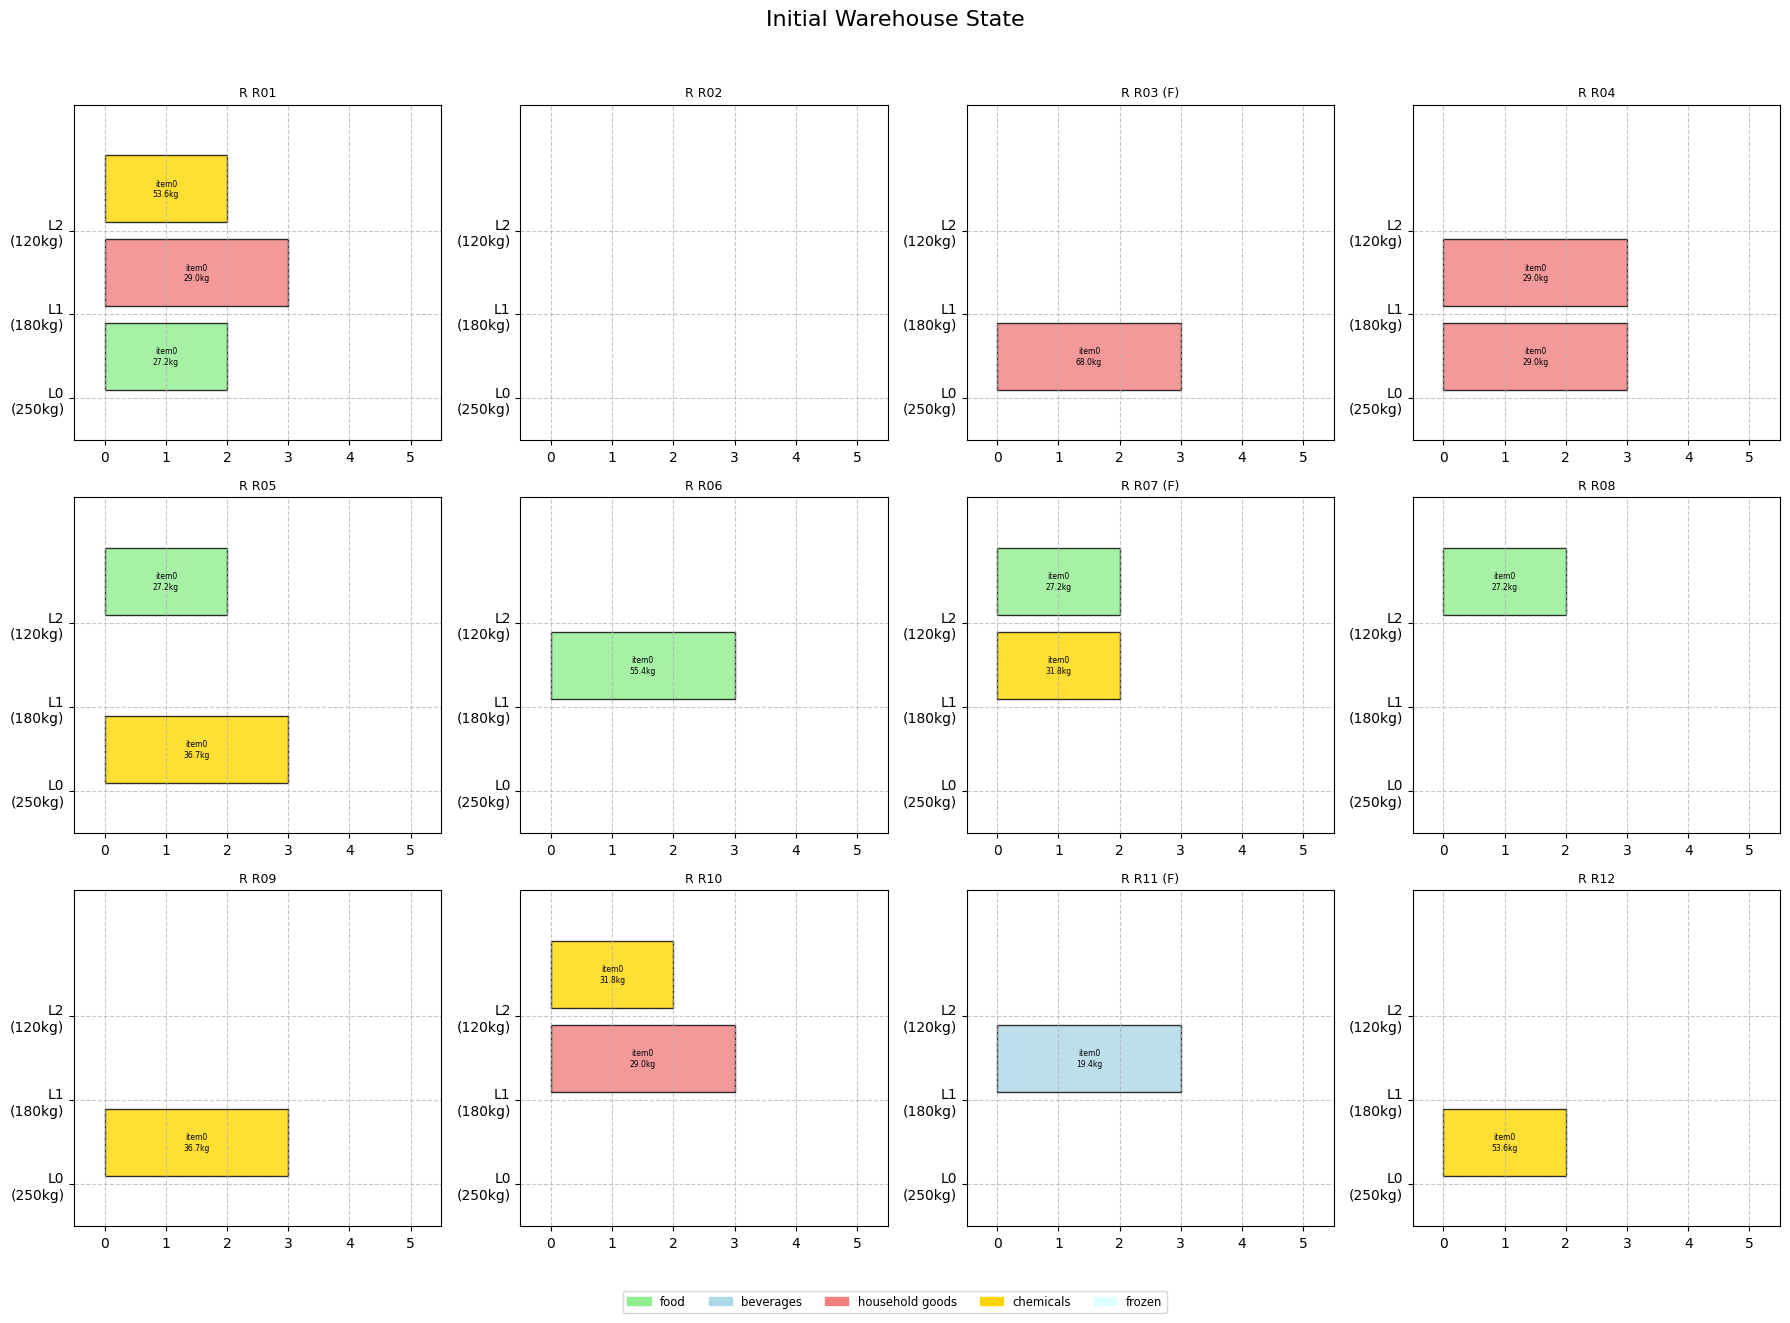



=============== ATTEMPTING INSERTION 1/10 FOR ITEM: item046 ===============

--- Evaluating Placements for: Item(item046,'Value Household goods Box',W:49.0,S:3,Fq:8.00) ---
------------------------------------------------------------------------------------------
Location     |   Score | Reason/Breakdown                                            
------------------------------------------------------------------------------------------
R01-L0       |    7.50 | Compatibility:0.40; Weight:1.50; Space:0.80; Distance:4.80
R01-L1       |    -inf | Slot:FAIL
R01-L2       |    4.80 | Compatibility:0.20; Weight:-1.00; Space:0.80; Distance:4.80
R02-L0       |    7.50 | Compatibility:1.00; Weight:1.50; Distance:5.00
R02-L1       |    6.50 | Compatibility:1.00; Weight:0.50; Distance:5.00
R02-L2       |    5.00 | Compatibility:1.00; Weight:-1.00; Distance:5.00
R03-L0       |    -inf | Slot:FAIL
R03-L1       |   -3.50 | Frozen:-10.00; Compatibility:1.00; Weight:0.50; Distance:5.00
R03-L2       |

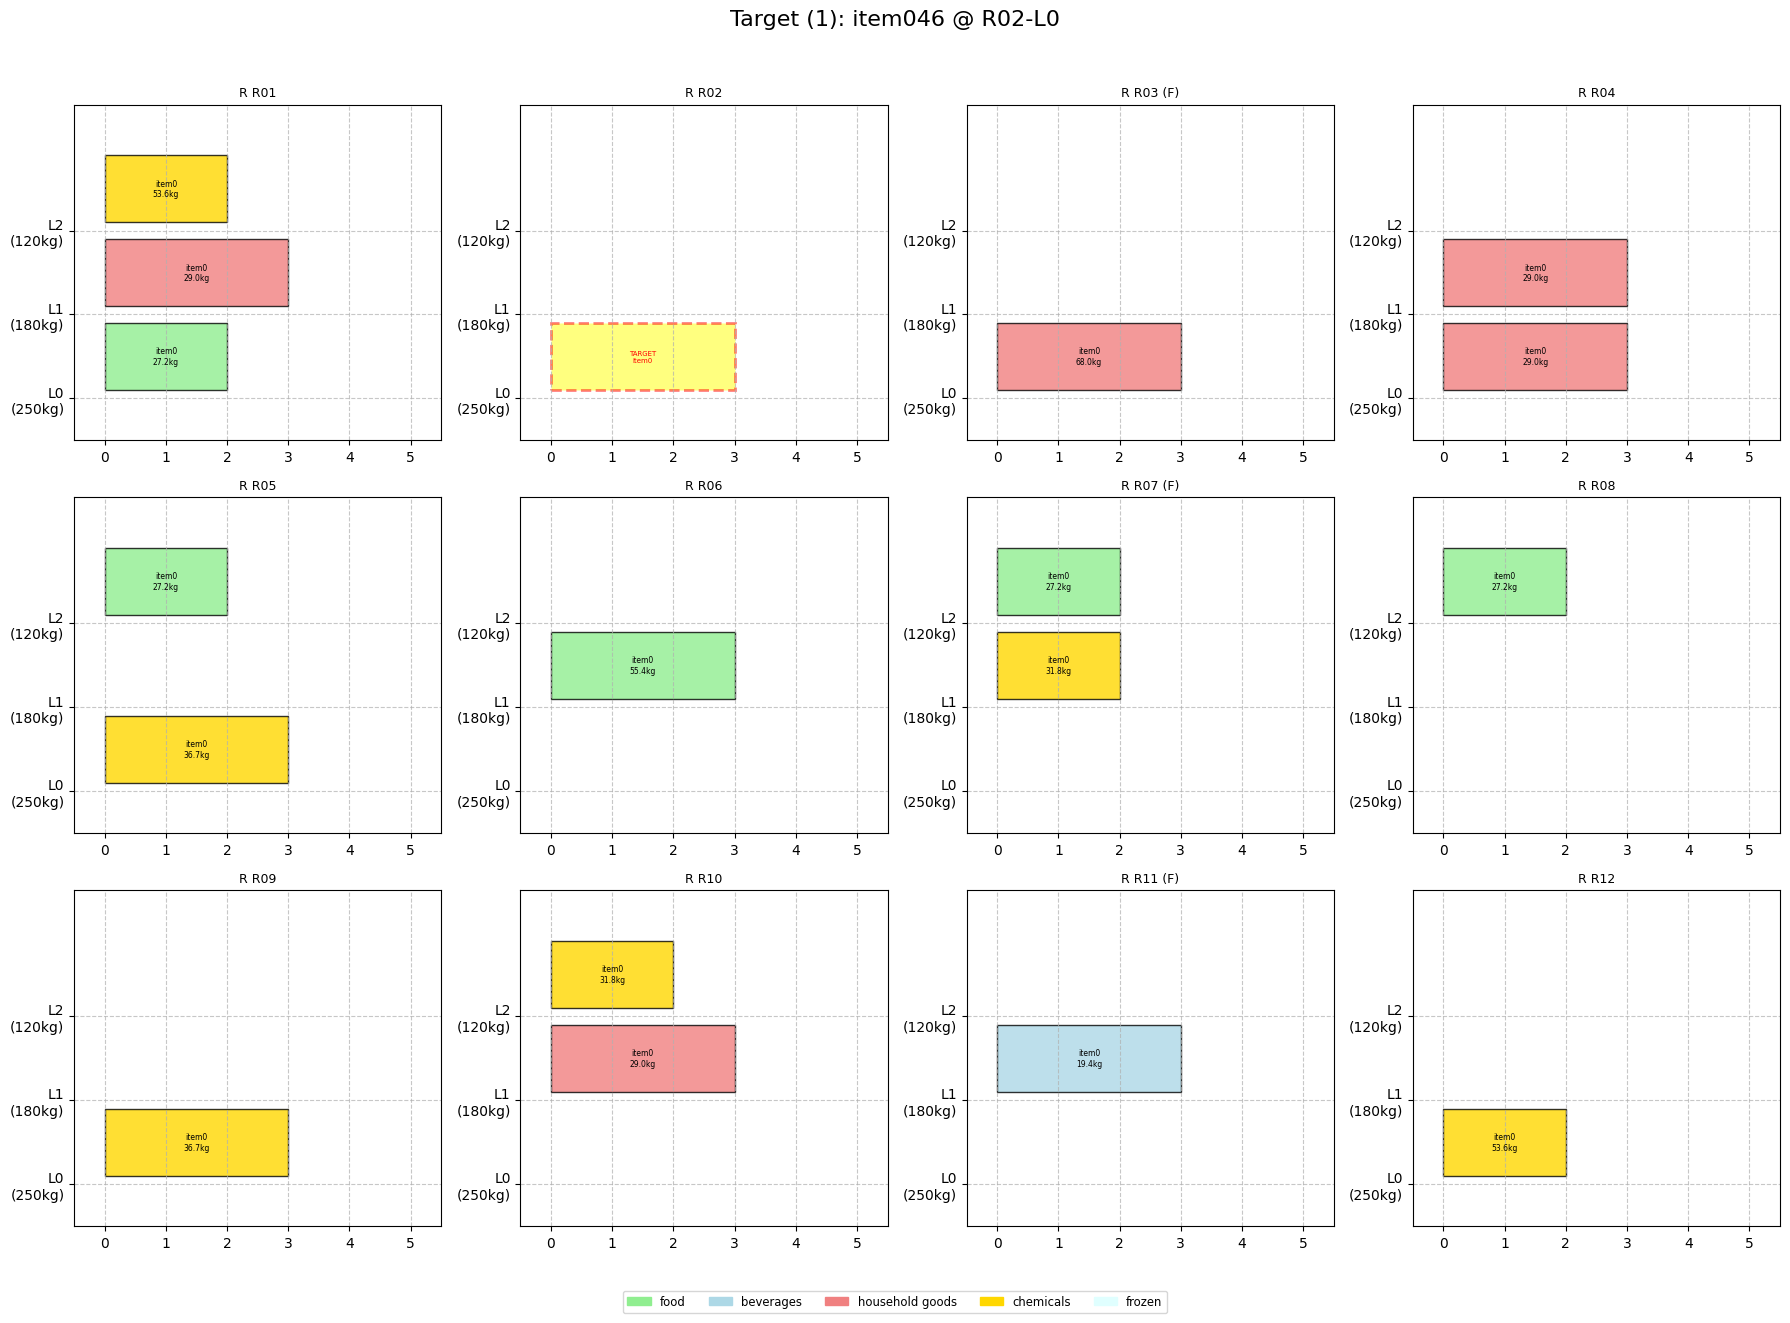


--- Placing item046 at ('R02', 0) ---
Successfully placed item046 in R02-L0.


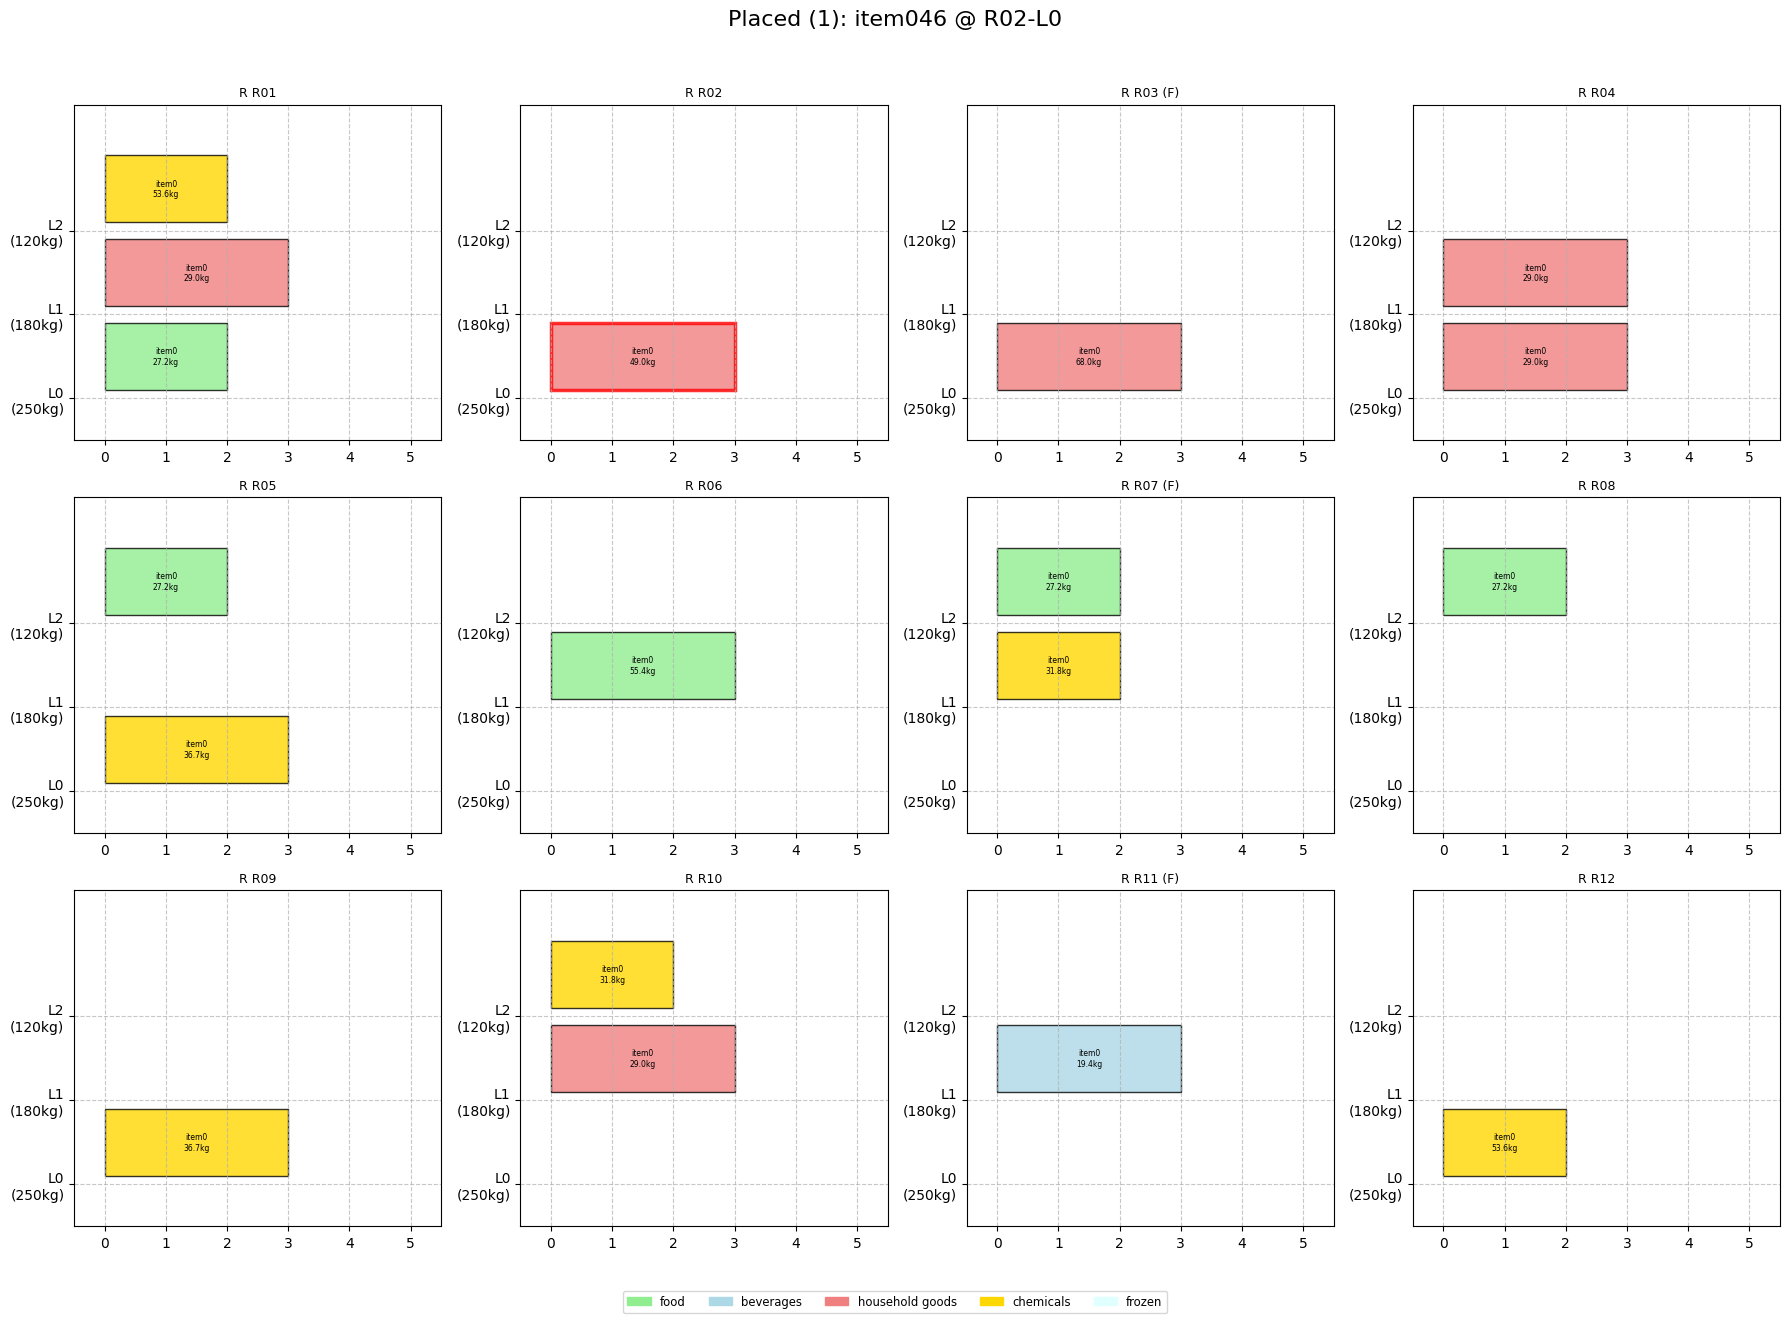



=============== ATTEMPTING INSERTION 2/10 FOR ITEM: item038 ===============

--- Evaluating Placements for: Item(item038,'Value Chemicals Box',W:54.4,S:2,Fq:1.80) ---
------------------------------------------------------------------------------------------
Location     |   Score | Reason/Breakdown                                            
------------------------------------------------------------------------------------------
R01-L0       |    2.97 | Weight:1.50; Space:0.30; Distance:1.17
R01-L1       |    2.67 | Compatibility:0.20; Weight:0.50; Space:0.80; Distance:1.17
R01-L2       |    2.47 | Compatibility:2.00; Weight:-1.00; Space:0.30; Distance:1.17
R02-L0       |    3.74 | Compatibility:0.20; Weight:1.50; Space:0.80; Distance:1.24
R02-L1       |    2.74 | Compatibility:1.00; Weight:0.50; Distance:1.24
R02-L2       |    1.24 | Compatibility:1.00; Weight:-1.00; Distance:1.24
R03-L0       |    -inf | Frozen:FAIL
R03-L1       |   -6.75 | Frozen:-10.00; Compatibility:1.00; Weig

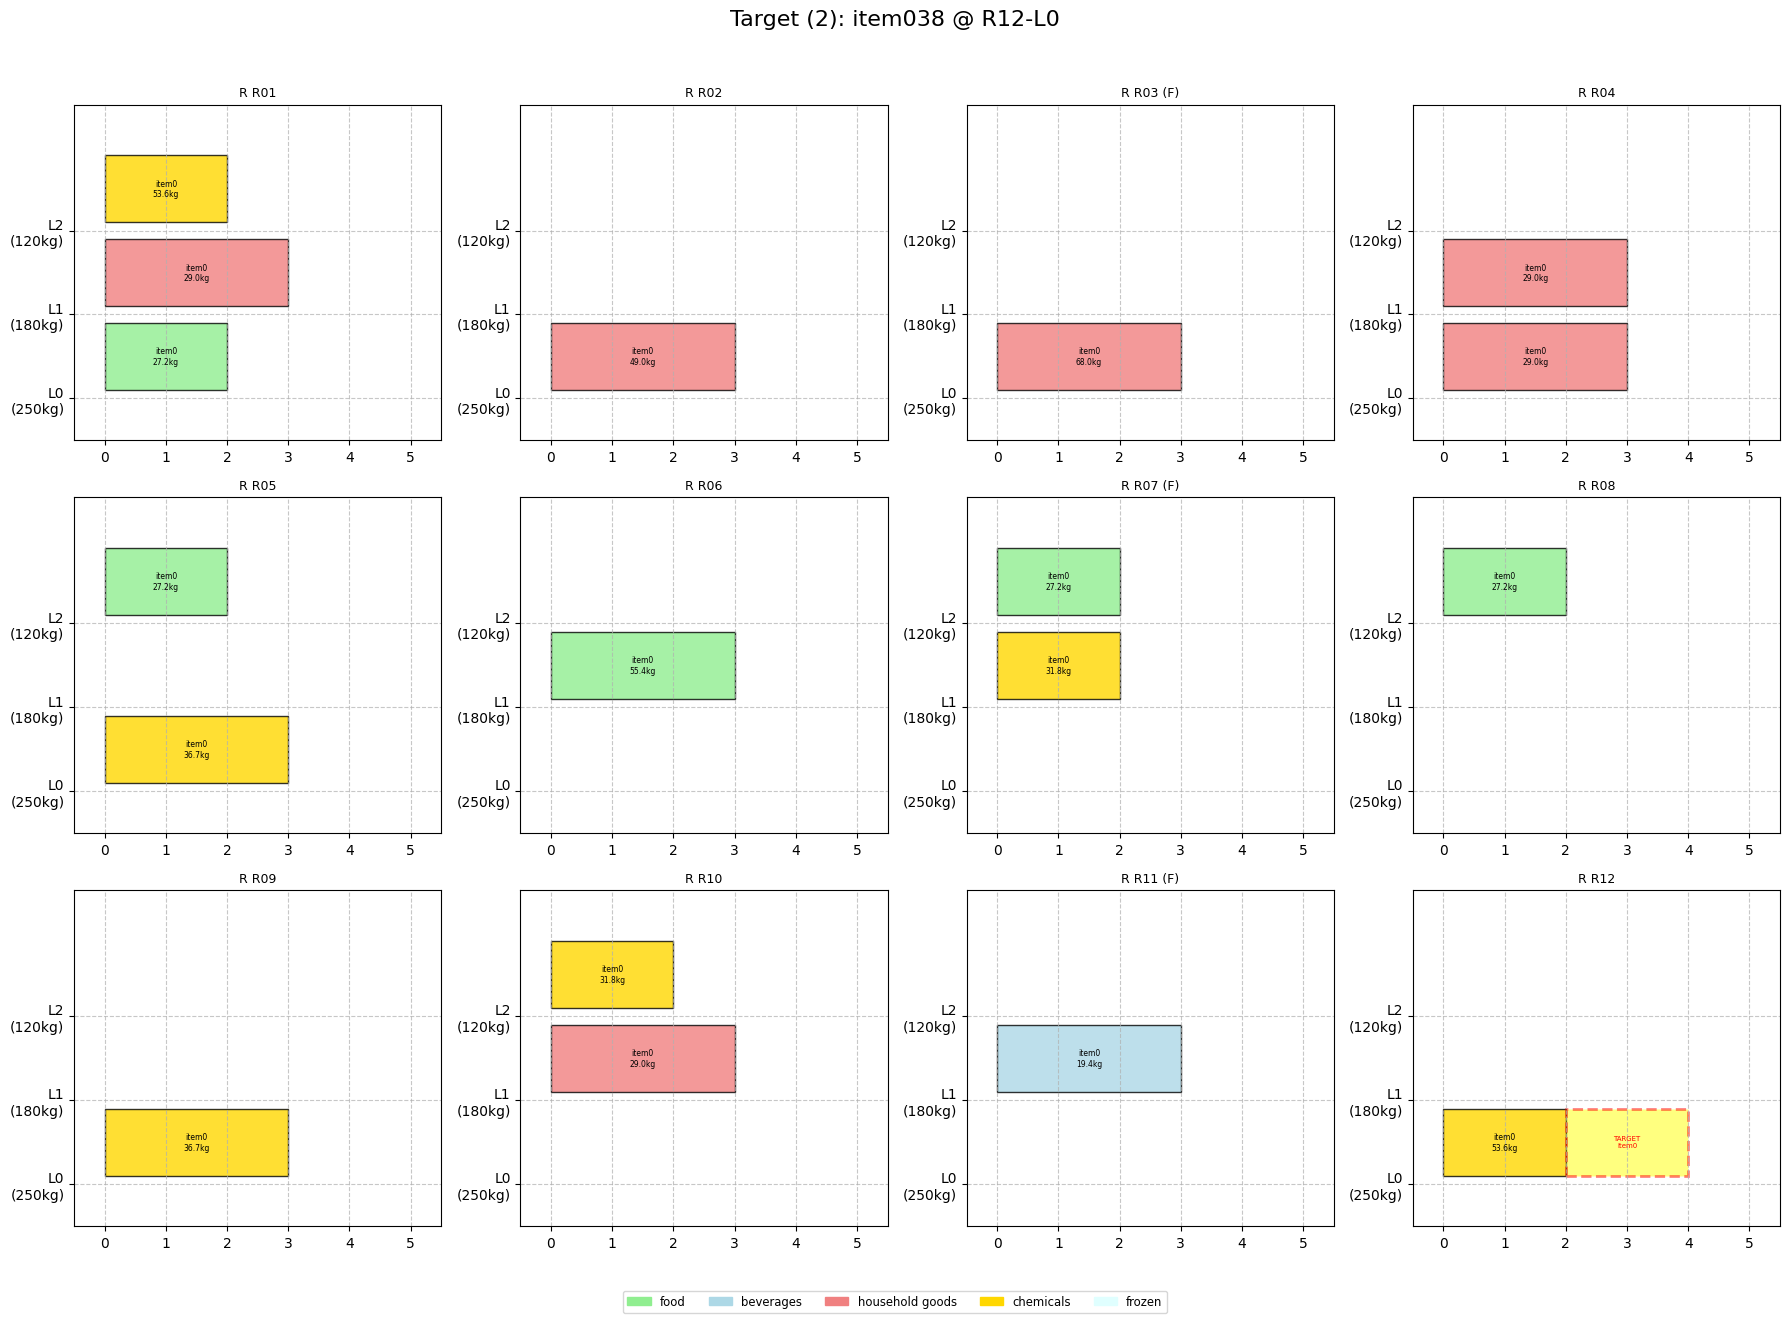


--- Placing item038 at ('R12', 0) ---
Successfully placed item038 in R12-L0.


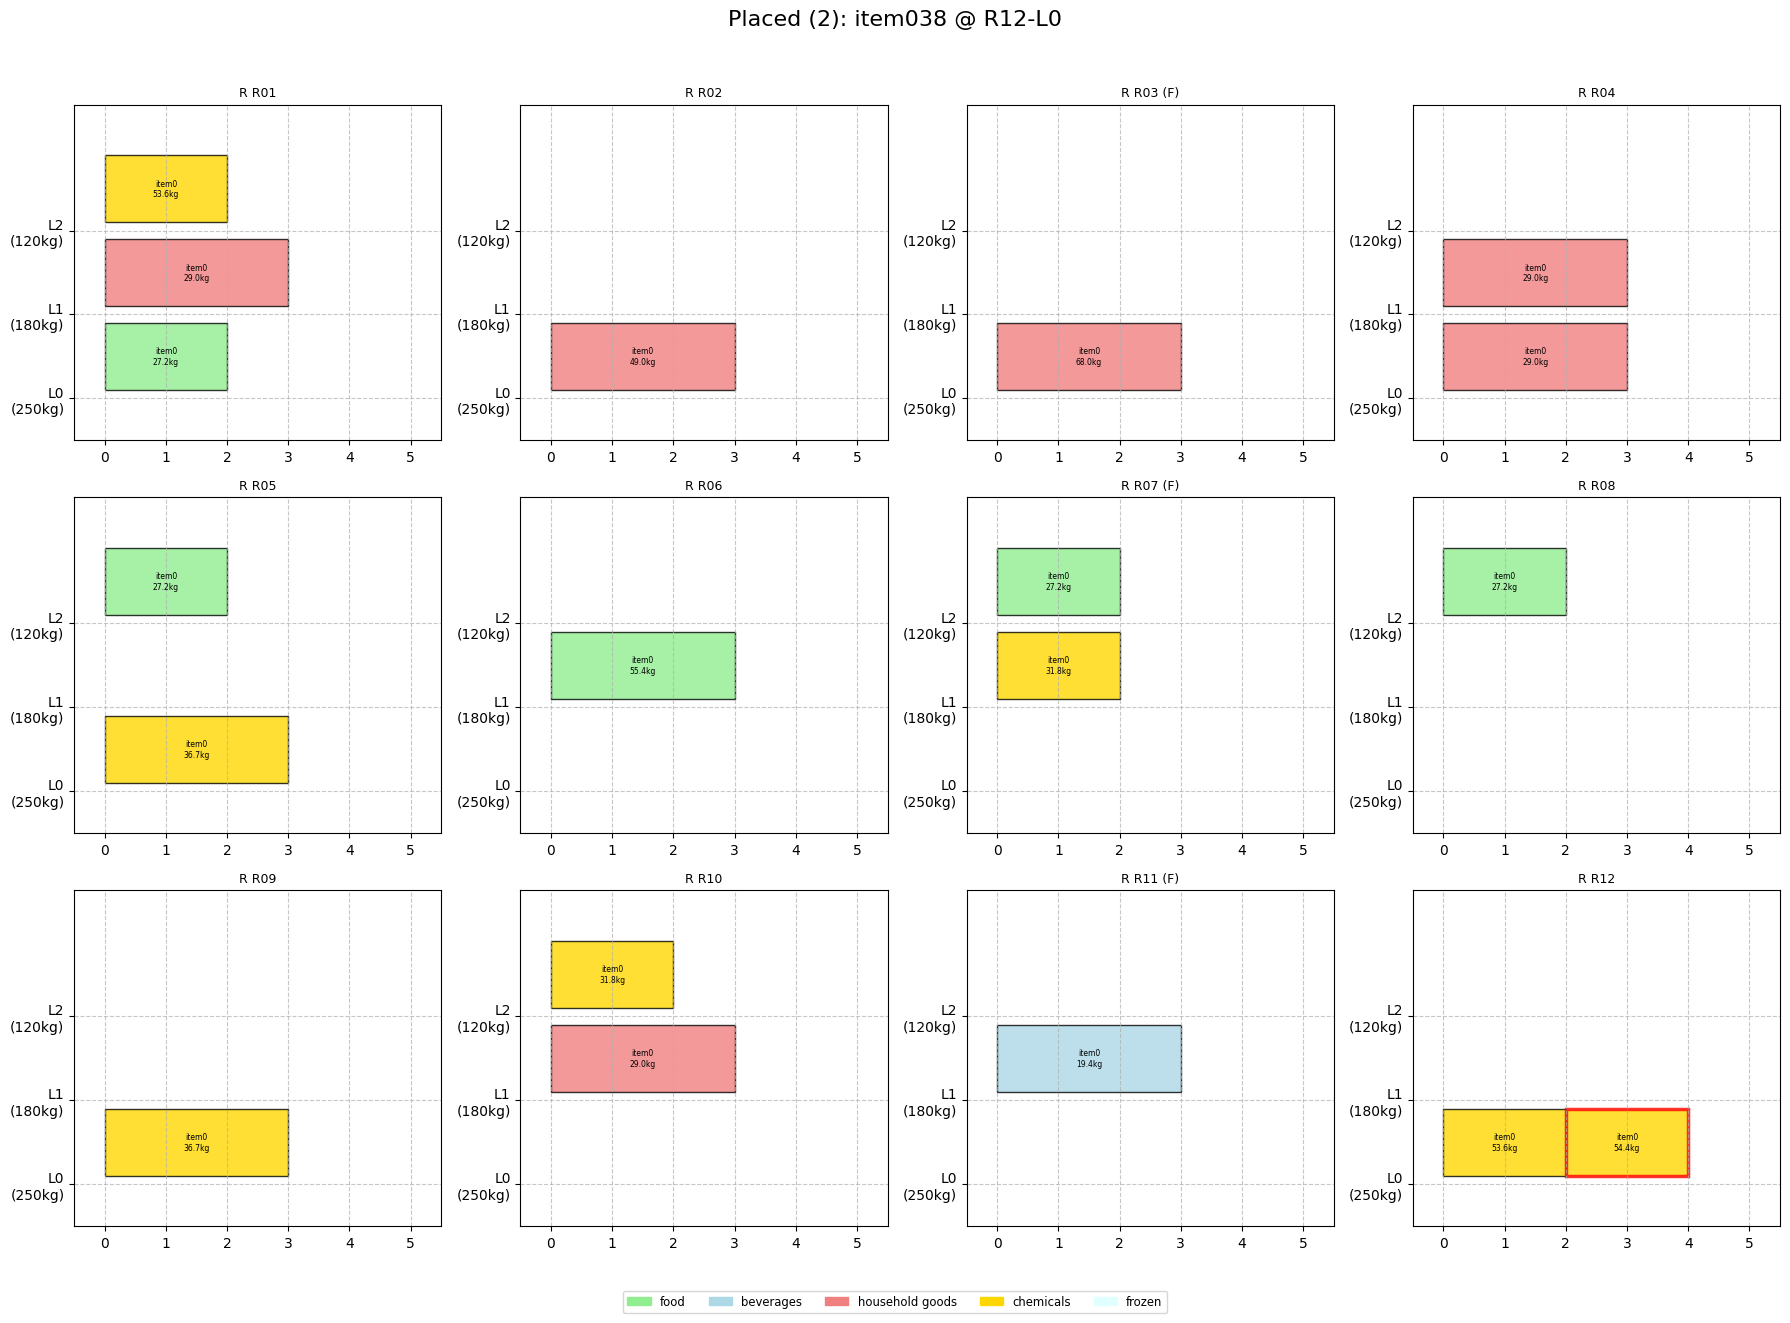



=============== ATTEMPTING INSERTION 3/10 FOR ITEM: item014 ===============

--- Evaluating Placements for: Item(item014,'Eco Beverages Box',W:25.4,S:2,Fq:4.50) ---
------------------------------------------------------------------------------------------
Location     |   Score | Reason/Breakdown                                            
------------------------------------------------------------------------------------------
R01-L0       |    6.15 | Compatibility:1.60; Weight:1.50; Space:0.30; Distance:2.75
R01-L1       |    4.65 | Compatibility:0.60; Weight:0.50; Space:0.80; Distance:2.75
R01-L2       |    2.05 | Weight:-1.00; Space:0.30; Distance:2.75
R02-L0       |    5.81 | Compatibility:0.60; Weight:1.50; Space:0.80; Distance:2.91
R02-L1       |    4.41 | Compatibility:1.00; Weight:0.50; Distance:2.91
R02-L2       |    2.91 | Compatibility:1.00; Weight:-1.00; Distance:2.91
R03-L0       |    -inf | Frozen:FAIL
R03-L1       |   -4.38 | Frozen:-10.00; Compatibility:1.00; Weight

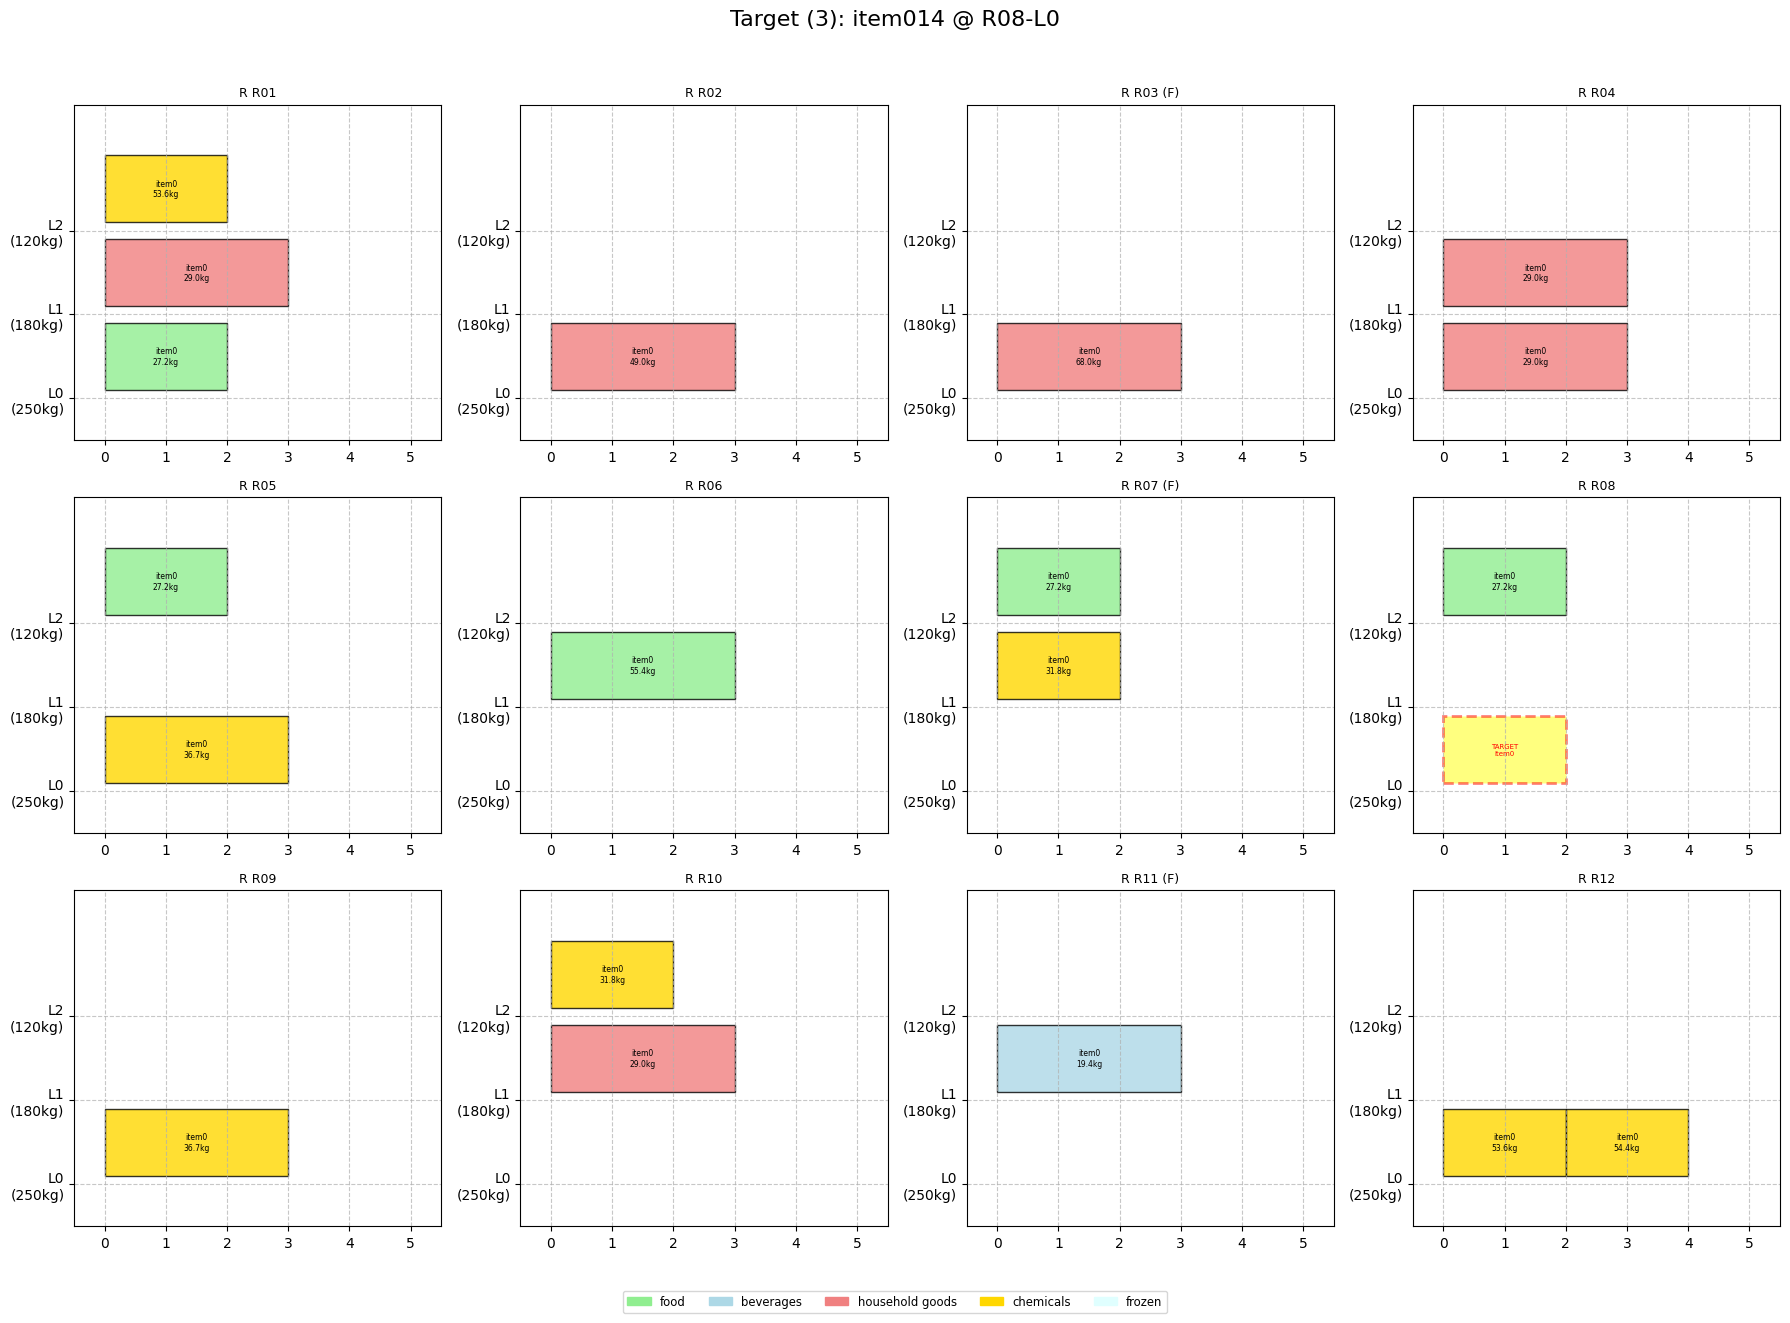


--- Placing item014 at ('R08', 0) ---
Successfully placed item014 in R08-L0.


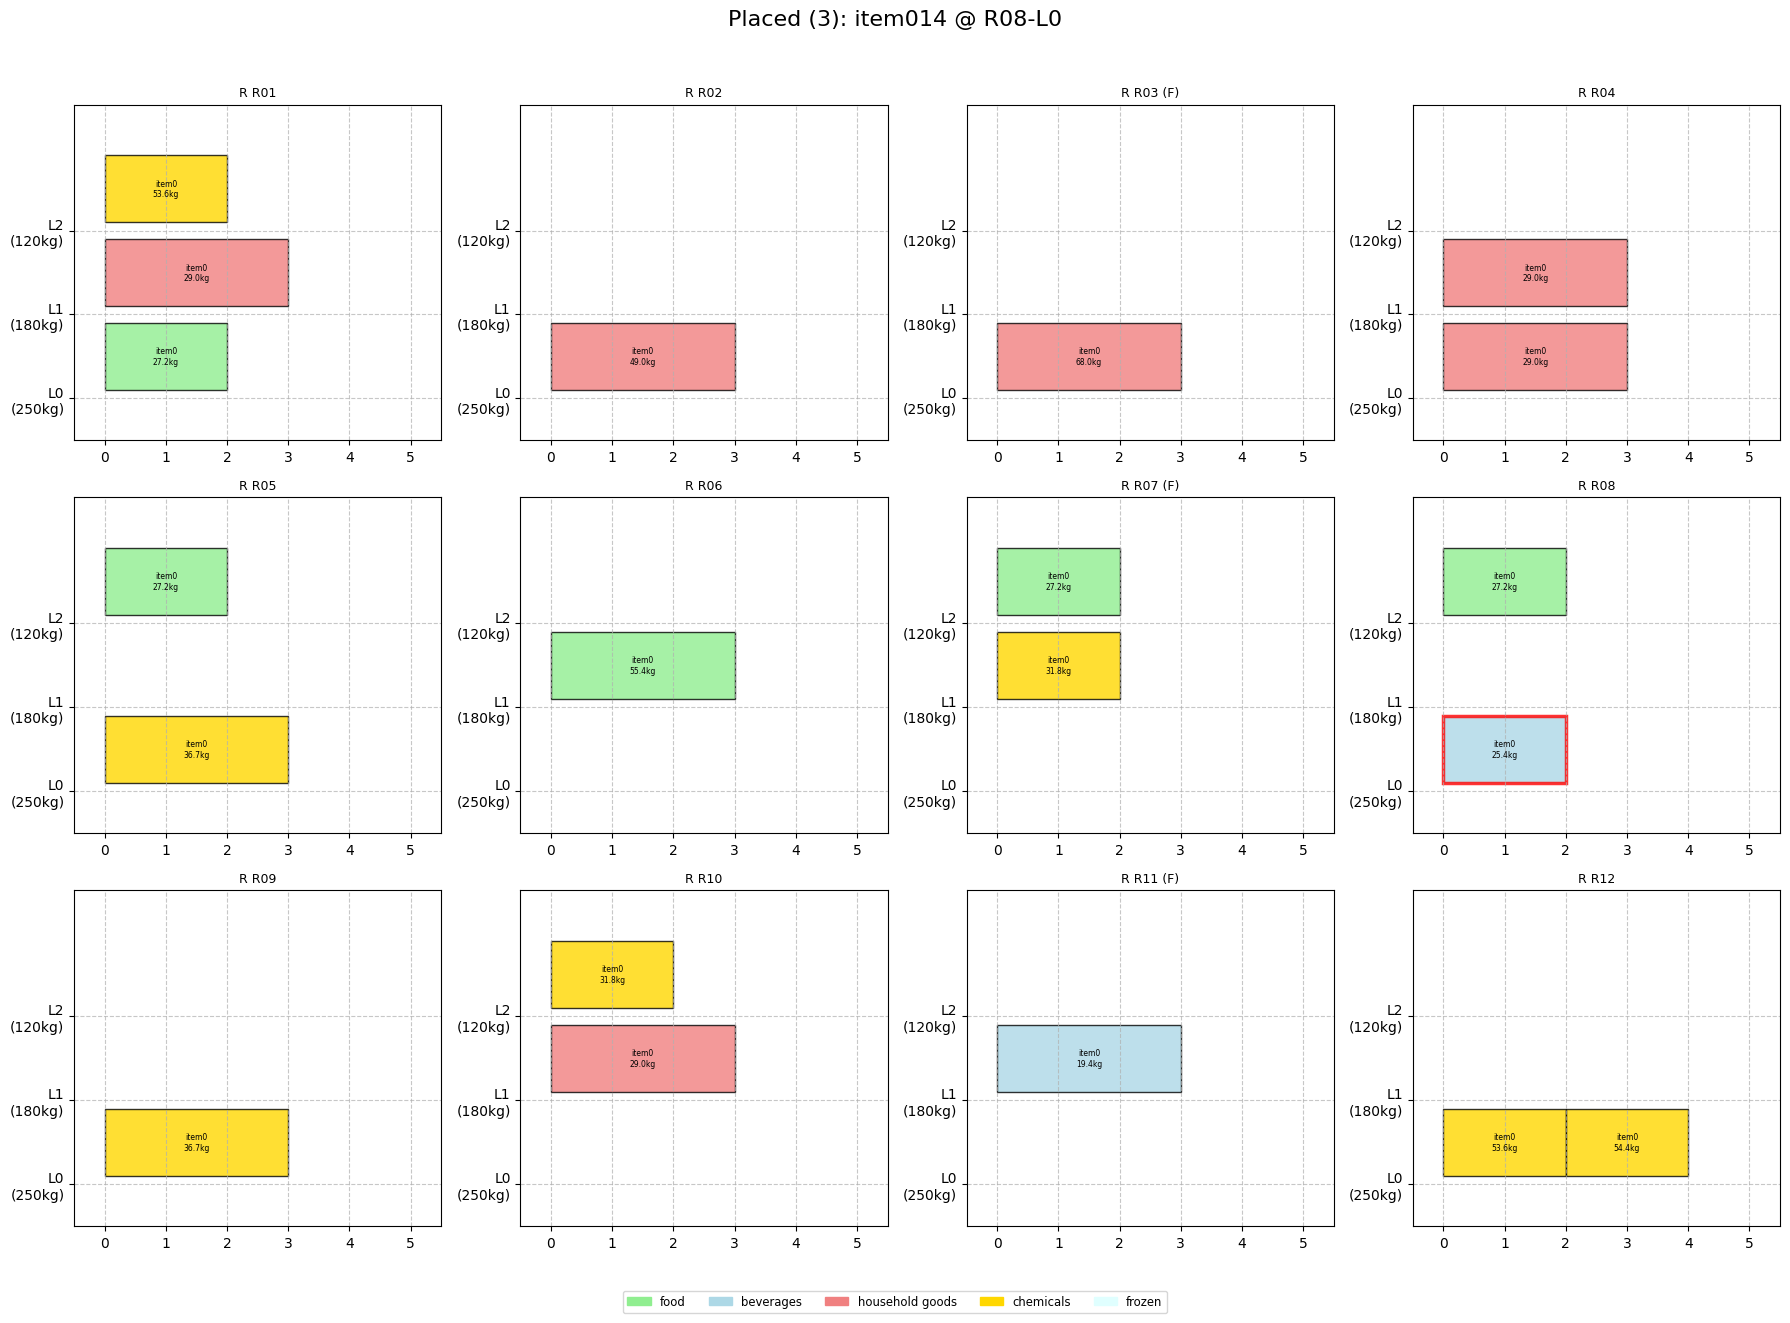



=============== ATTEMPTING INSERTION 4/10 FOR ITEM: item019 ===============

--- Evaluating Placements for: Item(item019,'Eco Chemicals Pack',W:15.4,S:3,Fq:3.64) ---
------------------------------------------------------------------------------------------
Location     |   Score | Reason/Breakdown                                            
------------------------------------------------------------------------------------------
R01-L0       |    3.05 | Space:0.80; Distance:2.25
R01-L1       |    -inf | Slot:FAIL
R01-L2       |    5.25 | Compatibility:2.00; Weight:0.20; Space:0.80; Distance:2.25
R02-L0       |    -inf | Slot:FAIL
R02-L1       |    3.38 | Compatibility:1.00; Distance:2.38
R02-L2       |    3.58 | Compatibility:1.00; Weight:0.20; Distance:2.38
R03-L0       |    -inf | Slot:FAIL
R03-L1       |   -5.63 | Frozen:-10.00; Compatibility:1.00; Distance:3.37
R03-L2       |   -5.43 | Frozen:-10.00; Compatibility:1.00; Weight:0.20; Distance:3.37
R04-L0       |    -inf | Slot:FA

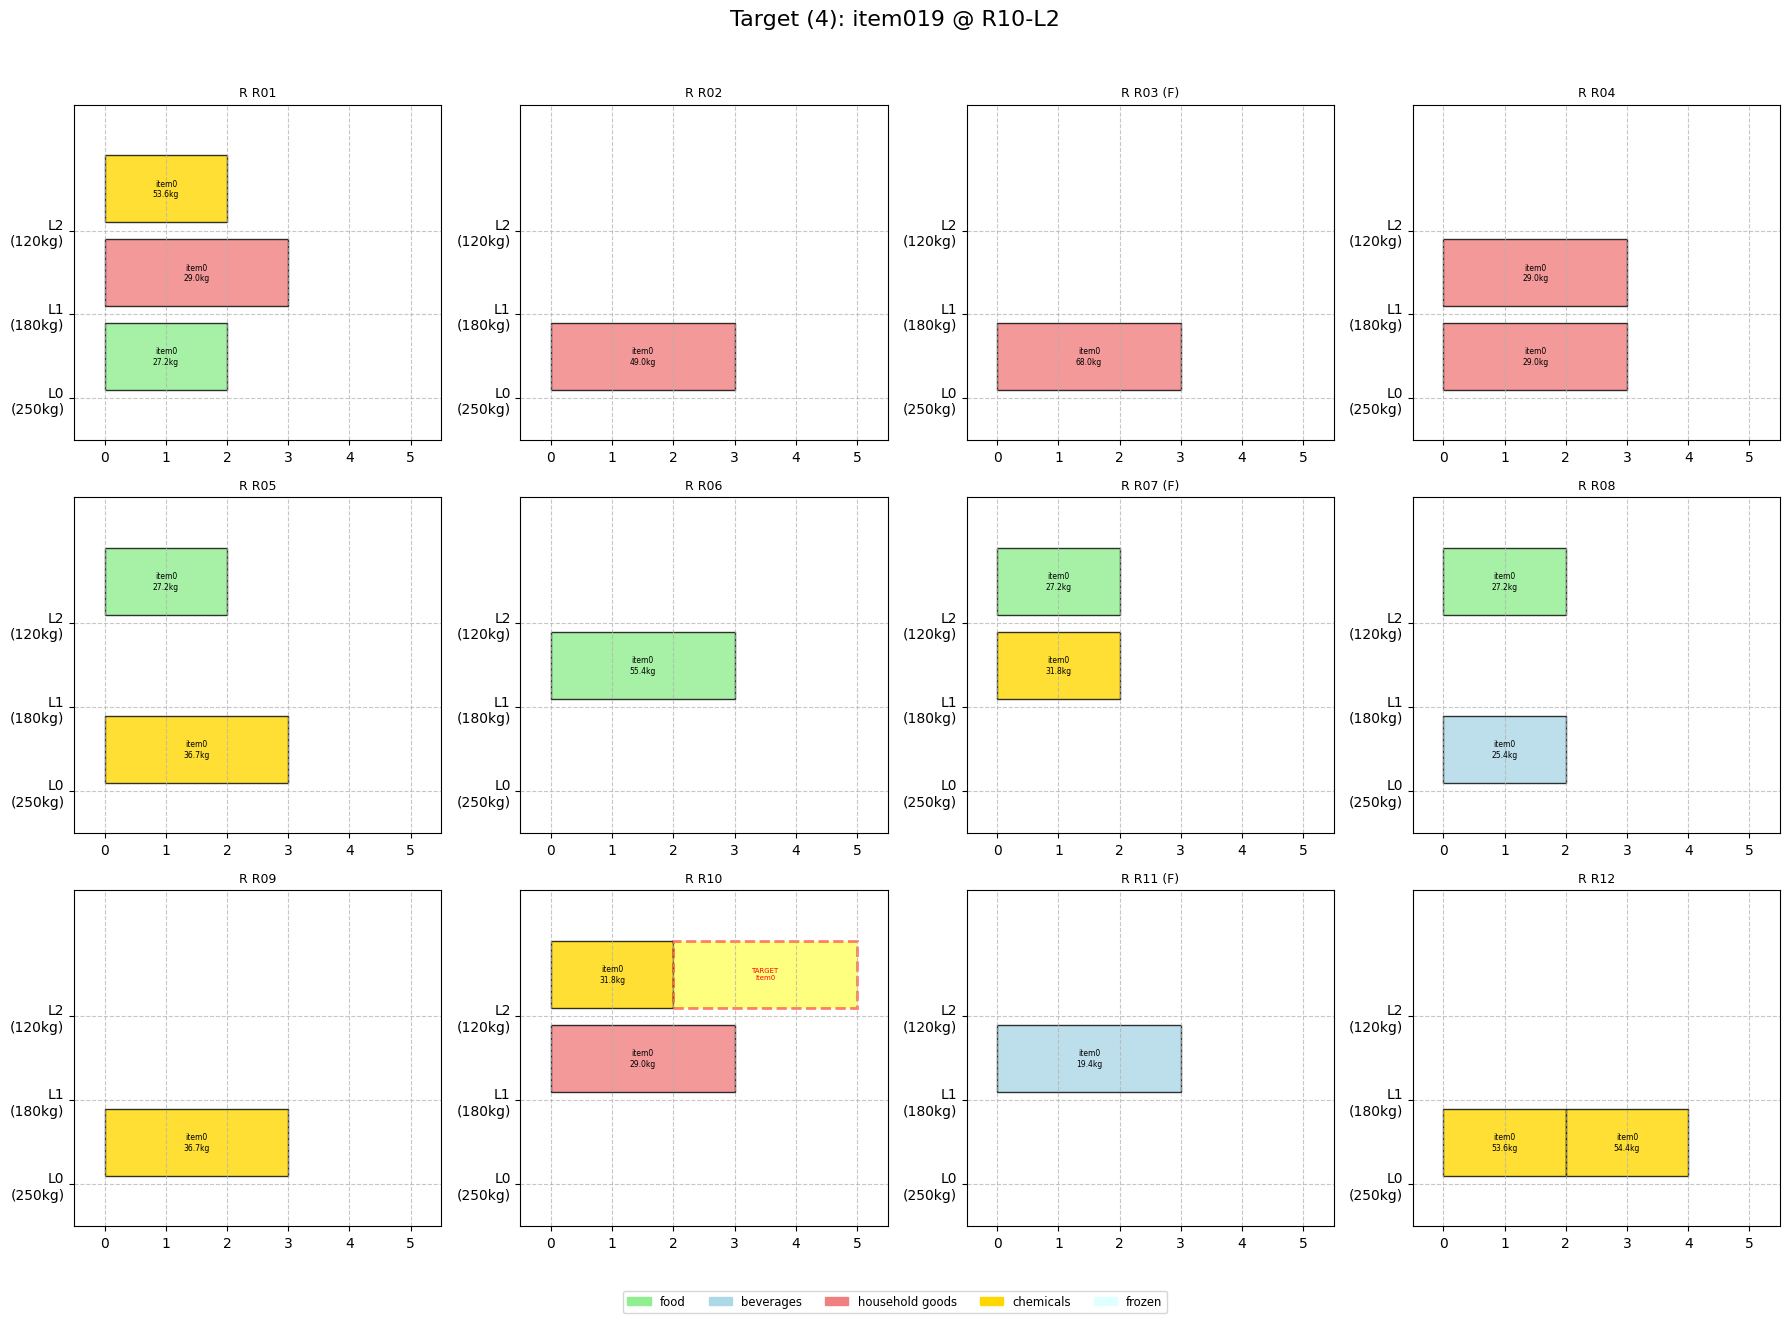


--- Placing item019 at ('R10', 2) ---
Successfully placed item019 in R10-L2.


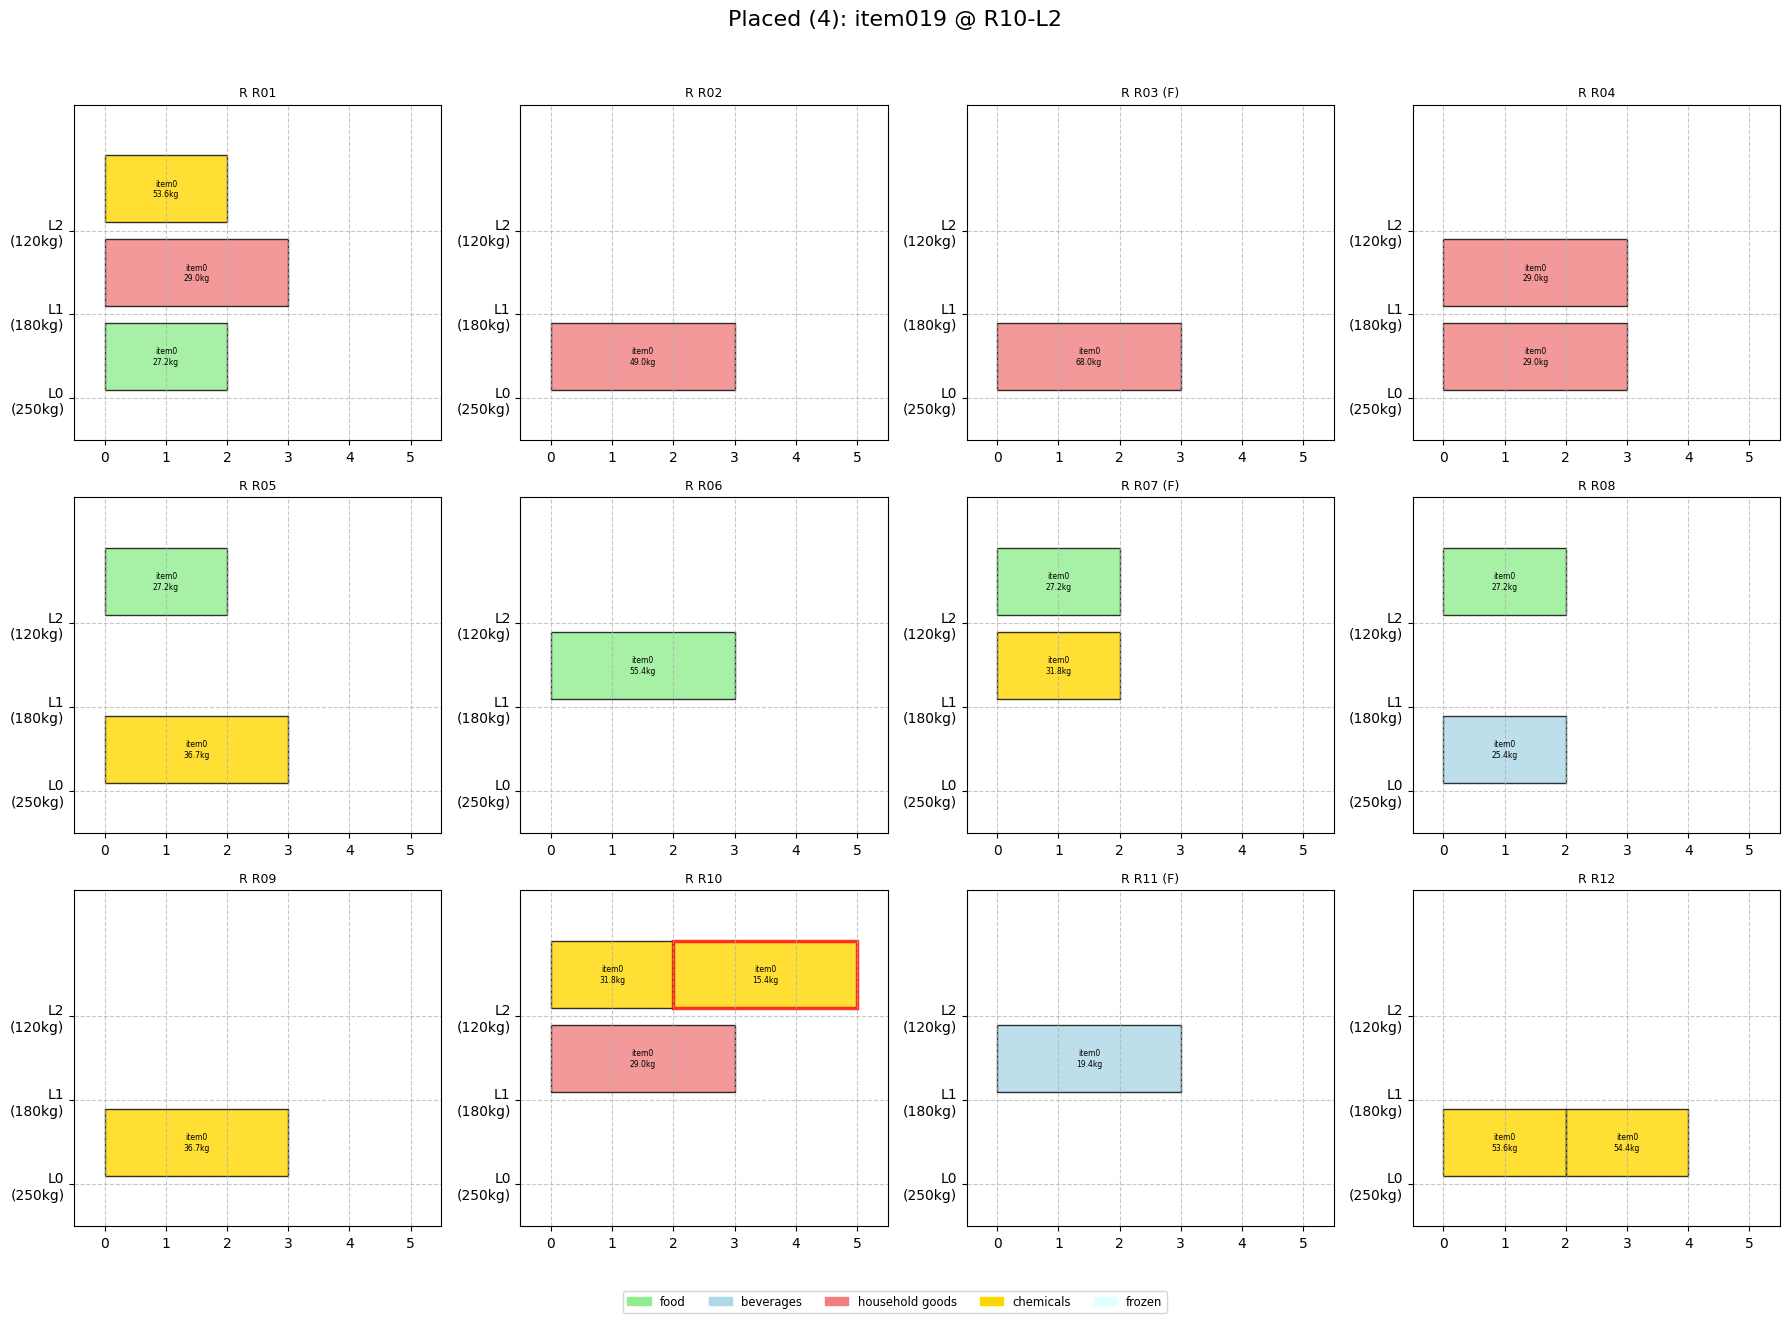



=============== ATTEMPTING INSERTION 5/10 FOR ITEM: item049 ===============

--- Evaluating Placements for: Item(item049,'Value Food Unit',W:57.5,S:1,Fq:21.33) ---
------------------------------------------------------------------------------------------
Location     |   Score | Reason/Breakdown                                            
------------------------------------------------------------------------------------------
R01-L0       |    8.50 | Compatibility:2.00; Weight:1.50; Distance:5.00
R01-L1       |    6.20 | Compatibility:0.40; Weight:0.50; Space:0.30; Distance:5.00
R01-L2       |    4.00 | Weight:-1.00; Distance:5.00
R02-L0       |    7.20 | Compatibility:0.40; Weight:1.50; Space:0.30; Distance:5.00
R02-L1       |    6.50 | Compatibility:1.00; Weight:0.50; Distance:5.00
R02-L2       |    5.00 | Compatibility:1.00; Weight:-1.00; Distance:5.00
R03-L0       |    -inf | Frozen:FAIL
R03-L1       |   -3.50 | Frozen:-10.00; Compatibility:1.00; Weight:0.50; Distance:5.00
R03-

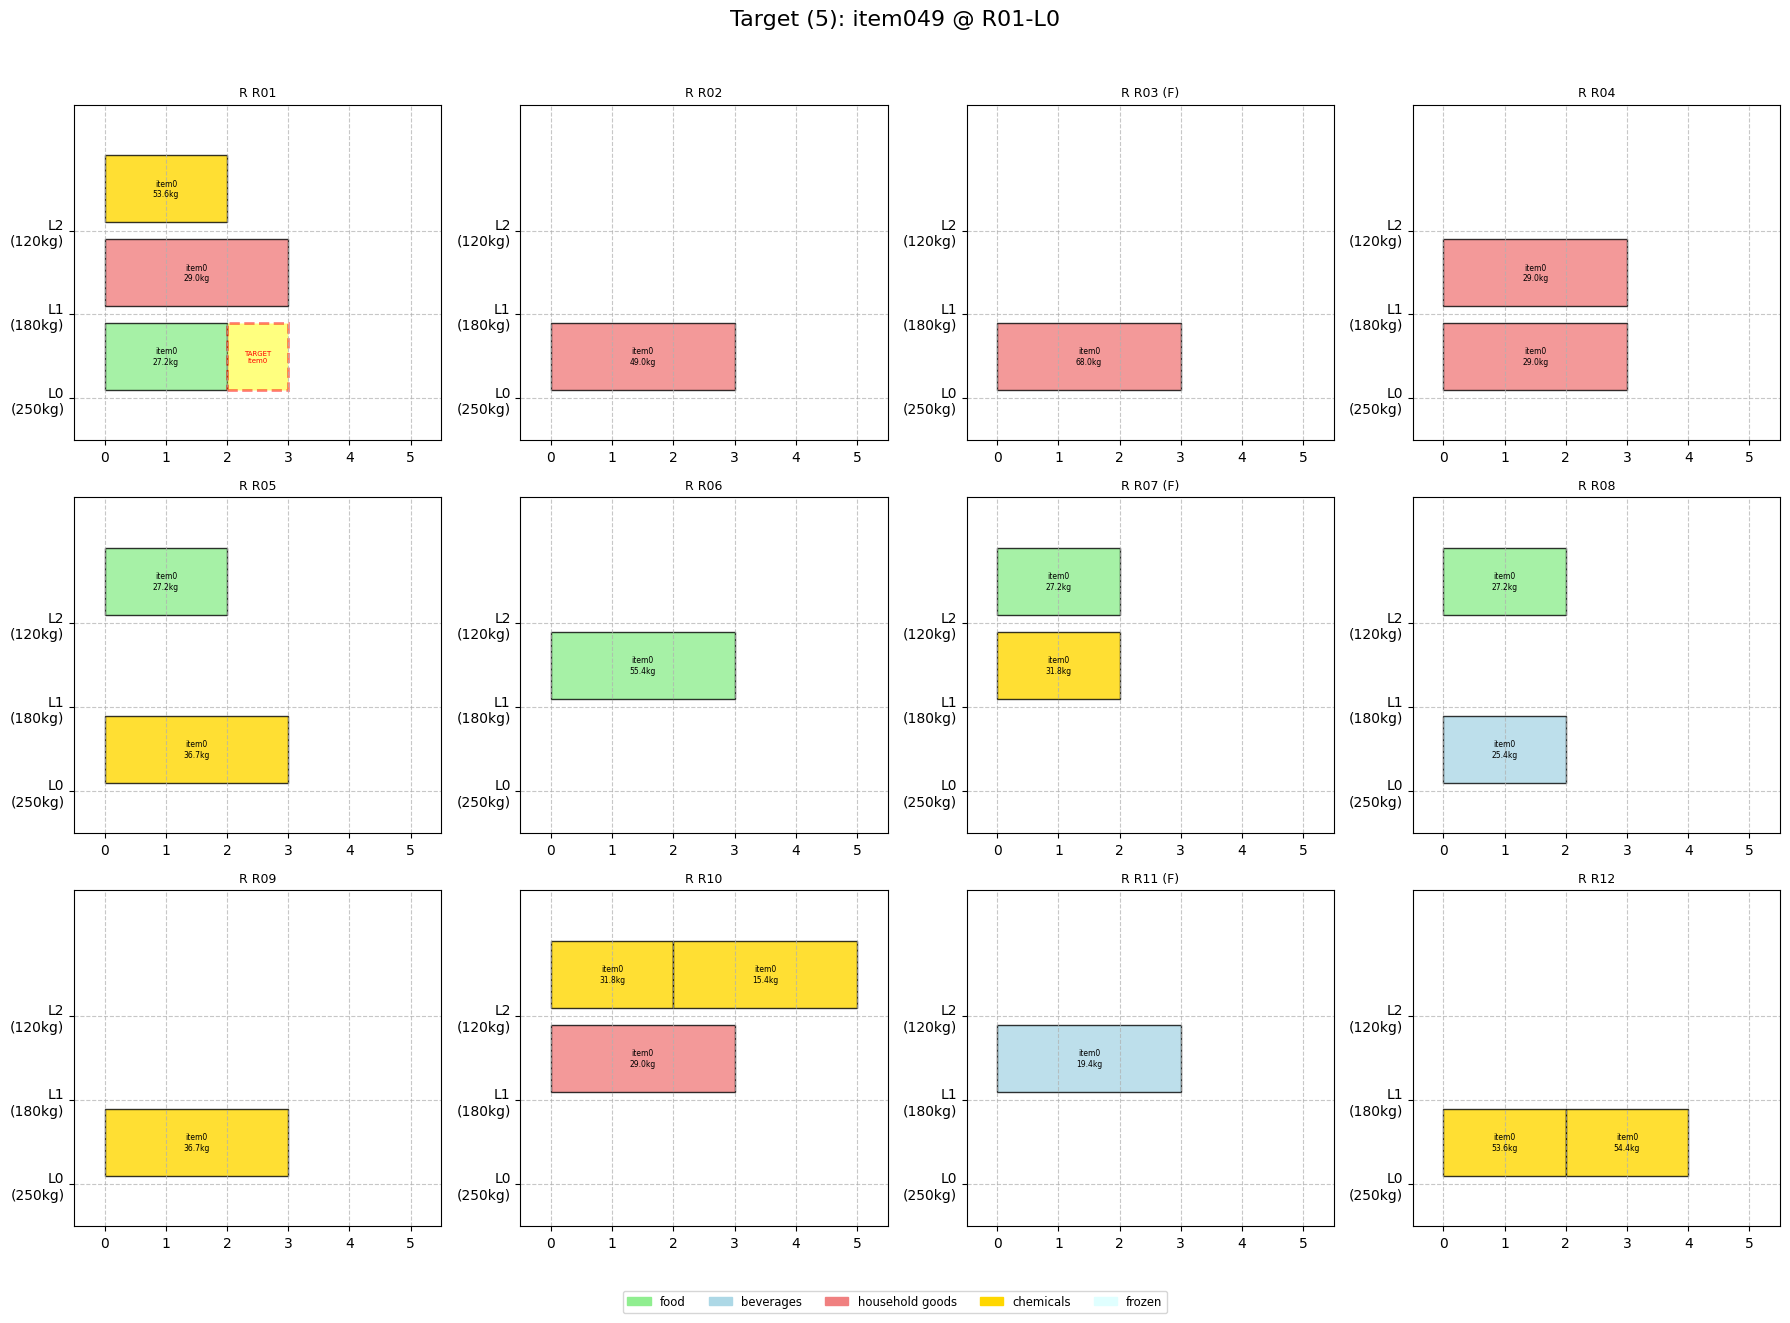


--- Placing item049 at ('R01', 0) ---
Successfully placed item049 in R01-L0.


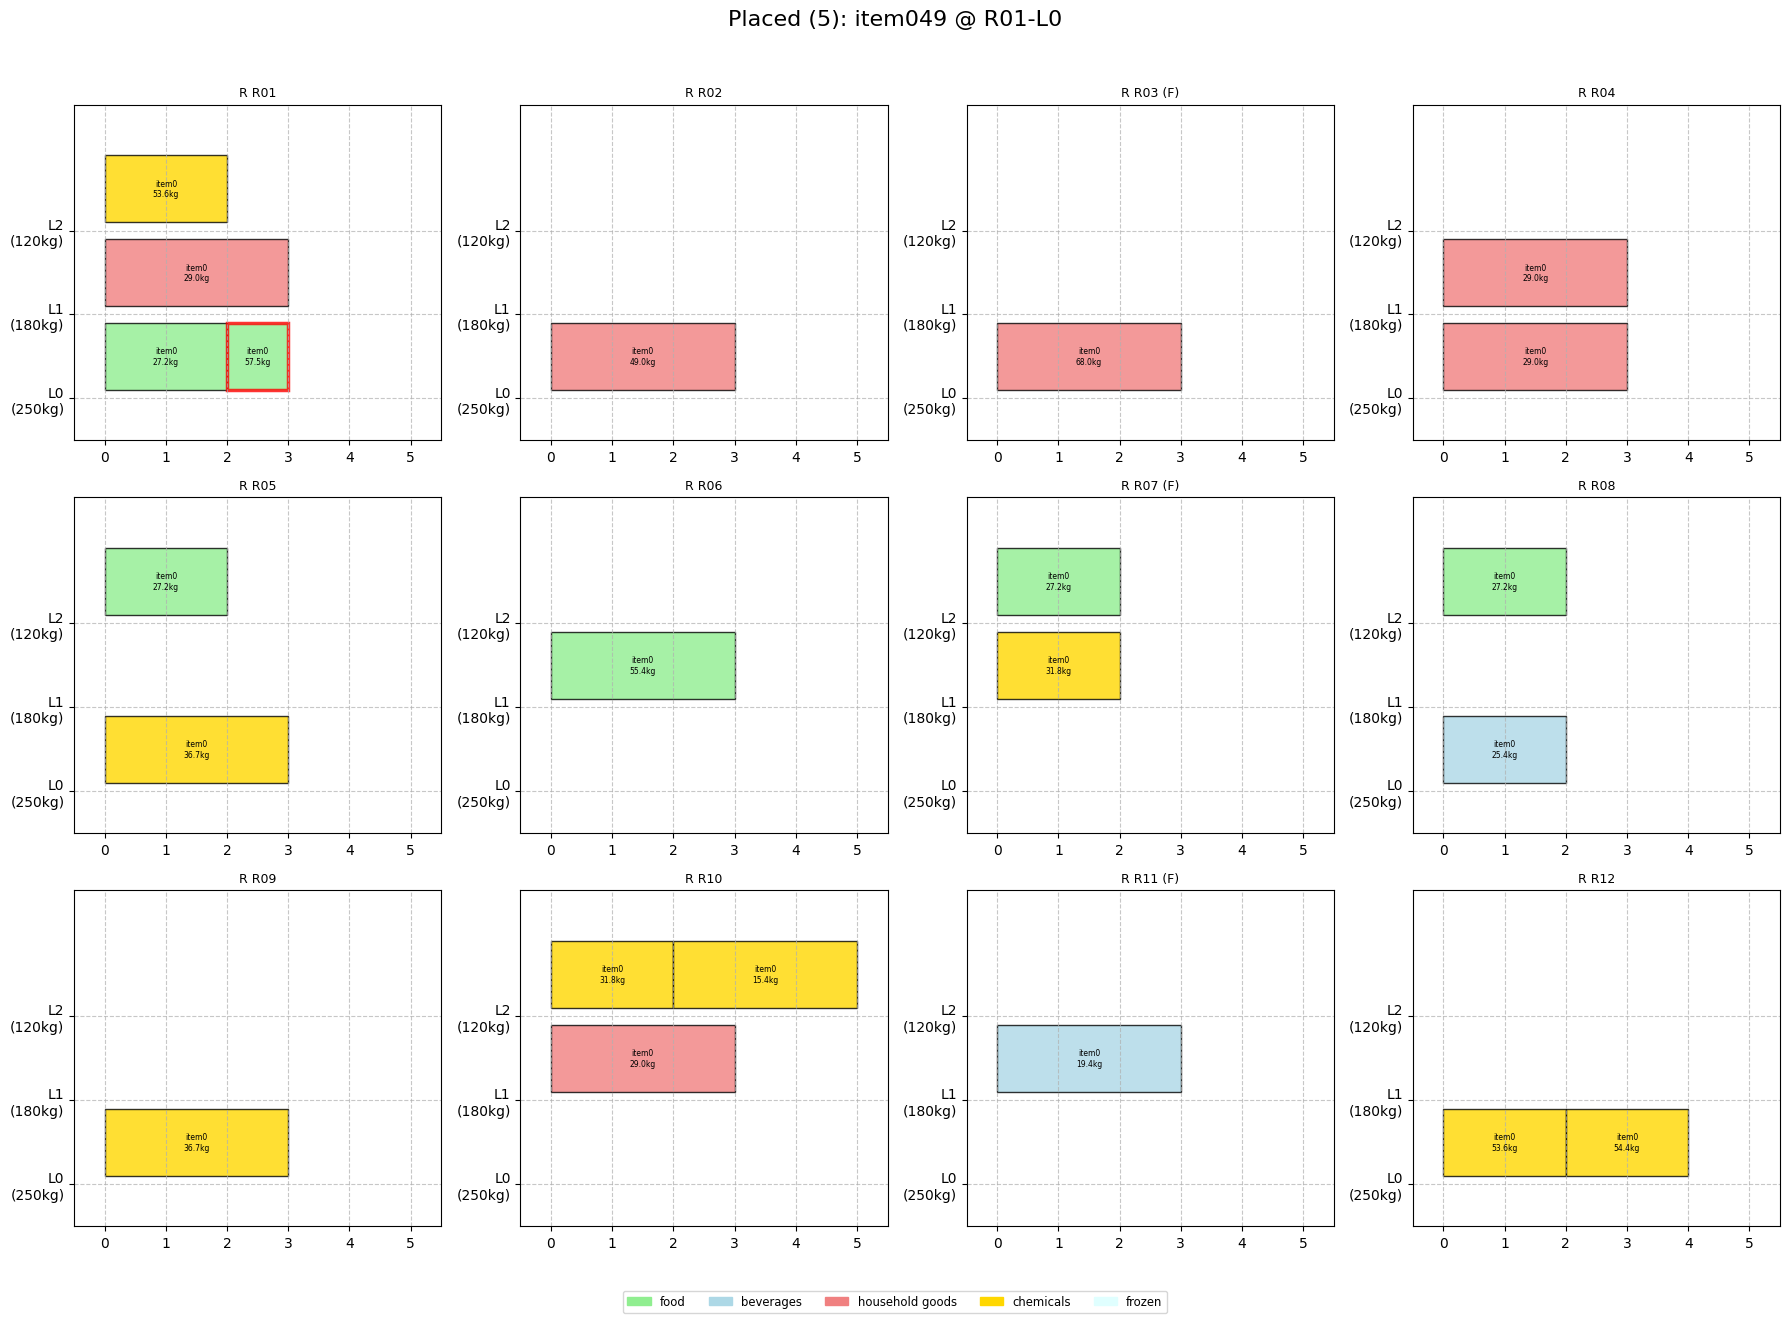



=============== ATTEMPTING INSERTION 6/10 FOR ITEM: item030 ===============

--- Evaluating Placements for: Item(item030,'Eco Beverages Box',W:9.3,S:2,Fq:5.87) ---
------------------------------------------------------------------------------------------
Location     |   Score | Reason/Breakdown                                            
------------------------------------------------------------------------------------------
R01-L0       |    5.95 | Compatibility:1.60; Space:0.80; Distance:3.55
R01-L1       |    4.95 | Compatibility:0.60; Space:0.80; Distance:3.55
R01-L2       |    4.05 | Weight:0.20; Space:0.30; Distance:3.55
R02-L0       |    5.16 | Compatibility:0.60; Space:0.80; Distance:3.76
R02-L1       |    4.76 | Compatibility:1.00; Distance:3.76
R02-L2       |    4.96 | Compatibility:1.00; Weight:0.20; Distance:3.76
R03-L0       |    -inf | Frozen:FAIL
R03-L1       |   -4.00 | Frozen:-10.00; Compatibility:1.00; Distance:5.00
R03-L2       |   -3.80 | Frozen:-10.00; Compati

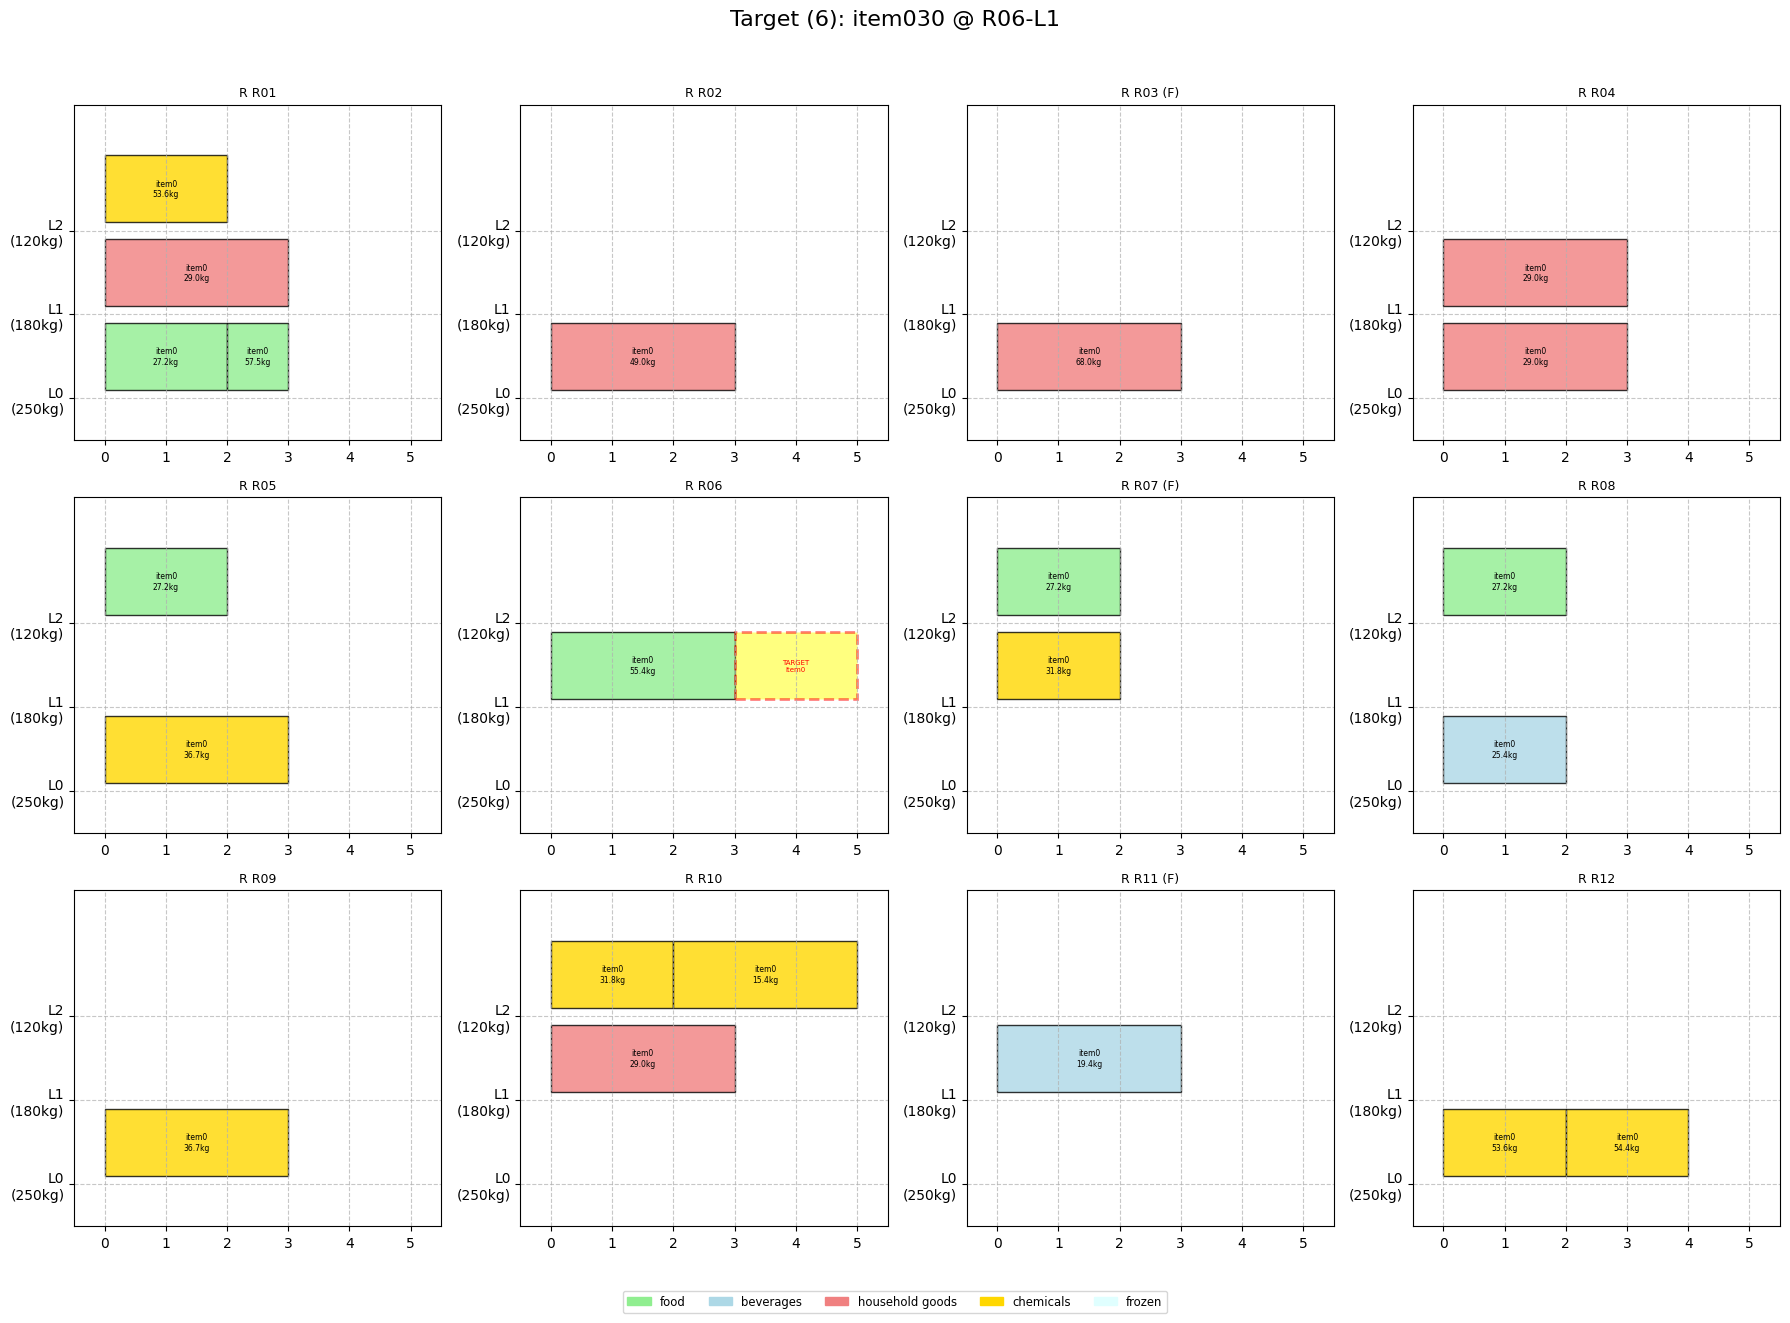


--- Placing item030 at ('R06', 1) ---
Successfully placed item030 in R06-L1.


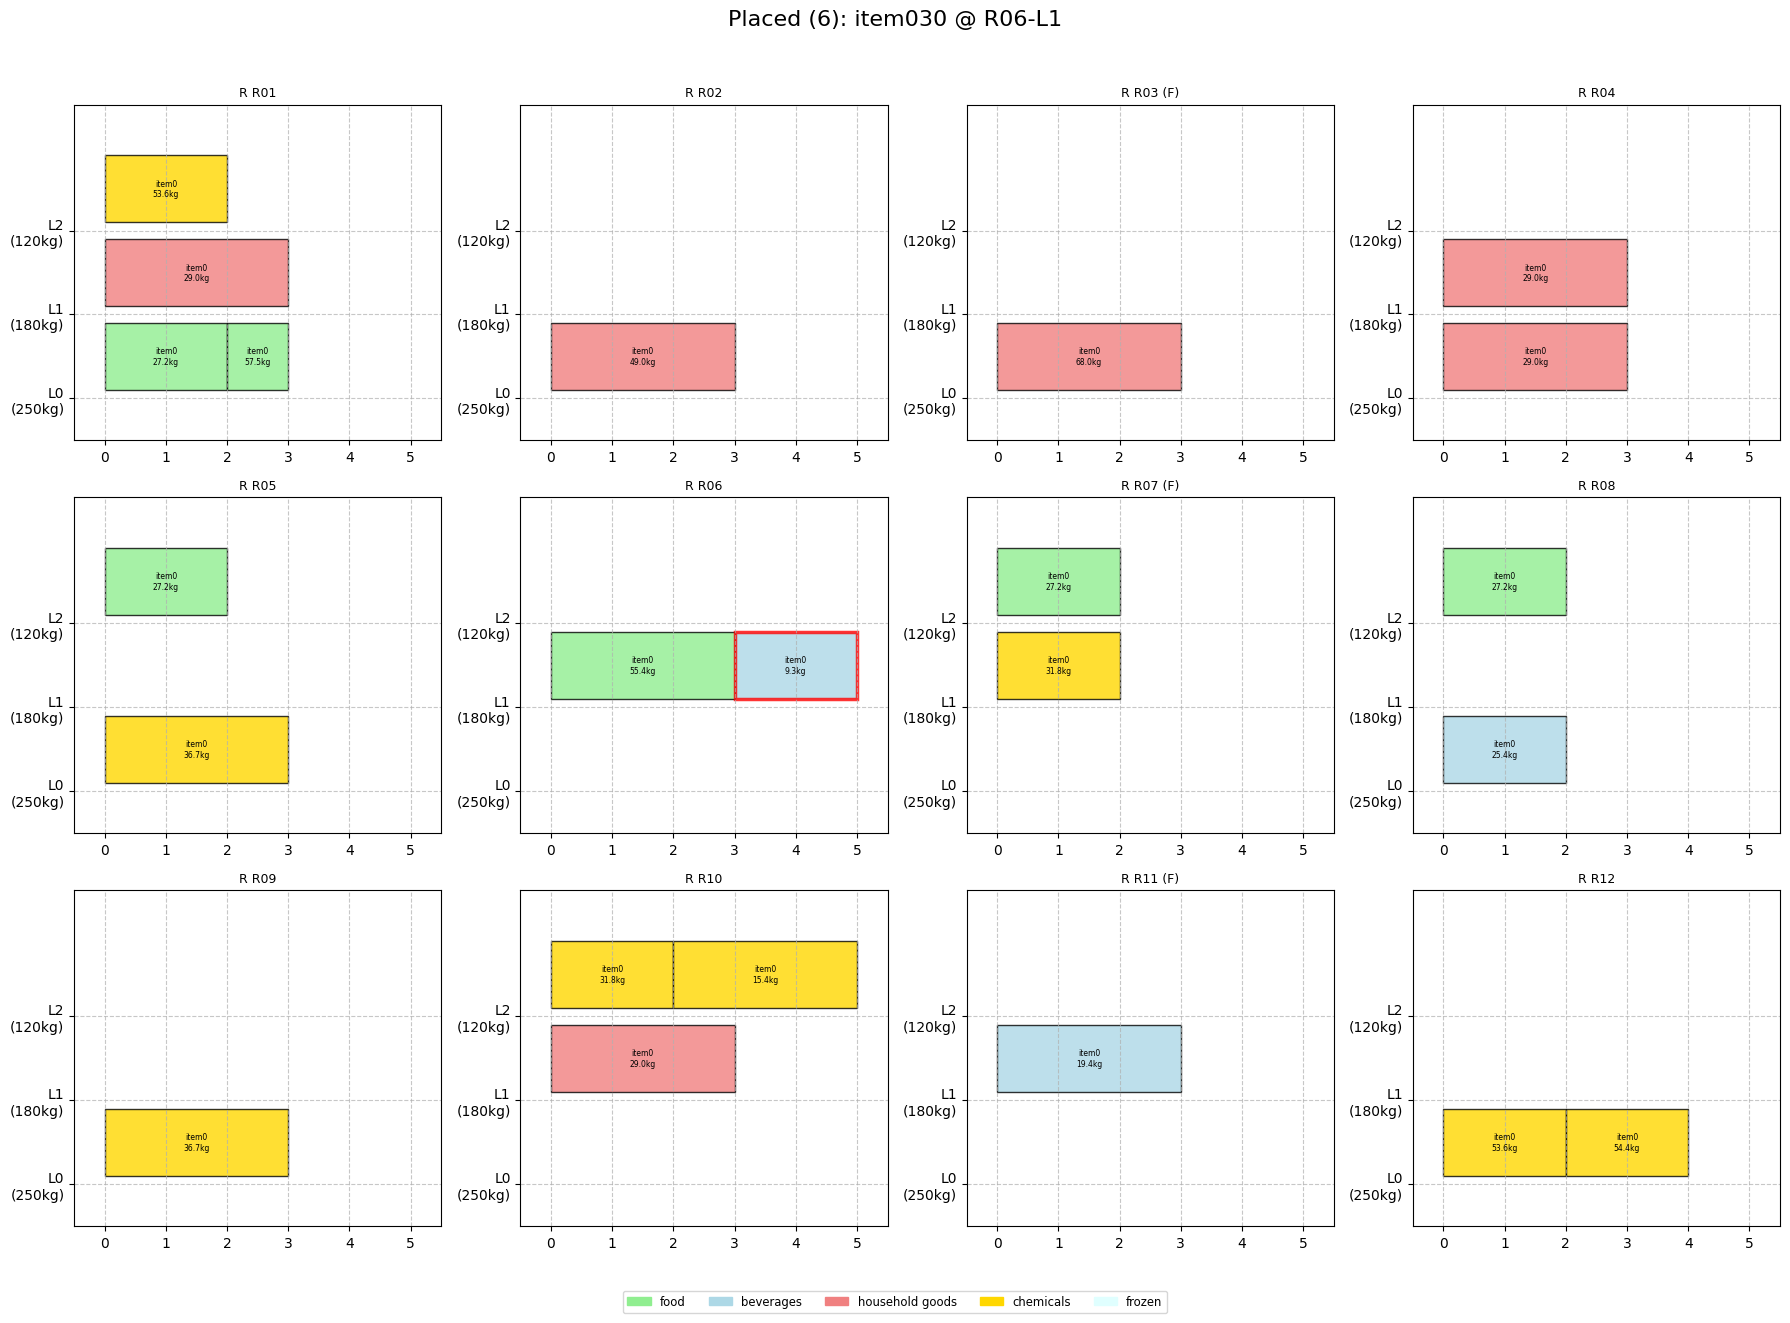



=============== ATTEMPTING INSERTION 7/10 FOR ITEM: item013 ===============

--- Evaluating Placements for: Item(item013,'Value Food Unit',W:49.8,S:2,Fq:8.33) ---
------------------------------------------------------------------------------------------
Location     |   Score | Reason/Breakdown                                            
------------------------------------------------------------------------------------------
R01-L0       |    9.29 | Compatibility:2.00; Weight:1.50; Space:0.80; Distance:4.99
R01-L1       |    6.69 | Compatibility:0.40; Weight:0.50; Space:0.80; Distance:4.99
R01-L2       |    4.29 | Weight:-1.00; Space:0.30; Distance:4.99
R02-L0       |    7.70 | Compatibility:0.40; Weight:1.50; Space:0.80; Distance:5.00
R02-L1       |    6.50 | Compatibility:1.00; Weight:0.50; Distance:5.00
R02-L2       |    5.00 | Compatibility:1.00; Weight:-1.00; Distance:5.00
R03-L0       |    -inf | Frozen:FAIL
R03-L1       |   -3.50 | Frozen:-10.00; Compatibility:1.00; Weight:0

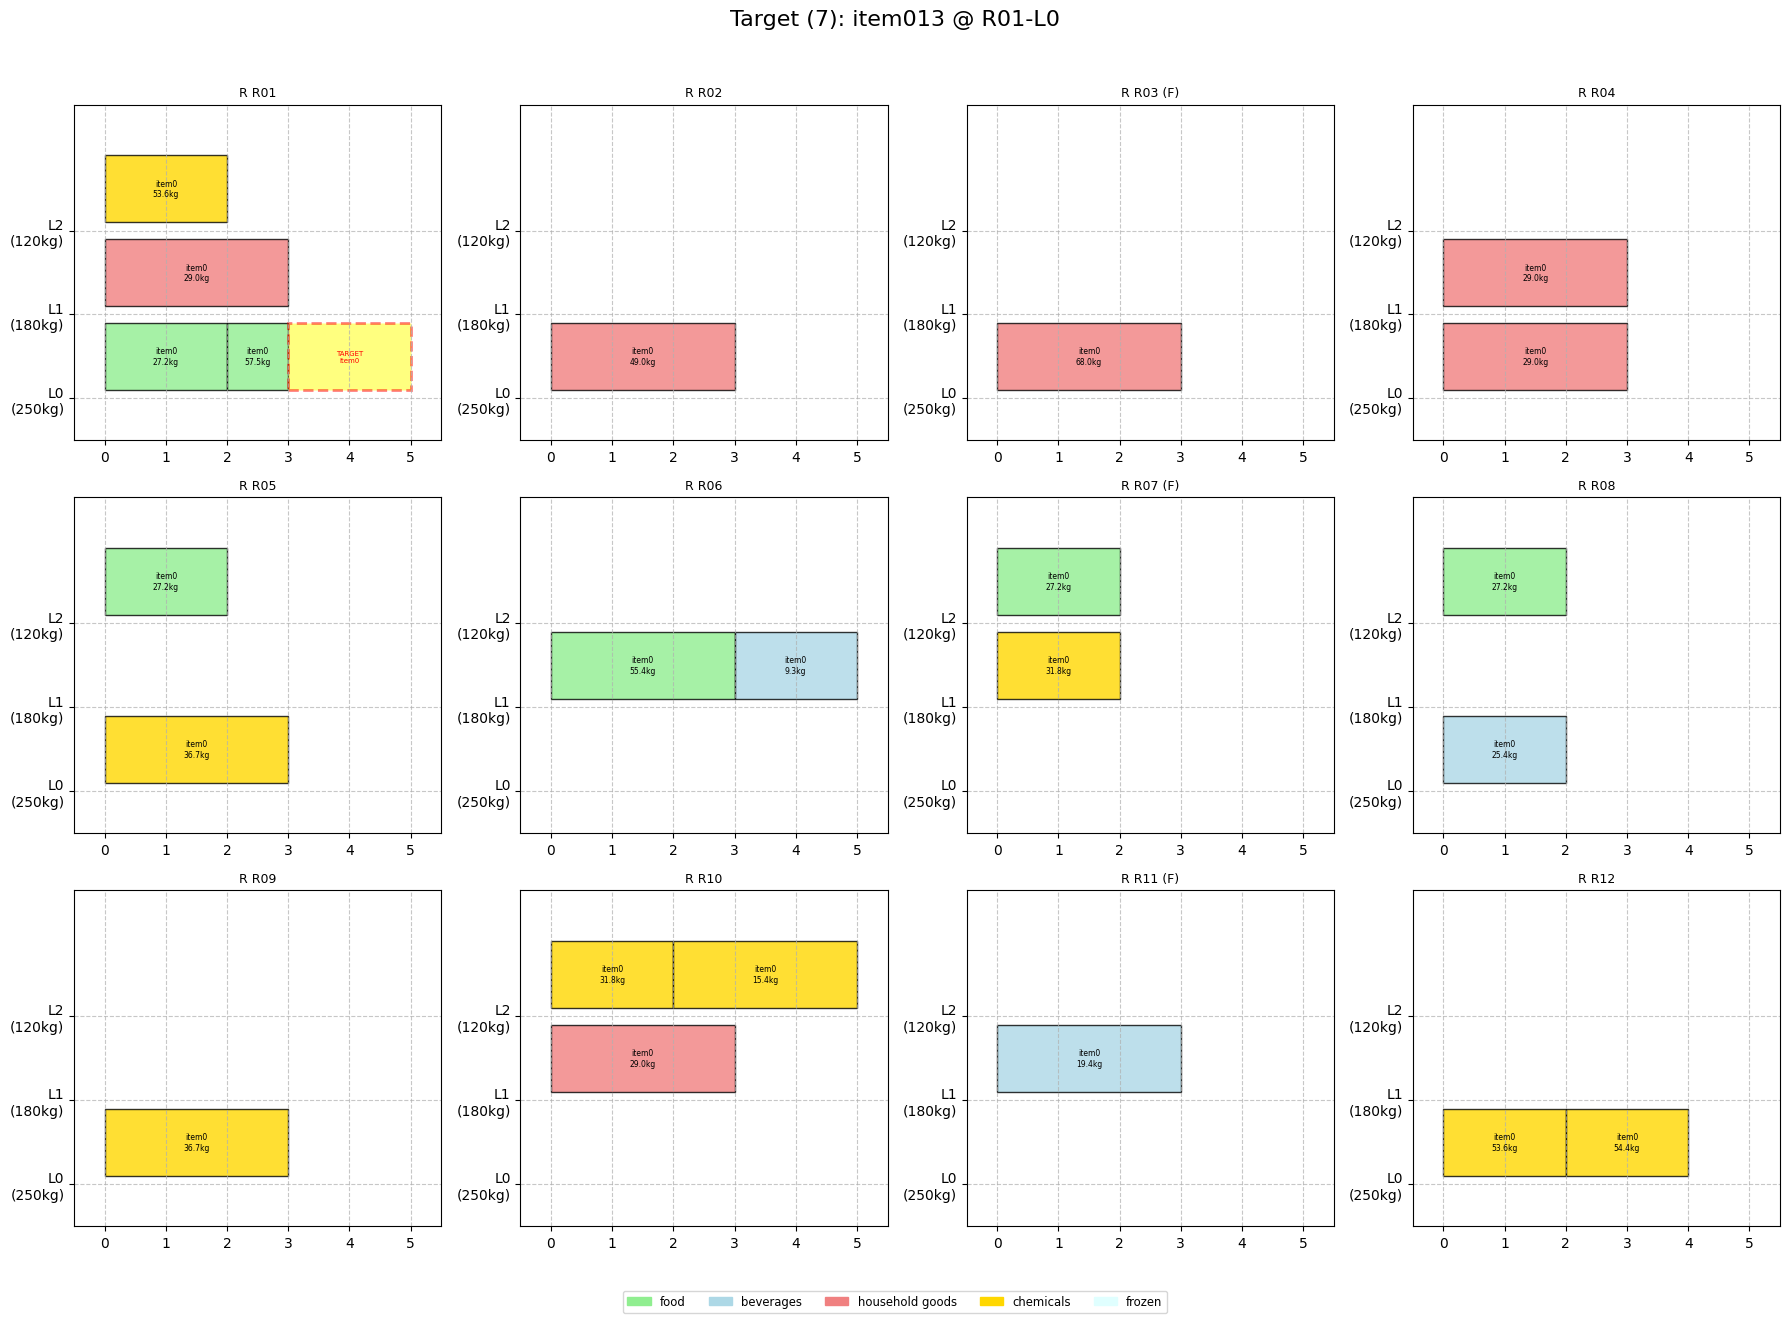


--- Placing item013 at ('R01', 0) ---
Successfully placed item013 in R01-L0.


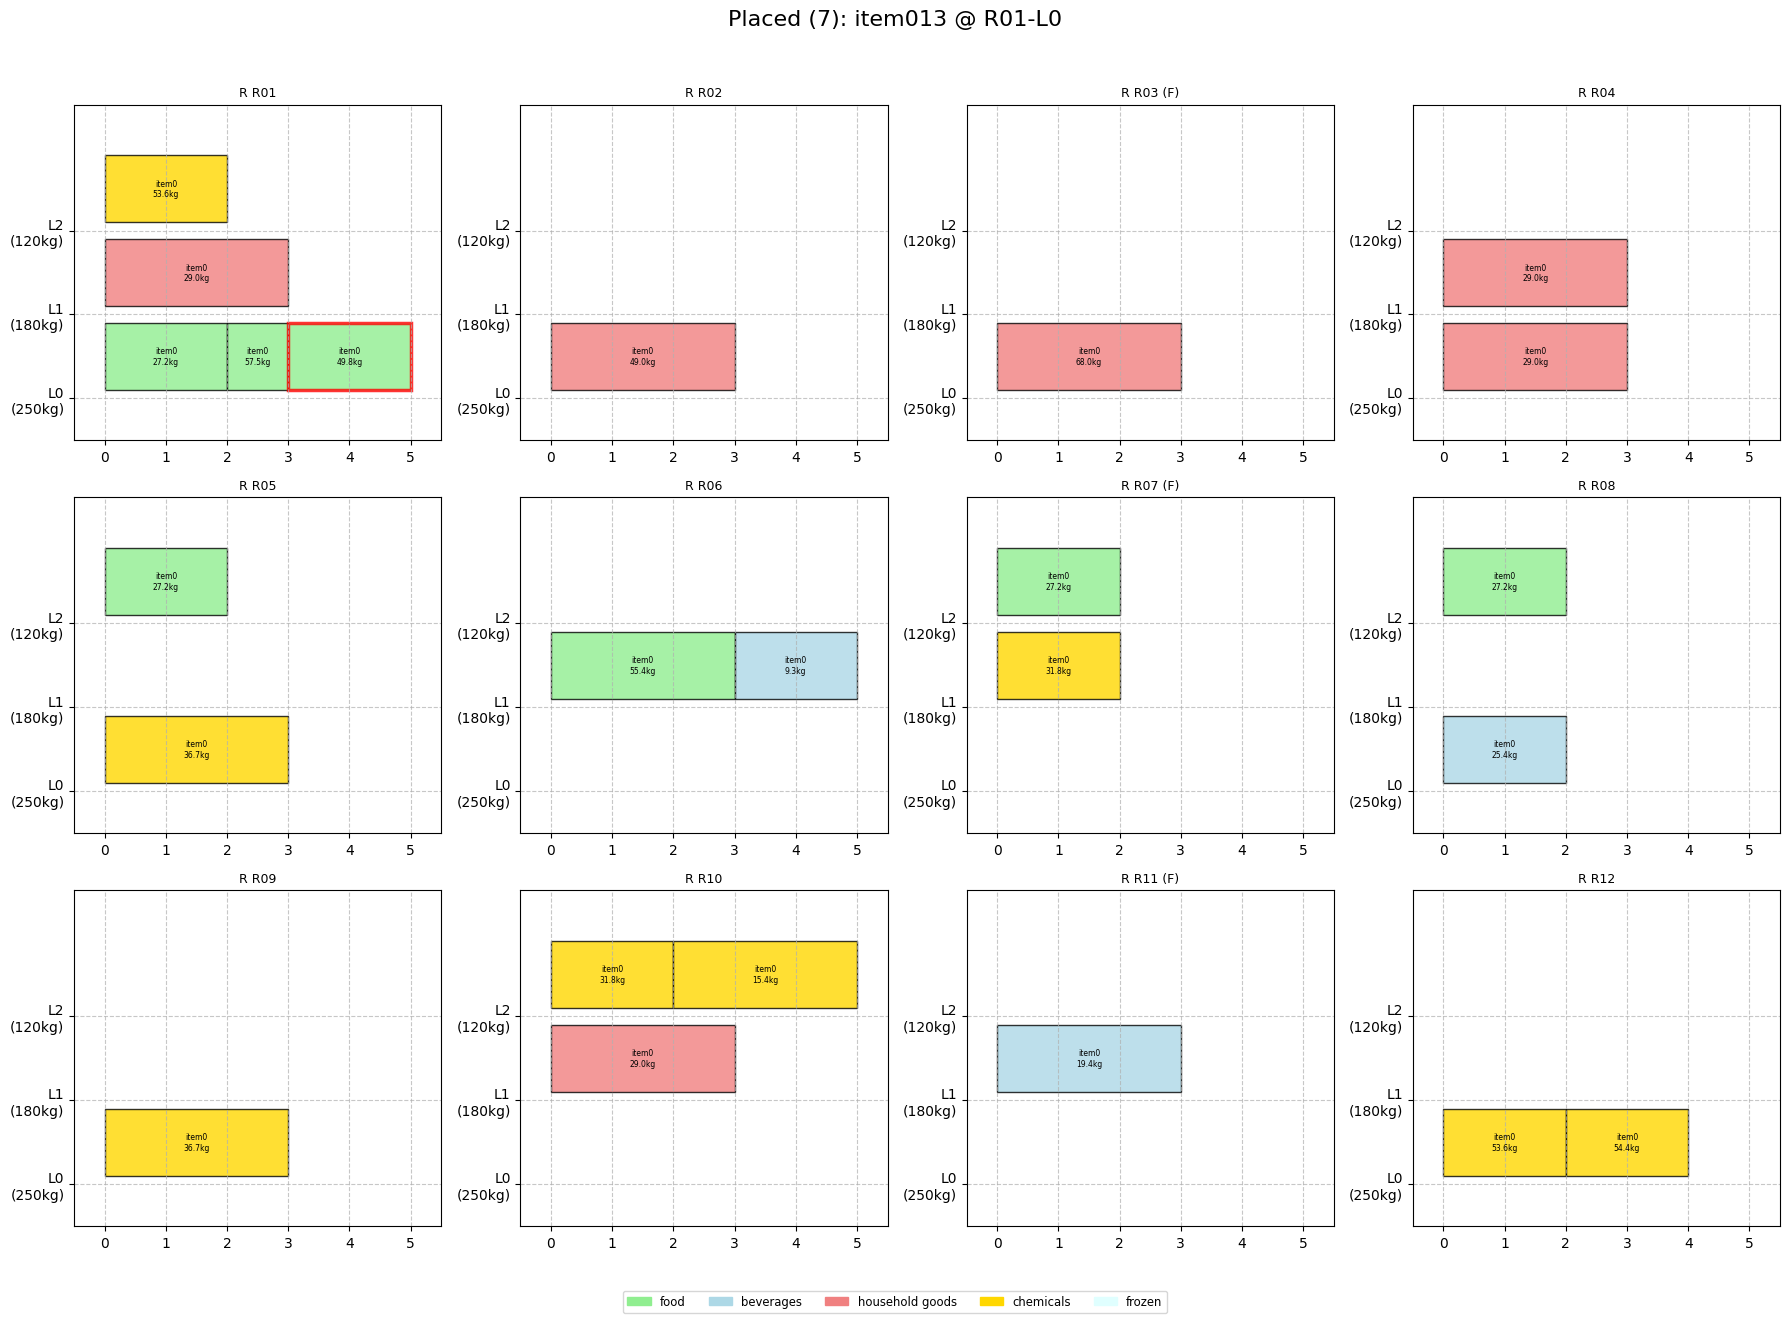



=============== ATTEMPTING INSERTION 8/10 FOR ITEM: item043 ===============

--- Evaluating Placements for: Item(item043,'Premium Chemicals Box',W:5.5,S:3,Fq:7.33) ---
------------------------------------------------------------------------------------------
Location     |   Score | Reason/Breakdown                                            
------------------------------------------------------------------------------------------
R01-L0       |    -inf | Slot:FAIL
R01-L1       |    -inf | Slot:FAIL
R01-L2       |    7.41 | Compatibility:2.00; Weight:0.20; Space:0.80; Distance:4.41
R02-L0       |    -inf | Slot:FAIL
R02-L1       |    5.67 | Compatibility:1.00; Distance:4.67
R02-L2       |    5.87 | Compatibility:1.00; Weight:0.20; Distance:4.67
R03-L0       |    -inf | Slot:FAIL
R03-L1       |   -4.00 | Frozen:-10.00; Compatibility:1.00; Distance:5.00
R03-L2       |   -3.80 | Frozen:-10.00; Compatibility:1.00; Weight:0.20; Distance:5.00
R04-L0       |    -inf | Slot:FAIL
R04-L1     

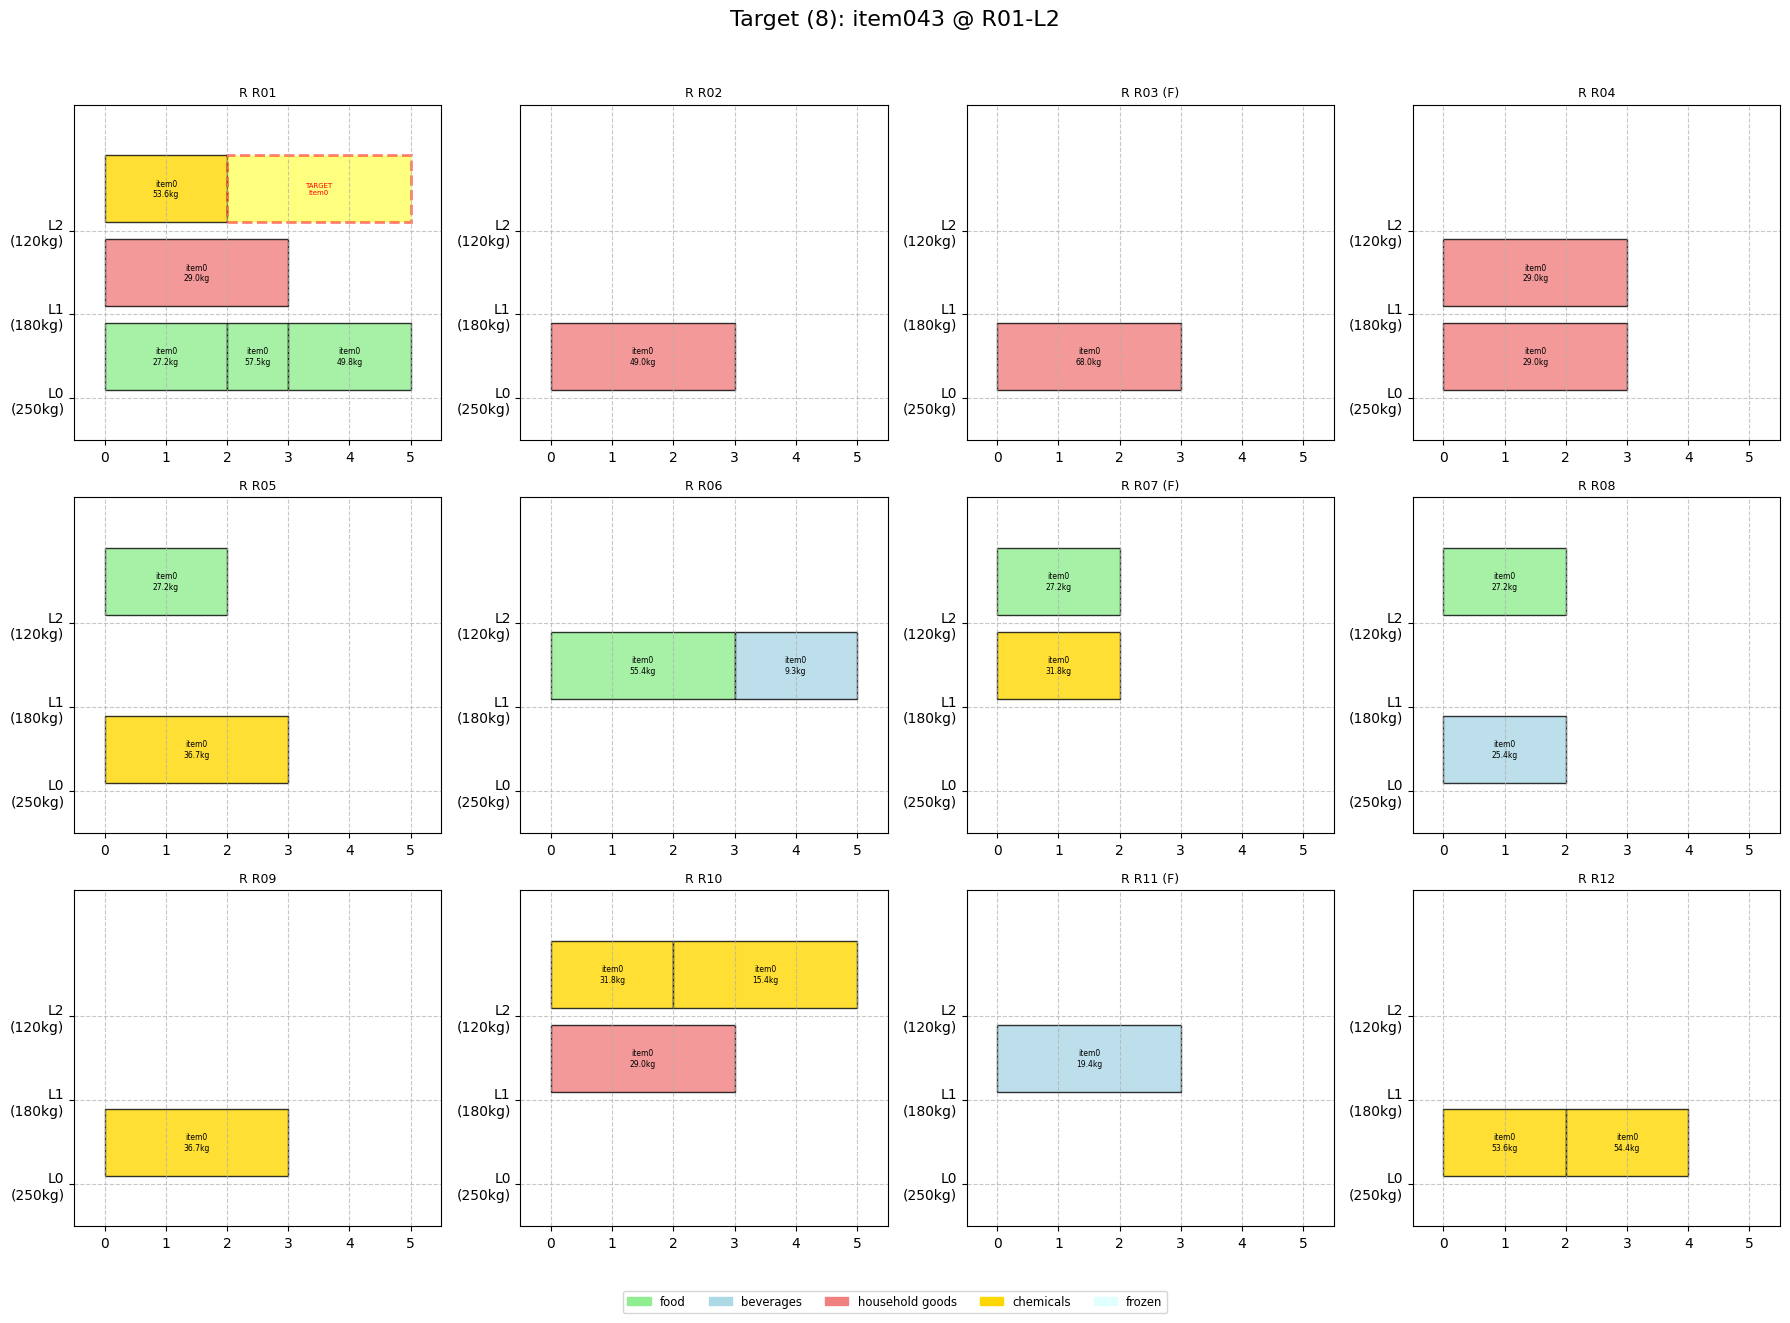


--- Placing item043 at ('R01', 2) ---
Successfully placed item043 in R01-L2.


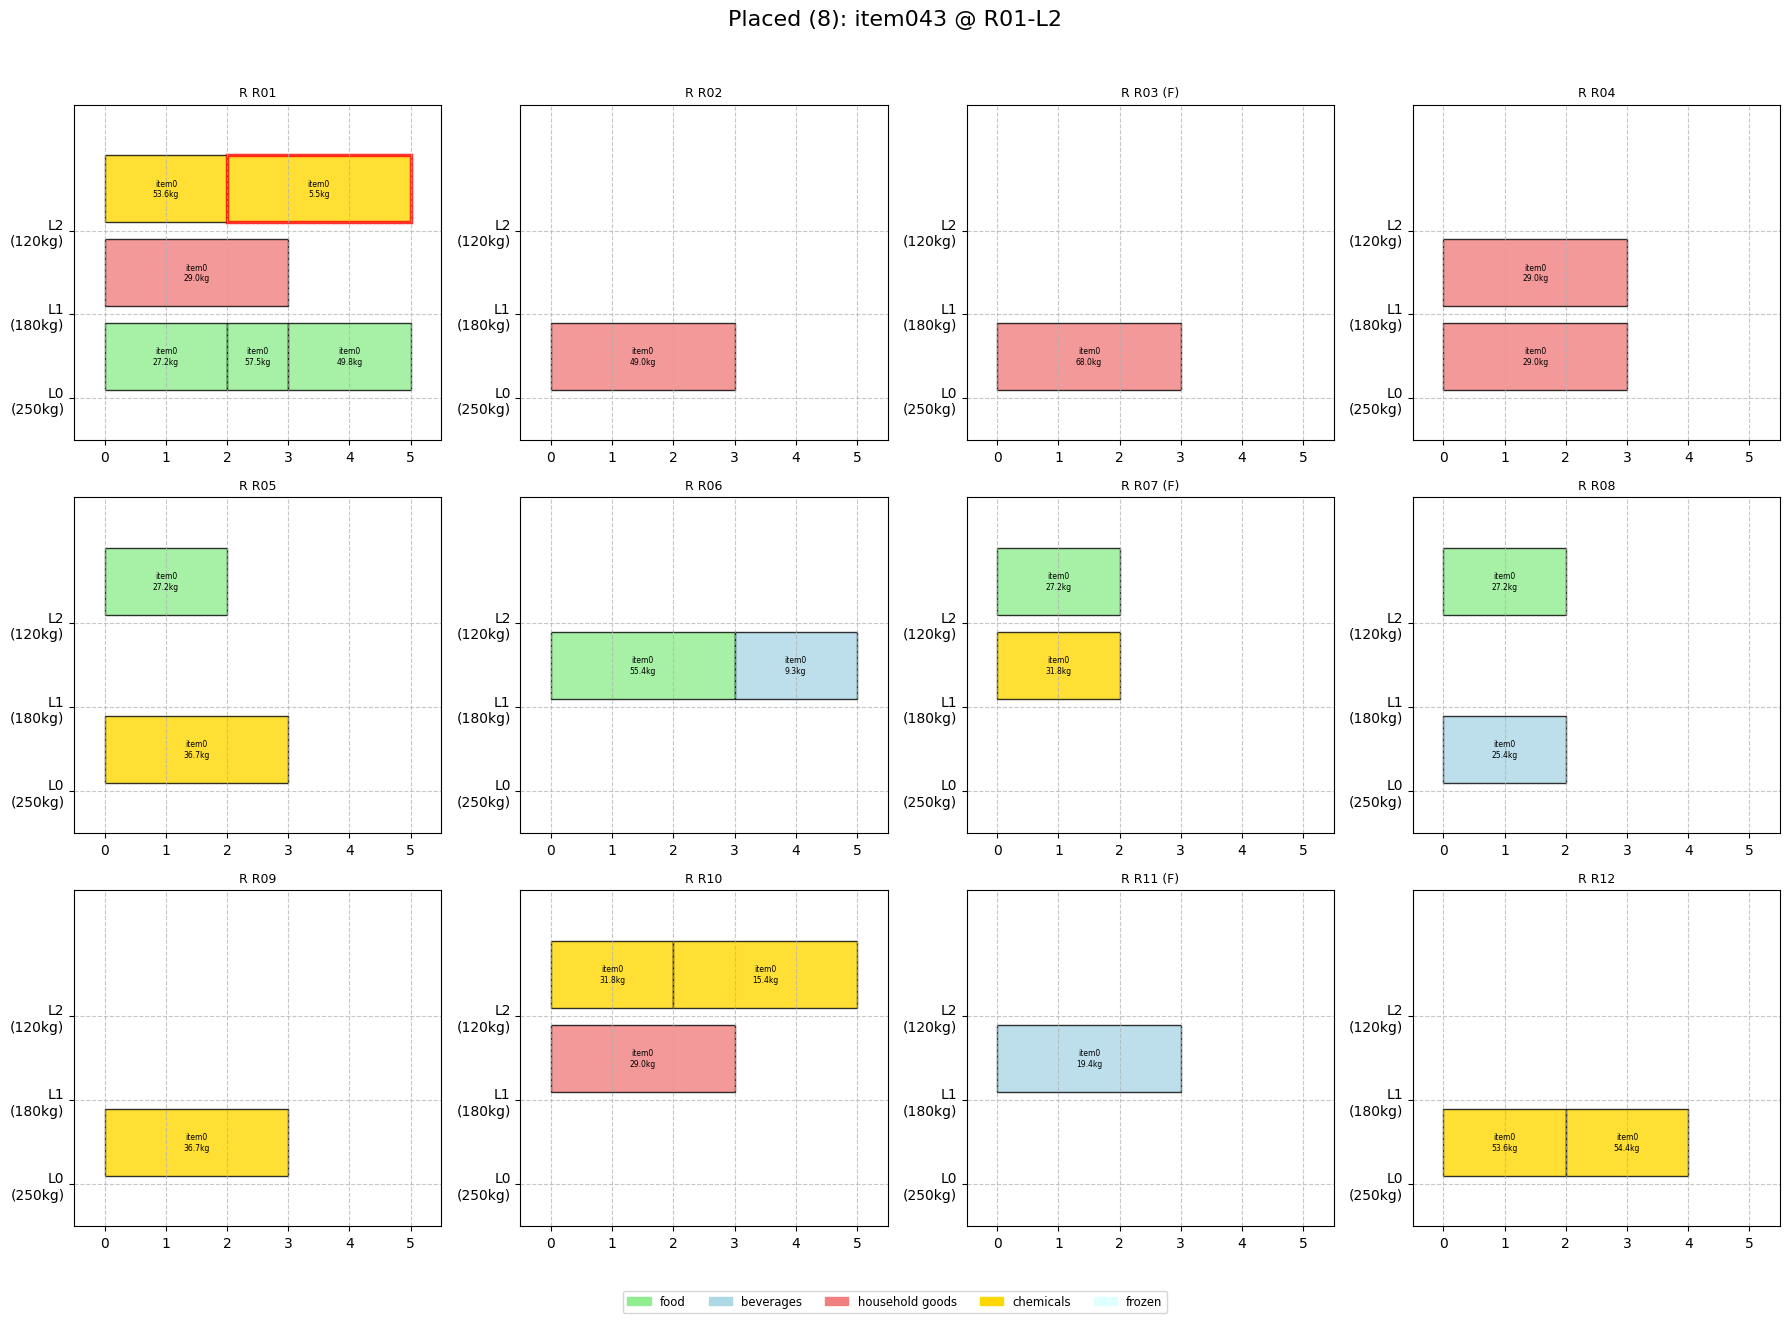



=============== ATTEMPTING INSERTION 9/10 FOR ITEM: item023 ===============

--- Evaluating Placements for: Item(item023,'Value Chemicals Pack',W:74.9,S:3,Fq:8.50) ---
------------------------------------------------------------------------------------------
Location     |   Score | Reason/Breakdown                                            
------------------------------------------------------------------------------------------
R01-L0       |    -inf | Slot:FAIL
R01-L1       |    -inf | Slot:FAIL
R01-L2       |    -inf | Slot:FAIL
R02-L0       |    -inf | Slot:FAIL
R02-L1       |    6.50 | Compatibility:1.00; Weight:0.50; Distance:5.00
R02-L2       |    5.00 | Compatibility:1.00; Weight:-1.00; Distance:5.00
R03-L0       |    -inf | Slot:FAIL
R03-L1       |   -3.50 | Frozen:-10.00; Compatibility:1.00; Weight:0.50; Distance:5.00
R03-L2       |   -5.00 | Frozen:-10.00; Compatibility:1.00; Weight:-1.00; Distance:5.00
R04-L0       |    -inf | Slot:FAIL
R04-L1       |    -inf | Slot:FA

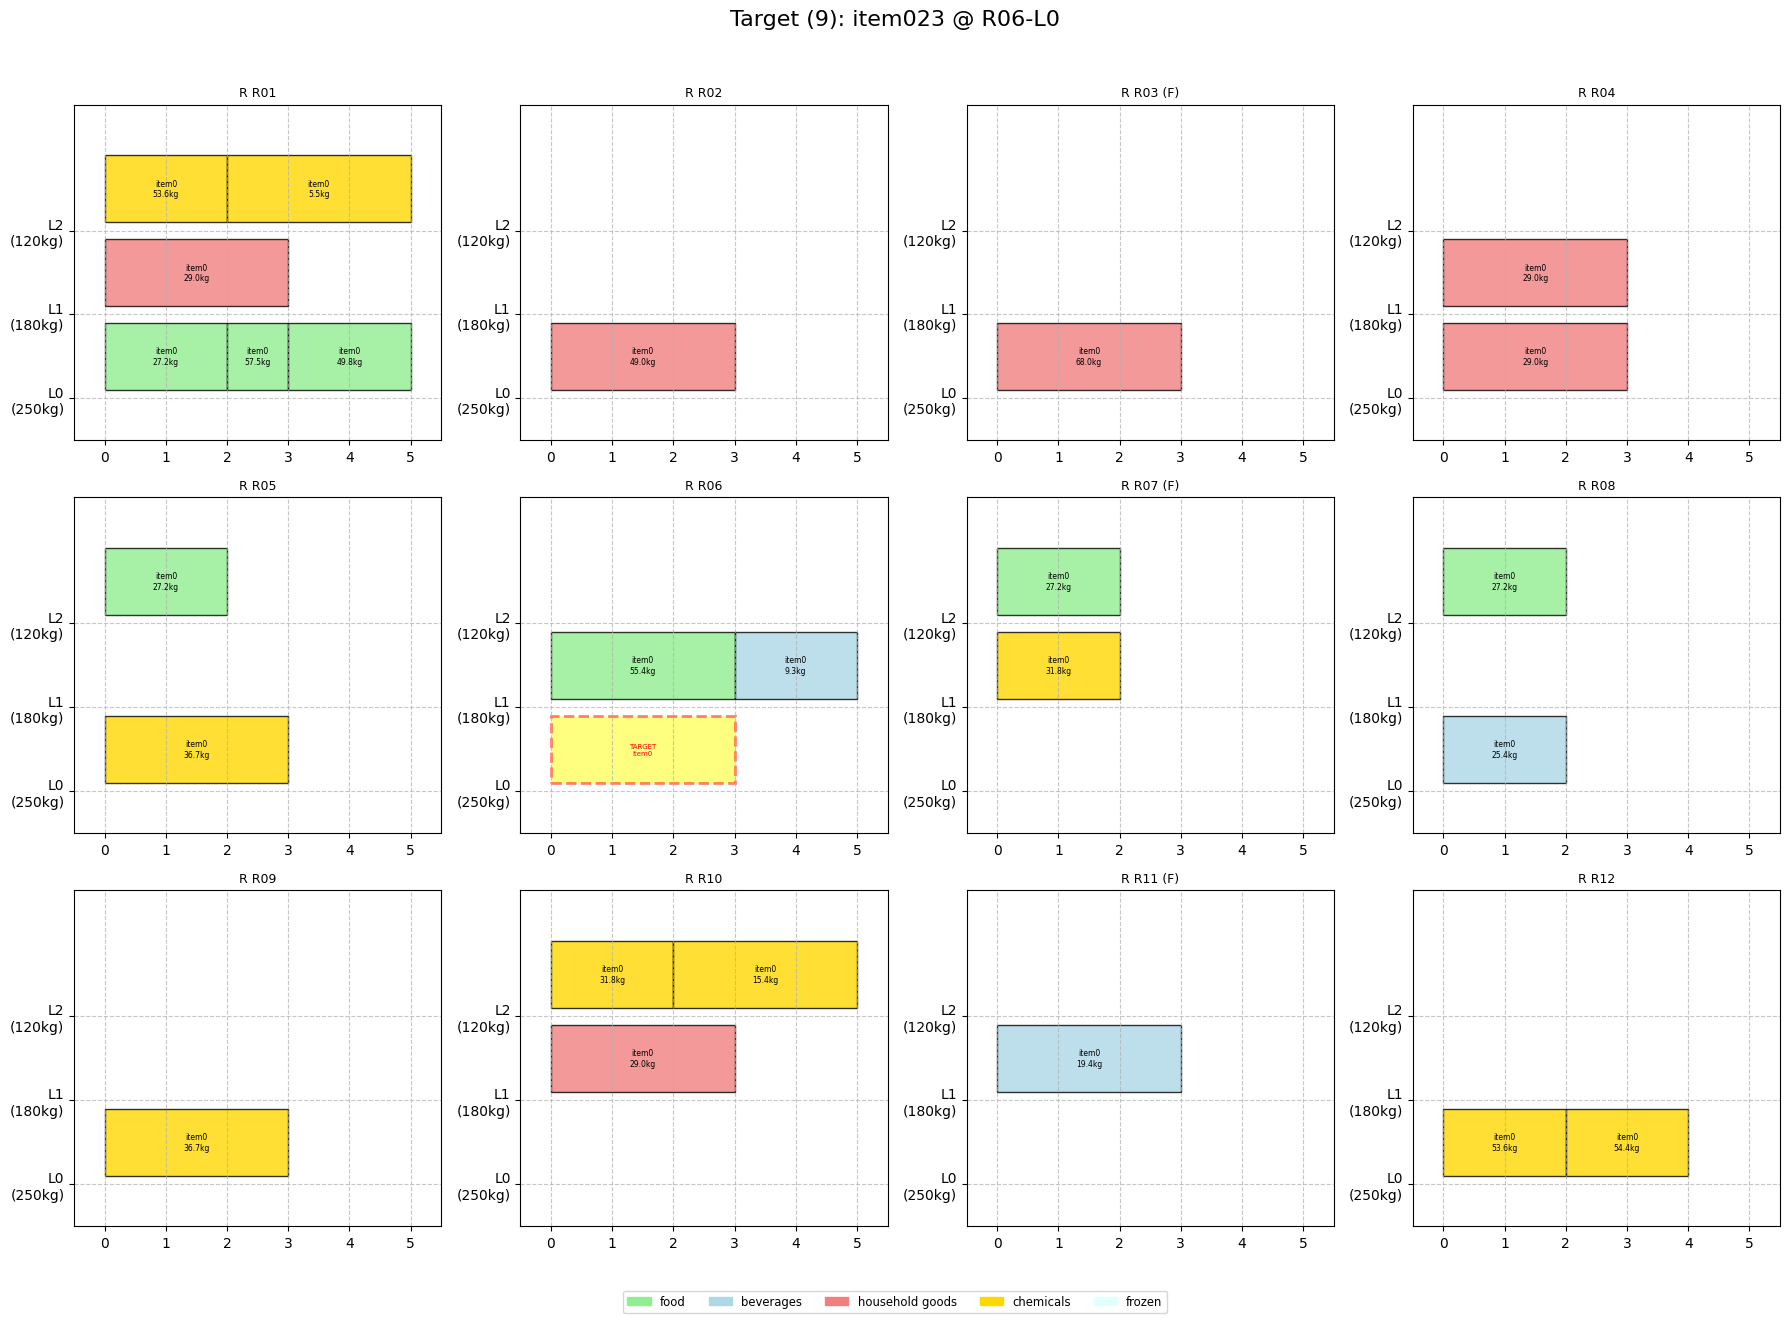


--- Placing item023 at ('R06', 0) ---
Successfully placed item023 in R06-L0.


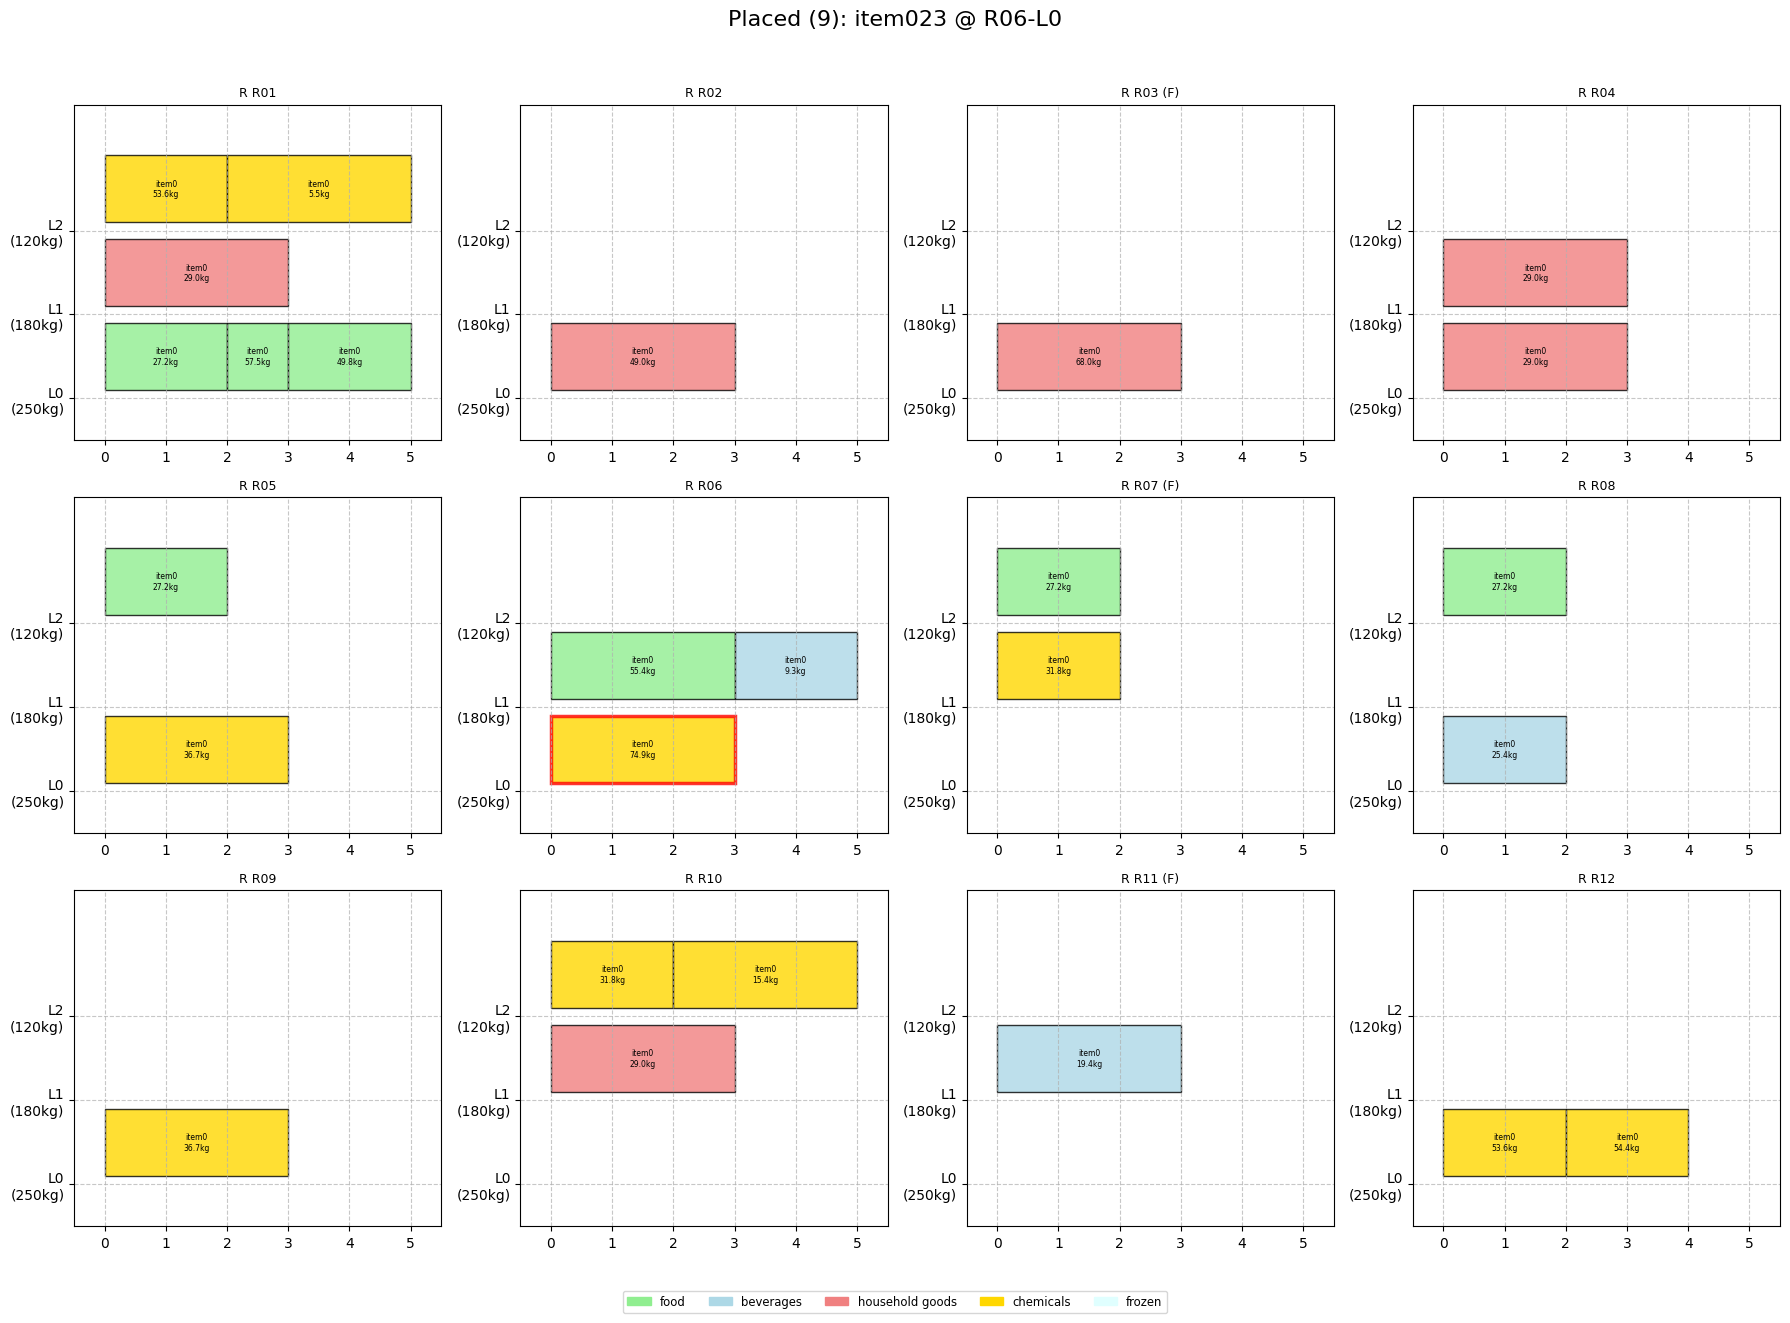



=============== ATTEMPTING INSERTION 10/10 FOR ITEM: item027 ===============

--- Evaluating Placements for: Item(item027,'Premium Food Pack',W:11.2,S:1,Fq:11.25) ---
------------------------------------------------------------------------------------------
Location     |   Score | Reason/Breakdown                                            
------------------------------------------------------------------------------------------
R01-L0       |    -inf | Slot:FAIL
R01-L1       |    5.70 | Compatibility:0.40; Space:0.30; Distance:5.00
R01-L2       |    -inf | Slot:FAIL
R02-L0       |    5.70 | Compatibility:0.40; Space:0.30; Distance:5.00
R02-L1       |    6.00 | Compatibility:1.00; Distance:5.00
R02-L2       |    6.20 | Compatibility:1.00; Weight:0.20; Distance:5.00
R03-L0       |    -inf | Frozen:FAIL
R03-L1       |   -4.00 | Frozen:-10.00; Compatibility:1.00; Distance:5.00
R03-L2       |   -3.80 | Frozen:-10.00; Compatibility:1.00; Weight:0.20; Distance:5.00
R04-L0       |    5.70

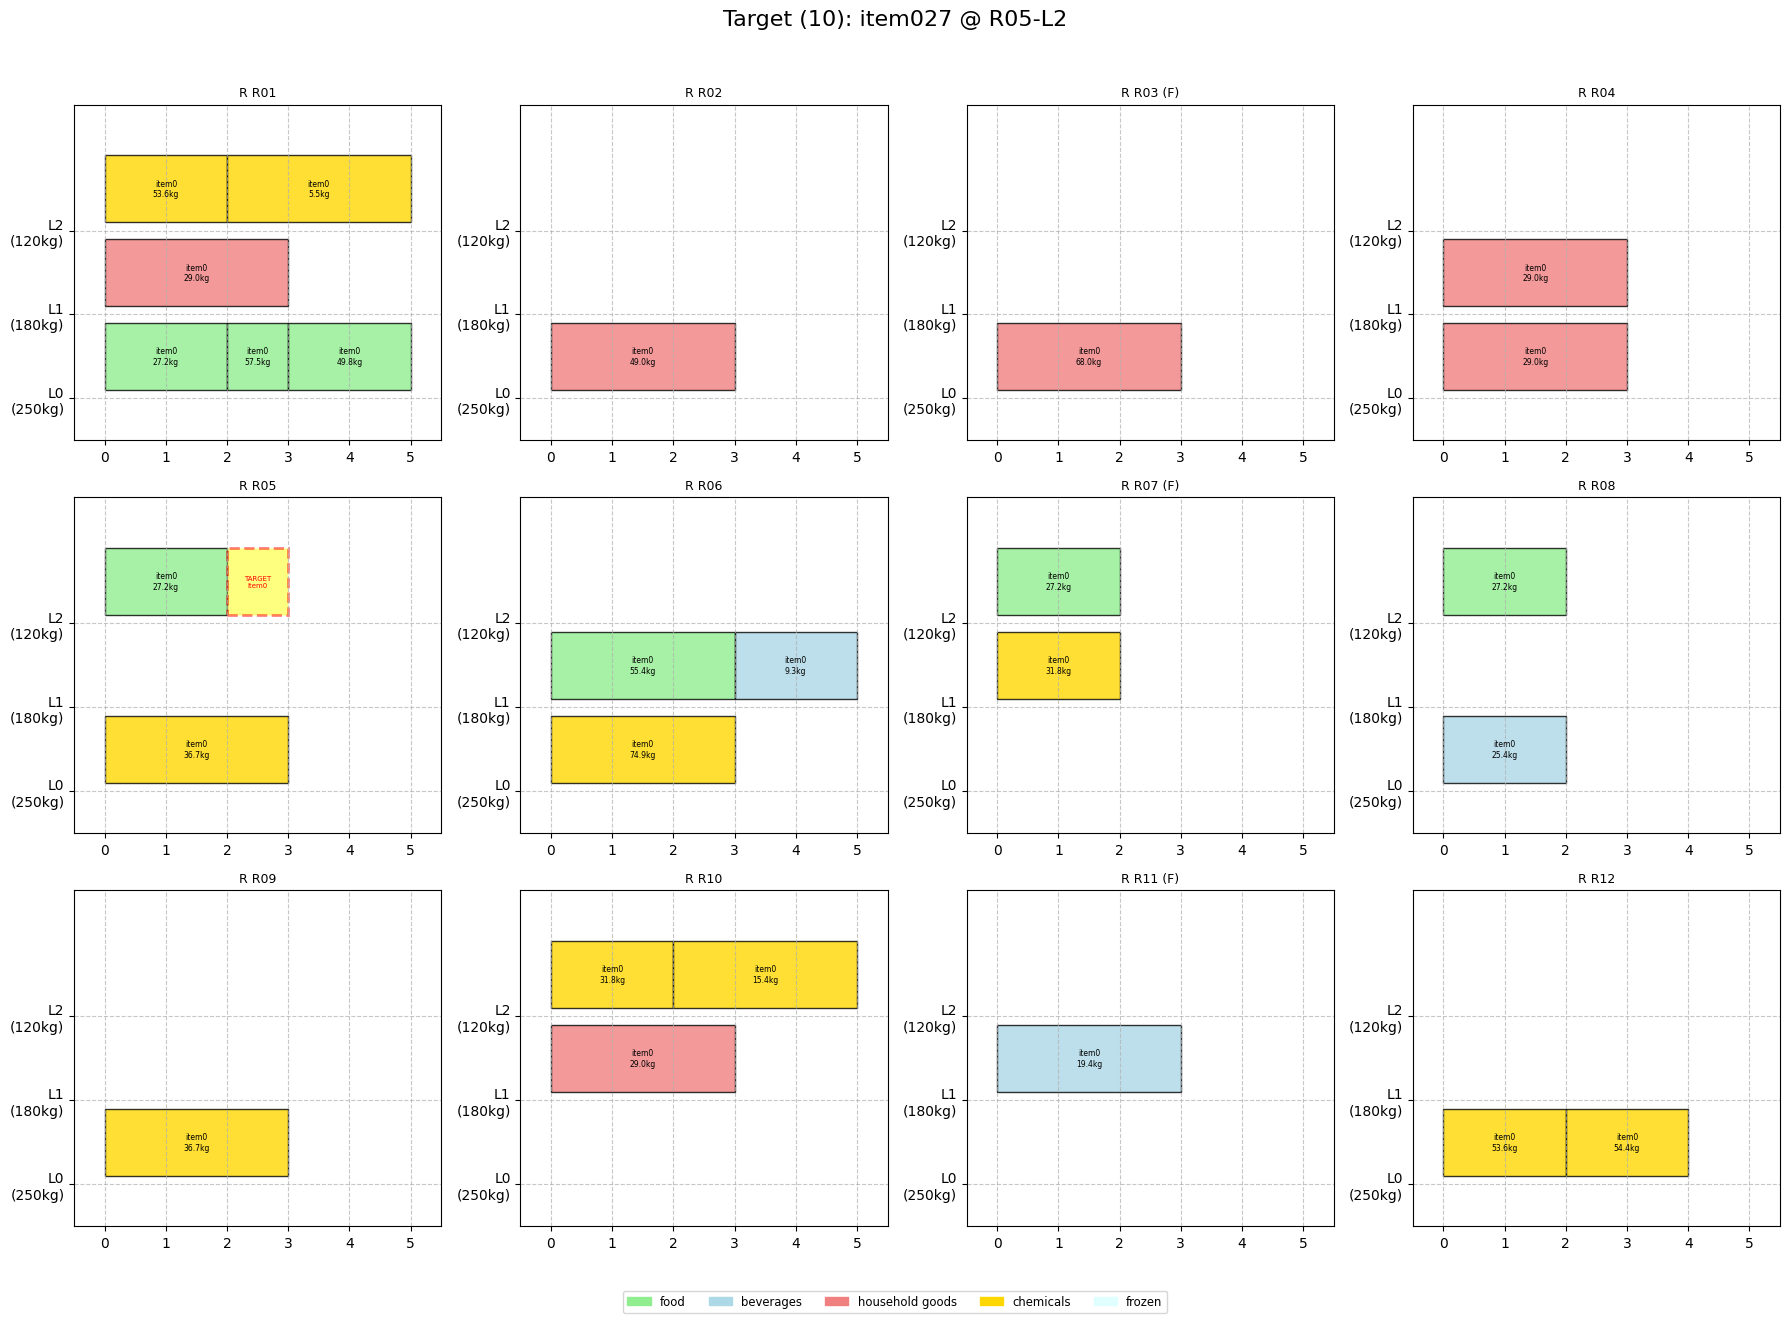


--- Placing item027 at ('R05', 2) ---
Successfully placed item027 in R05-L2.


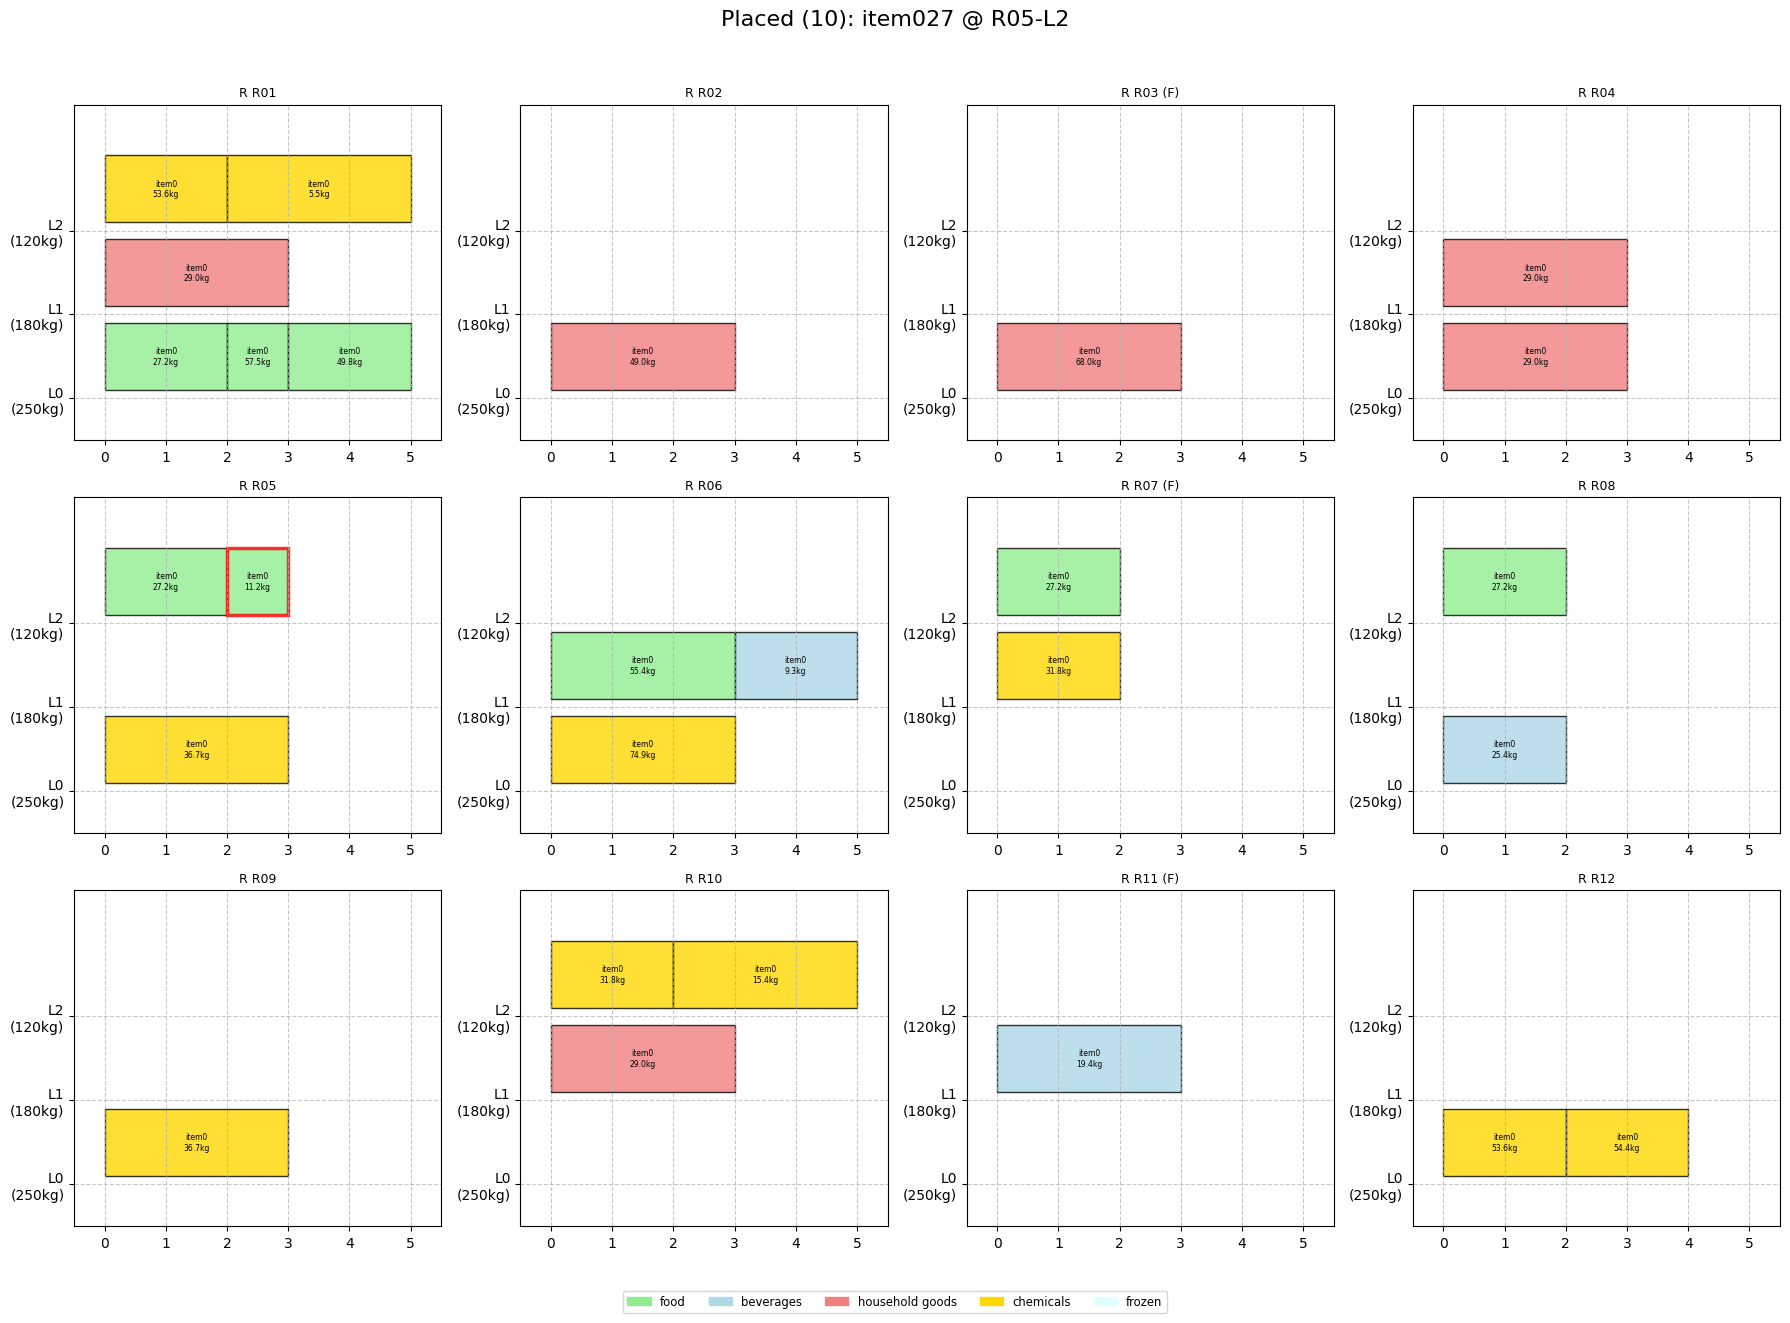


--- Final Warehouse State After All Attempts ---


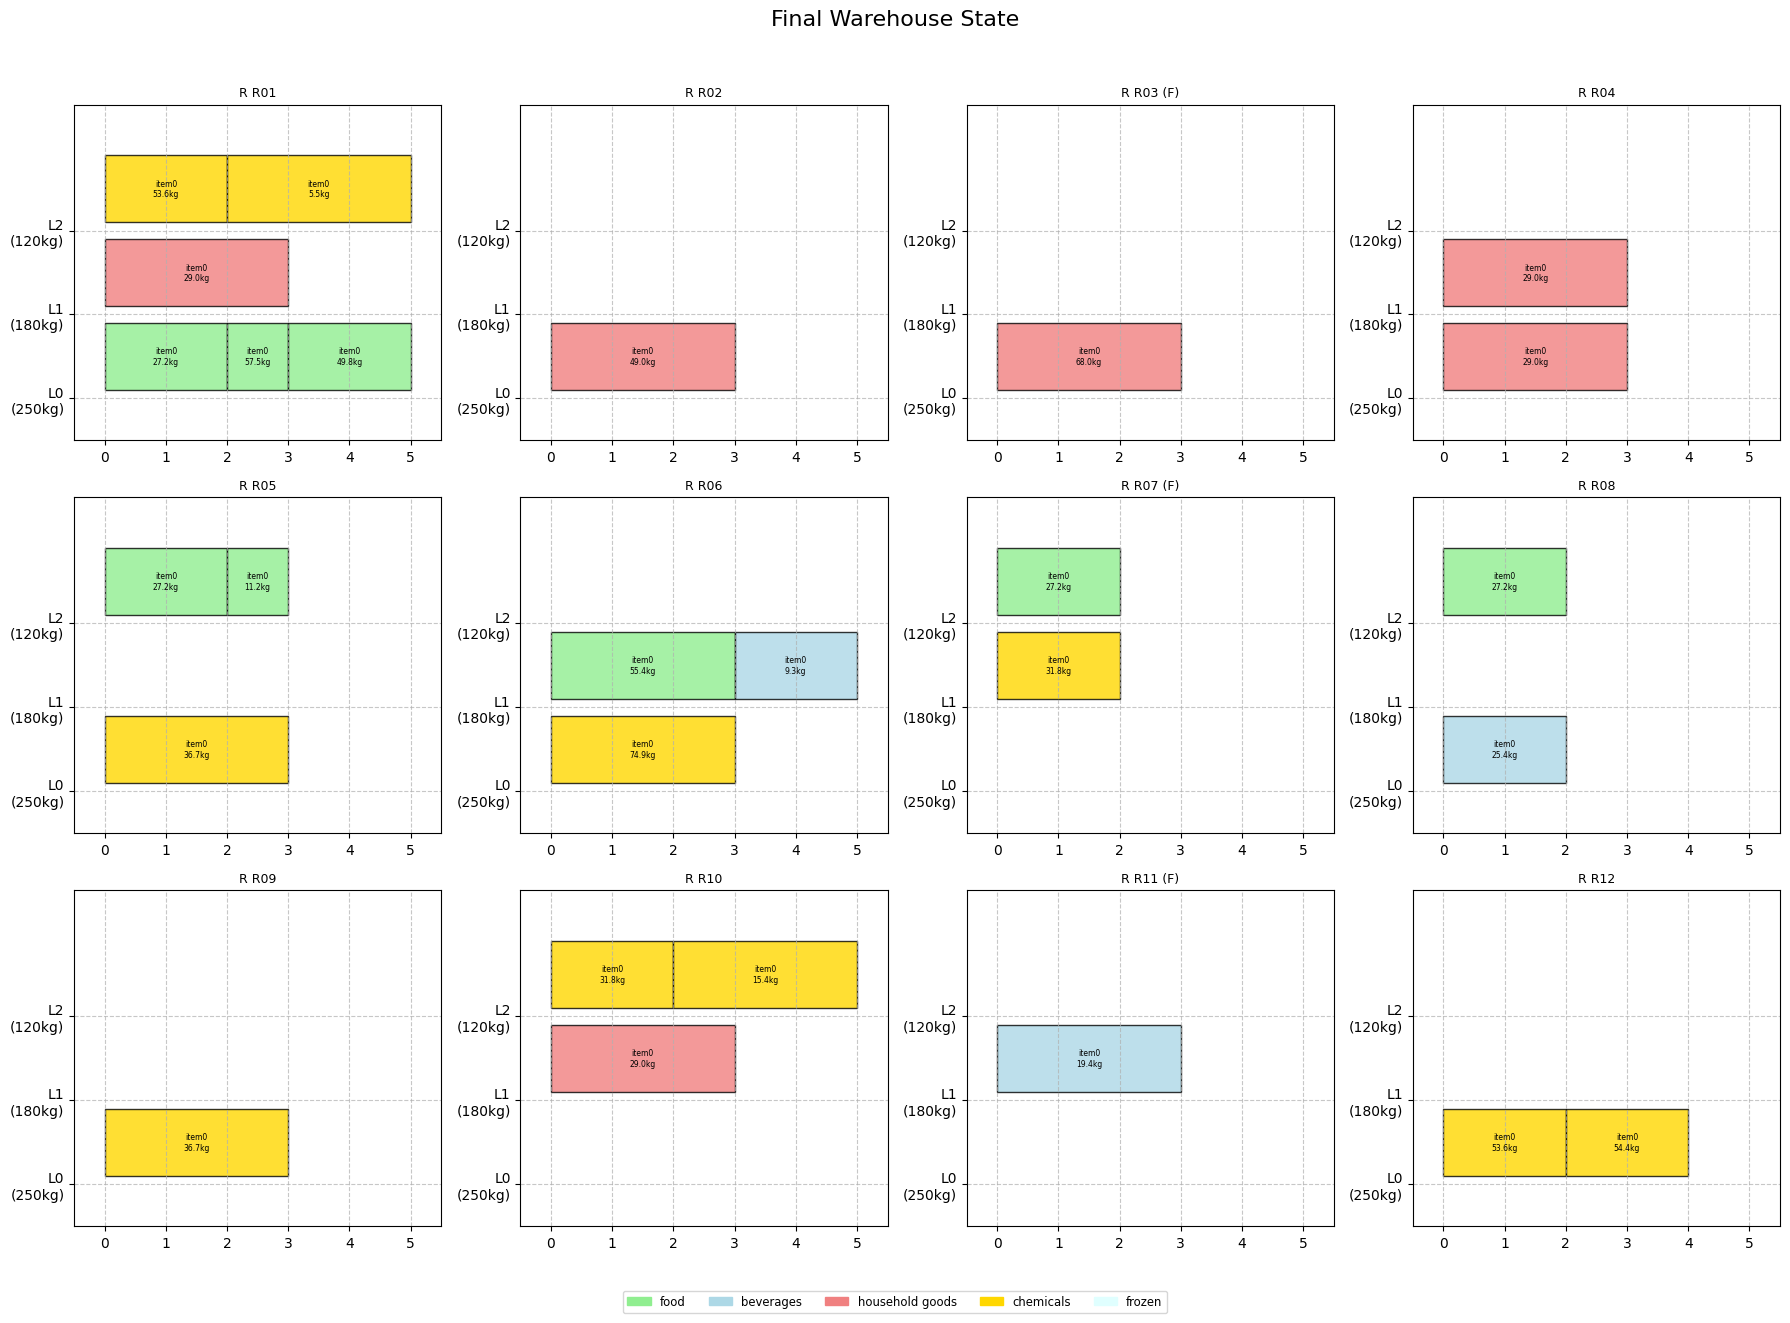

In [8]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import copy
import json
import csv
import random
import math
import pandas as pd

# --- CONFIGURATION & CONSTANTS ---
MAX_SLOTS_PER_SHELF = 5
SHELF_LEVELS = 3
HEAVY_ITEM_THRESHOLD = 20 # For weight placement heuristic (distinct from max shelf weight)

# Heuristic Weights - TUNE THESE!
DISTANCE_BASE_FACTOR = 0.1 # Base sensitivity to distance. Lower = more sensitive.
FREQUENCY_DISTANCE_MULTIPLIER = 5.0 # How much more sensitive high-frequency items are to distance.
MAX_DISTANCE_SCORE_CONTRIBUTION = 5.0 # Cap any distance related bonus/penalty

COMPATIBILITY_MATRIX = {
    'food':           {'food': 1.0, 'beverages': 0.8, 'household goods': 0.2, 'chemicals': 0.0, 'frozen': 0.1},
    'beverages':      {'food': 0.8, 'beverages': 1.0, 'household goods': 0.3, 'chemicals': 0.0, 'frozen': 0.1},
    'household goods':{'food': 0.2, 'beverages': 0.3, 'household goods': 1.0, 'chemicals': 0.1, 'frozen': 0.05},
    'chemicals':      {'food': 0.0, 'beverages': 0.0, 'household goods': 0.1, 'chemicals': 1.0, 'frozen': 0.0},
    'frozen':         {'food': 0.1, 'beverages': 0.1, 'household goods': 0.05, 'chemicals': 0.0, 'frozen': 1.0},
}
CATEGORY_COLORS = {
    'food': 'lightgreen', 'beverages': 'lightblue', 'household goods': 'lightcoral',
    'chemicals': 'gold', 'frozen': 'lightcyan', 'default': 'lightgrey'
}

# Globals to be loaded from facts.json
ENTRANCE_COORDS = None
FROZEN_ENTRANCE_COORDS = None
MAX_WEIGHT_PER_LEVEL = None # List: [w_L0, w_L1, w_L2]
SHELFS_MAX_HEIGHT = None    # List: [h_L0, h_L1, h_L2]

# --- DATA GENERATION FUNCTIONS ---
def generate_dummy_item_csv(filename="dummy_items.csv", num_items=30):
    categories = list(COMPATIBILITY_MATRIX.keys())
    items_data = []
    for i in range(num_items):
        item_id = f"item{str(i+1).zfill(3)}" # Simpler ID generation
        category = random.choice(categories)
        name = f"{random.choice(['Premium', 'Value', 'Eco'])} {category.capitalize()} {random.choice(['Pack', 'Unit', 'Box'])}"
        weight = round(random.uniform(1, 75), 1) # Increased max weight for testing shelf limits
        slots = random.randint(1, 3)
        retrieval_counter = random.randint(0, 100)
        insertion_counter = random.randint(1, 20) # Start at 1 to avoid div by zero for new items
        items_data.append([item_id, name, weight, category, slots, retrieval_counter, insertion_counter])

    with open(filename, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['id', 'name', 'weight', 'category', 'slots', 'retrieval_counter', 'insertion_counter'])
        writer.writerows(items_data)
    print(f"Generated {filename} with {len(items_data)} items (incl. counters).")

def generate_dummy_rack_layout_csv(filename="dummy_rack_layout.csv", rack_ids=None, item_ids_for_layout=None):
    # (Same as v4 - for brevity, not repeating the whole function. Ensure it works with the new item CSV format if needed for slot info)
    if rack_ids is None: rack_ids = [f"R{str(i+1).zfill(2)}" for i in range(8)]
    if item_ids_for_layout is None:
        try: temp_df = pd.read_csv("dummy_items.csv"); item_ids_for_layout = list(temp_df['id'])
        except: item_ids_for_layout = [f"item{str(i+1).zfill(3)}" for i in range(30)]
    layout_data = []; item_slots_map = {}
    try: df_items = pd.read_csv("dummy_items.csv"); item_slots_map = dict(zip(df_items['id'], df_items['slots']))
    except: pass
    for rack_id in rack_ids:
        for shelf_level in range(SHELF_LEVELS):
            num_items_on_shelf = random.randint(0,1) # Make layout more sparse
            current_slots, items_placed = 0,0
            shuffled_items = random.sample(item_ids_for_layout, len(item_ids_for_layout))
            for item_id in shuffled_items:
                if items_placed >= num_items_on_shelf: break
                slots_needed = item_slots_map.get(item_id, random.randint(1,2))
                if current_slots + slots_needed <= MAX_SLOTS_PER_SHELF:
                    layout_data.append([rack_id, shelf_level, item_id])
                    current_slots += slots_needed; items_placed +=1
    with open(filename, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile); writer.writerow(['rack_id', 'shelf_level', 'item_id']); writer.writerows(layout_data)
    print(f"Generated {filename} with initial layout.")

# --- HELPER FUNCTIONS ---
def euclidean_distance(p1, p2):
    if p1 is None or p2 is None: return float('inf') # Cannot calculate distance
    return math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

# --- CLASSES ---
class Item:
    def __init__(self, item_id, name, weight, category, slots, retrieval_counter=0, insertion_counter=1):
        self.id, self.name, self.weight, self.category, self.slots_required = item_id, name, weight, category, slots
        self.retrieval_counter = int(retrieval_counter)
        self.insertion_counter = max(1, int(insertion_counter)) # Ensure at least 1
        self.is_frozen = (category == 'frozen')

    @property
    def frequency_metric(self):
        # Higher value means more frequently retrieved relative to insertions
        return self.retrieval_counter / self.insertion_counter

    def __repr__(self):
        return f"Item({self.id},'{self.name}',W:{self.weight},S:{self.slots_required},Fq:{self.frequency_metric:.2f})"

class Shelf:
    def __init__(self, level, max_slots=MAX_SLOTS_PER_SHELF):
        self.level, self.max_slots = level, max_slots
        self.items = []
        self.occupied_slots = 0
        self.current_weight = 0.0 # NEW: Track current weight on shelf

    @property
    def available_slots(self): return self.max_slots - self.occupied_slots

    def can_add_item(self, item: Item, max_weight_for_level: float): # NEW: takes max_weight
        if self.available_slots < item.slots_required:
            return False, "slot_capacity"
        if self.current_weight + item.weight > max_weight_for_level:
            return False, "weight_limit"
        # Conceptual height check (if item_height and SHELFS_MAX_HEIGHT[self.level] were used)
        # if item.height > SHELFS_MAX_HEIGHT[self.level]: return False, "height_limit"
        return True, "ok"

    def add_item(self, item: Item, max_weight_for_level: float):
        can_add_flag, reason = self.can_add_item(item, max_weight_for_level)
        if can_add_flag:
            self.items.append(item)
            self.occupied_slots += item.slots_required
            self.current_weight += item.weight # NEW: Update weight
            return True
        return False

    def __repr__(self):
        return f"Sh(L{self.level},{self.occupied_slots}/{self.max_slots}s,{self.current_weight:.1f}kg)"

class Rack: # Mostly same, passes max_weight_for_level down
    def __init__(self, rack_id, is_frozen=False, center_coords=None):
        self.id, self.is_frozen, self.center_coords = rack_id, is_frozen, tuple(center_coords) if center_coords else (0,0)
        self.shelves = [Shelf(level=i) for i in range(SHELF_LEVELS)]
    def get_shelf(self, level): return self.shelves[level] if 0 <= level < SHELF_LEVELS else None
    def __repr__(self): return f"Rk({self.id},F:{self.is_frozen},C:{self.center_coords})"


class Warehouse:
    def __init__(self, facts_file="facts.json"):
        self.racks, self._item_db_dict = {}, {}
        self.entrance_coords, self.frozen_entrance_coords = None, None
        self.max_weight_per_level, self.shelfs_max_height = None, None
        self._load_facts(facts_file)

    def _load_facts(self, facts_file):
        global ENTRANCE_COORDS, FROZEN_ENTRANCE_COORDS, MAX_WEIGHT_PER_LEVEL, SHELFS_MAX_HEIGHT
        try:
            with open(facts_file, 'r') as f: facts = json.load(f)
            self.entrance_coords = ENTRANCE_COORDS = tuple(facts["entrance_coords"])
            self.frozen_entrance_coords = FROZEN_ENTRANCE_COORDS = tuple(facts["frozen_entrance_coords"])
            self.max_weight_per_level = MAX_WEIGHT_PER_LEVEL = facts["max_weight_per_level"]
            self.shelfs_max_height = SHELFS_MAX_HEIGHT = facts["shelfs_max_height"]
            for rack_id, info in facts.get("racks_info", {}).items():
                self.racks[rack_id] = Rack(rack_id, info.get("is_frozen",False), info.get("center_coords"))
            print(f"Loaded facts: Entrances, {len(self.racks)} racks, weight/height limits.")
        except Exception as e: print(f"FATAL Error loading facts '{facts_file}': {e}. Cannot continue without facts.") ; exit()


    def load_items_from_csv(self, items_csv_file="dummy_items.csv"):
        try:
            df = pd.read_csv(items_csv_file)
            for _, row in df.iterrows():
                self._item_db_dict[row['id']] = {
                    'name':row['name'],'weight':float(row['weight']), 'category':row['category'],
                    'slots':int(row['slots']), 'retrieval_counter':int(row['retrieval_counter']),
                    'insertion_counter':int(row['insertion_counter'])
                }
            print(f"Loaded {len(self._item_db_dict)} items from {items_csv_file}.")
        except Exception as e: print(f"Error loading items CSV '{items_csv_file}': {e}")

    def _get_item_details(self, item_id_str) -> Item | None:
        details = self._item_db_dict.get(item_id_str)
        if details: return Item(item_id_str, **details) # Unpack dict to Item constructor
        return None

    def populate_layout_from_csv(self, layout_csv_file="dummy_rack_layout.csv"):
        # Ensure MAX_WEIGHT_PER_LEVEL is loaded before calling this
        if not self.max_weight_per_level:
            print("Cannot populate layout: MAX_WEIGHT_PER_LEVEL not loaded from facts.")
            return
        try:
            df = pd.read_csv(layout_csv_file); items_added = 0
            for _, row in df.iterrows():
                rack_id, shelf_level, item_id = row['rack_id'], int(row['shelf_level']), row['item_id']
                if rack_id in self.racks:
                    rack_obj = self.racks[rack_id]
                    shelf_obj = rack_obj.get_shelf(shelf_level)
                    if shelf_obj:
                        item_obj = self._get_item_details(item_id)
                        if item_obj:
                            valid_frozen = not (item_obj.is_frozen and not rack_obj.is_frozen) and \
                                           not (not item_obj.is_frozen and rack_obj.is_frozen and shelf_obj.items)
                            if valid_frozen and shelf_obj.add_item(item_obj, self.max_weight_per_level[shelf_level]):
                                items_added += 1
                            # else: print(f"Layout: Cannot add {item_id} to {rack_id}-L{shelf_level} due to constraints.") # Optional detailed log
            print(f"Populated layout from {layout_csv_file} with {items_added} items.")
        except Exception as e: print(f"Error populating layout CSV '{layout_csv_file}': {e}")


    def evaluate_placement(self, item_to_place: Item, rack: Rack, shelf: Shelf):
        score_breakdown = {
            "base": 0.0, "slot_capacity_penalty": 0.0, "shelf_weight_limit_penalty": 0.0,
            "frozen_penalty": 0.0, "compatibility": 0.0, "weight_item_placement": 0.0,
            "space_utilization": 0.0, "distance_freq_bonus": 0.0
        }
        current_score_contrib = 0

        # Hard Constraints
        can_add_flag, reason = shelf.can_add_item(item_to_place, self.max_weight_per_level[shelf.level])
        if not can_add_flag:
            if reason == "slot_capacity": score_breakdown["slot_capacity_penalty"] = -float('inf')
            elif reason == "weight_limit": score_breakdown["shelf_weight_limit_penalty"] = -float('inf')
            return -float('inf'), score_breakdown

        if item_to_place.is_frozen and not rack.is_frozen:
            score_breakdown["frozen_penalty"] = -float('inf'); return -float('inf'), score_breakdown
        if not item_to_place.is_frozen and rack.is_frozen and shelf.items:
            score_breakdown["frozen_penalty"] = -float('inf'); return -float('inf'), score_breakdown
        elif not item_to_place.is_frozen and rack.is_frozen and not shelf.items:
             score_breakdown["frozen_penalty"] = -10.0 # Heavier penalty for NF in empty F rack

        # Soft Preferences
        # 1. Category Compatibility
        cat_comp_score = sum(COMPATIBILITY_MATRIX.get(item_to_place.category,{}).get(ex.category,0.0) for ex in shelf.items)
        cat_comp_score = (cat_comp_score/len(shelf.items))*2.0 if shelf.items else 1.0 # x2 if existing, base 1 if empty
        score_breakdown["compatibility"] = cat_comp_score; current_score_contrib += cat_comp_score

        # 2. Weight Item Placement (Heavy item on lower shelf heuristic)
        weight_item_score = 0
        if item_to_place.weight > HEAVY_ITEM_THRESHOLD:
            if shelf.level == 0: weight_item_score = 1.5
            elif shelf.level == 1: weight_item_score = 0.5
            else: weight_item_score = -1.0
        else:
            if shelf.level == 2: weight_item_score = 0.2
        score_breakdown["weight_item_placement"] = weight_item_score; current_score_contrib += weight_item_score
        
        # 3. Space Utilization
        new_occ_ratio = (shelf.occupied_slots + item_to_place.slots_required) / shelf.max_slots
        space_util_score = 0.3 if new_occ_ratio > 0.75 else 0
        if new_occ_ratio == 1.0: space_util_score += 0.5 # Bonus for perfect fill
        score_breakdown["space_utilization"] = space_util_score; current_score_contrib += space_util_score
        
        # 4. Distance & Frequency Bonus
        target_entrance = self.frozen_entrance_coords if rack.is_frozen else self.entrance_coords
        dist_freq_score = 0
        if target_entrance and rack.center_coords != (0,0):
            dist = euclidean_distance(rack.center_coords, target_entrance)
            dist = max(dist, 0.1) # Min distance to avoid huge scores / div by zero
            
            # Base distance score (closer is better)
            base_dist_score = (1 / dist) * (1 / DISTANCE_BASE_FACTOR)
            
            # Frequency multiplier
            # item_freq_metric = 0 -> normal distance sensitivity
            # item_freq_metric = 1 (ret=ins) -> 1 + 1*FM = (1+FM) times base_dist_score
            # item_freq_metric = 10 (ret >> ins) -> 1 + 10*FM = (1+10*FM) times base_dist_score
            freq_multiplier = 1.0 + (item_to_place.frequency_metric * FREQUENCY_DISTANCE_MULTIPLIER)
            dist_freq_score = base_dist_score * freq_multiplier
            
            dist_freq_score = min(dist_freq_score, MAX_DISTANCE_SCORE_CONTRIBUTION) # Cap total contribution
            # Can also be negative if dist is large and base_factor makes (1/dist) small.
            # If dist_freq_score is intended as pure bonus, ensure it's positive or handle negative as penalty.
            # Current formula: closer = smaller dist = larger (1/dist) = larger bonus.
        score_breakdown["distance_freq_bonus"] = dist_freq_score; current_score_contrib += dist_freq_score
        
        final_score = score_breakdown["base"] + \
                      (score_breakdown["frozen_penalty"] if score_breakdown["frozen_penalty"] != -float('inf') else 0) + \
                      current_score_contrib
        return final_score, score_breakdown

    def find_best_spot_for_item(self, item_id_to_place_str: str): # Same detailed printing as v4
        item_to_place = self._get_item_details(item_id_to_place_str)
        if not item_to_place: print(f"Cannot analyze {item_id_to_place_str}: not in DB."); return None, -float('inf'), {}
        all_eval_spots = []
        print(f"\n--- Evaluating Placements for: {item_to_place} ---")
        print("-" * 90)
        print(f"{'Location':<12} | {'Score':>7} | {'Reason/Breakdown':<60}")
        print("-" * 90)
        for r_id, rack in self.racks.items():
            for s_lvl in range(SHELF_LEVELS):
                shelf = rack.get_shelf(s_lvl)
                score, details = self.evaluate_placement(item_to_place, rack, shelf)
                loc_str = f"{r_id}-L{s_lvl}"; all_eval_spots.append({"s":score,"p_t":(r_id,s_lvl),"p_s":loc_str,"b":details})
                bd_parts = []
                for comp, val in details.items():
                    if val == -float('inf'): bd_parts.append(f"{comp.split('_')[0].capitalize()}:FAIL")
                    elif val != 0.0: bd_parts.append(f"{comp.split('_')[0].capitalize()}:{val:.2f}")
                print(f"{loc_str:<12} | {score:7.2f} | {'; '.join(bd_parts)}")
        print("-" * 90)
        valid_spots = [s for s in all_eval_spots if s["s"] > -float('inf')]
        if not valid_spots:
            print(f"NO VALID SPOT FOUND for {item_to_place.id}. Top reasons for failure:")
            # Summarize failures
            fail_reasons = {}
            for spot_eval in all_eval_spots: # Iterate through all, even -inf
                for comp, val in spot_eval["b"].items():
                    if val == -float('inf'):
                        reason_key = comp.replace("_penalty","").replace("_", " ")
                        fail_reasons[reason_key] = fail_reasons.get(reason_key, 0) + 1
            for reason, count in sorted(fail_reasons.items(), key=lambda item: item[1], reverse=True):
                print(f"  - {reason.capitalize()} failed at {count} locations.")
            return None, -float('inf'), {}
        valid_spots.sort(key=lambda x:x["s"], reverse=True); best = valid_spots[0]
        print(f"\nSELECTED BEST: {best['p_s']} | Score: {best['s']:.2f}")
        print("  Best Spot Breakdown:")
        for comp, val in best['b'].items():
            if val != 0.0 and val != -float('inf'): print(f"    - {comp.split('_')[0].capitalize()}: {val:.2f}")
        return best['p_t'], best['s'], best['b']

    def place_item_at_spot(self, item_id_to_place_str, placement):
        if not placement or not self.max_weight_per_level: return False
        item = self._get_item_details(item_id_to_place_str);
        if not item: return False
        r_id, s_lvl = placement
        if r_id in self.racks:
            rack, shelf = self.racks[r_id], self.racks[r_id].get_shelf(s_lvl)
            if shelf and shelf.add_item(item, self.max_weight_per_level[s_lvl]): # Pass max_weight
                print(f"Successfully placed {item.id} in {r_id}-L{s_lvl}.")
                return True
        print(f"Failed to place {item_id_to_place_str} at {placement}.")
        return False

    def visualize_warehouse_state(self, title="Warehouse State", highlight_item_id=None, highlight_rack_id=None, highlight_shelf_level=None):
        num_racks = len(self.racks)
        if num_racks == 0: print("No racks to visualize."); return
        cols = 4; rows = (num_racks + cols - 1) // cols
        fig, axes = plt.subplots(rows, cols, figsize=(cols * 4.5, rows * 4.5), squeeze=False) # Slightly taller for legend
        axes_flat = axes.flatten()
        rack_ids_sorted = sorted(self.racks.keys())

        for i, rack_id in enumerate(rack_ids_sorted):
            ax = axes_flat[i]; rack_obj = self.racks[rack_id]
            ax.set_xlim(-0.5, MAX_SLOTS_PER_SHELF + 0.5); ax.set_ylim(-0.5, SHELF_LEVELS -0.5 +1)
            ax.set_xticks(range(MAX_SLOTS_PER_SHELF + 1)); ax.set_yticks(range(SHELF_LEVELS))
            ax.set_yticklabels([f"L{j}\n({self.max_weight_per_level[j]}kg)" for j in range(SHELF_LEVELS)]); # Show max weight
            ax.grid(True, linestyle='--', alpha=0.7)
            title_str = f"R {rack_obj.id}{' (F)' if rack_obj.is_frozen else ''}"
            ax.set_title(title_str, fontsize=9)
            for shelf_idx, shelf_obj in enumerate(rack_obj.shelves):
                current_x_offset = 0
                for item_obj in shelf_obj.items:
                    item_w, item_h = item_obj.slots_required, 0.8
                    rect_c = CATEGORY_COLORS.get(item_obj.category, CATEGORY_COLORS['default'])
                    is_hl = (item_obj.id==highlight_item_id and rack_obj.id==highlight_rack_id and shelf_obj.level==highlight_shelf_level)
                    edge_c, line_w = ('red',2.5) if is_hl else ('black',1)
                    rect = patches.Rectangle((current_x_offset, shelf_idx+(1-item_h)/2), item_w, item_h, fc=rect_c, ec=edge_c, lw=line_w, alpha=0.8, label=f"_{item_obj.category}") # Underscore to hide individual labels
                    ax.add_patch(rect)
                    ax.text(current_x_offset+item_w/2, shelf_idx+0.5, f"{item_obj.id[:5]}\n{item_obj.weight}kg", ha='center', va='center', fontsize=5.5, color='black')
                    current_x_offset += item_w
            # Target spot visualization (same as v4)
            if highlight_item_id and highlight_rack_id == rack_obj.id and highlight_shelf_level is not None:
                shelf_to_hl = rack_obj.get_shelf(highlight_shelf_level)
                item_on_shelf = any(it.id == highlight_item_id for it in shelf_to_hl.items) if shelf_to_hl else False
                if not item_on_shelf:
                    target_item = self._get_item_details(highlight_item_id)
                    if target_item and shelf_to_hl:
                        can_place_flag, _ = shelf_to_hl.can_add_item(target_item, self.max_weight_per_level[highlight_shelf_level])
                        if can_place_flag:
                            rect_ph = patches.Rectangle((shelf_to_hl.occupied_slots, highlight_shelf_level+(1-0.8)/2),
                                                        target_item.slots_required, 0.8, fc='yellow', ec='red', lw=2, alpha=0.5, ls='--')
                            ax.add_patch(rect_ph)
                            ax.text(shelf_to_hl.occupied_slots+target_item.slots_required/2, highlight_shelf_level+0.5,
                                    f"TARGET\n{target_item.id[:5]}", ha='center', va='center', fontsize=5, color='red')
        for j in range(i + 1, len(axes_flat)): fig.delaxes(axes_flat[j])

        # Create legend handles and labels
        legend_handles = [patches.Patch(color=color, label=category) for category, color in CATEGORY_COLORS.items() if category != 'default']
        fig.legend(handles=legend_handles, loc='lower center', ncol=len(legend_handles), bbox_to_anchor=(0.5, 0.01), fontsize='small')
        
        fig.suptitle(title, fontsize=16); plt.tight_layout(rect=[0, 0.05, 1, 0.96]); # Adjust rect for legend
        plt.show()

# --- MAIN EXECUTION ---
if __name__ == "__main__":
    print("--- Generating Dummy Data ---")
    generate_dummy_item_csv("dummy_items.csv", num_items=50) # More items for simulation
    try:
        with open("facts.json", 'r') as f: facts_content = json.load(f)
        rack_ids_from_facts = list(facts_content.get("racks_info", {}).keys())
        item_ids_for_layout_gen = list(pd.read_csv("dummy_items.csv")['id'])
    except Exception as e:
        rack_ids_from_facts = [f"R{str(i+1).zfill(2)}" for i in range(8)]
        item_ids_for_layout_gen = [f"item{str(i+1).zfill(3)}" for i in range(50)]
    generate_dummy_rack_layout_csv("dummy_rack_layout.csv", rack_ids=rack_ids_from_facts, item_ids_for_layout=item_ids_for_layout_gen[:10]) # Sparse initial layout
    print("-" * 30)

    warehouse = Warehouse(facts_file="facts.json") # This will exit if facts.json is bad
    warehouse.load_items_from_csv("dummy_items.csv")
    warehouse.populate_layout_from_csv("dummy_rack_layout.csv")

    print("\n--- Initial Warehouse State ---")
    warehouse.visualize_warehouse_state("Initial Warehouse State")

    # Select 10 items to insert
    all_item_ids_in_db = list(warehouse._item_db_dict.keys())
    placed_item_ids = set()
    for rack in warehouse.racks.values():
        for shelf in rack.shelves:
            for item_in_shelf in shelf.items: placed_item_ids.add(item_in_shelf.id)
    
    items_to_attempt_placement = [id for id in all_item_ids_in_db if id not in placed_item_ids]
    random.shuffle(items_to_attempt_placement) # Shuffle to get variety
    items_to_insert_list = items_to_attempt_placement[:10] # Get up to 10

    if not items_to_insert_list:
        print("No new items from DB to insert. Warehouse might be full or DB matches layout.")

    for i, item_id_to_add in enumerate(items_to_insert_list):
        print(f"\n\n{'='*15} ATTEMPTING INSERTION {i+1}/{len(items_to_insert_list)} FOR ITEM: {item_id_to_add} {'='*15}")
        item_details = warehouse._get_item_details(item_id_to_add)
        if not item_details:
            print(f"Item {item_id_to_add} details not found. Skipping.")
            continue
        
        best_spot_tuple, best_score, _ = warehouse.find_best_spot_for_item(item_id_to_add)
        
        if best_spot_tuple:
            # Visualize target on a copy BEFORE actual placement
            wh_copy_viz = copy.deepcopy(warehouse)
            wh_copy_viz.visualize_warehouse_state(
                f"Target ({i+1}): {item_details.id} @ {best_spot_tuple[0]}-L{best_spot_tuple[1]}",
                highlight_item_id=item_id_to_add, highlight_rack_id=best_spot_tuple[0], highlight_shelf_level=best_spot_tuple[1]
            )
            
            print(f"\n--- Placing {item_id_to_add} at {best_spot_tuple} ---")
            if warehouse.place_item_at_spot(item_id_to_add, best_spot_tuple):
                # Visualize state AFTER actual placement on the main warehouse object
                warehouse.visualize_warehouse_state(
                    f"Placed ({i+1}): {item_details.id} @ {best_spot_tuple[0]}-L{best_spot_tuple[1]}",
                    highlight_item_id=item_id_to_add, highlight_rack_id=best_spot_tuple[0], highlight_shelf_level=best_spot_tuple[1]
                )
                # Update insertion counter for the placed item in the DB (for next potential run if item is re-evaluated)
                if item_id_to_add in warehouse._item_db_dict:
                    warehouse._item_db_dict[item_id_to_add]['insertion_counter'] +=1
            else:
                print(f"Placement failed for {item_id_to_add} despite a spot being found. This indicates an issue.")
        else:
            print(f"===> No suitable spot found for item {item_id_to_add}. Item not placed. <===")
            # Optional: visualize current state even if no placement to see why
            warehouse.visualize_warehouse_state(f"No spot for {item_id_to_add} ({i+1}) - Warehouse State")
        
    print("\n--- Final Warehouse State After All Attempts ---")
    warehouse.visualize_warehouse_state("Final Warehouse State")

# Path Finding

# --------------------------------------------------------------------------------------------

## Greedy

In [9]:
import json
import heapq
import os
import matplotlib.pyplot as plt
import pandas as pd

# --- Helper Functions ---
def load_json_file(file_path):
    try:
        with open(file_path, 'r') as f:
            return json.load(f)
    except Exception as e:
        print(f"Error loading JSON from {file_path}: {e}")
        return None
warehouse_map = load_json_file('map.json')
lookup_table = load_json_file('lookup_table.json')

def get_node_coordinates(node_id, graph_nodes):
    node = graph_nodes.get(node_id)
    return (node['x'], node['y']) if node else (None, None)

def heuristic_manhattan(n1, n2, nodes):
    x1, y1 = get_node_coordinates(n1, nodes)
    x2, y2 = get_node_coordinates(n2, nodes)
    return abs(x1 - x2) + abs(y1 - y2) if None not in (x1, y1, x2, y2) else float('inf')

def get_goal_node_from_lookup(item_id, table):
    return table.get(item_id, {}).get("goal_node")

def reconstruct_path(came_from, current):
    path = [current]
    while current in came_from and came_from[current]:
        current = came_from[current]
        path.append(current)
    return path[::-1]

def greedy_search(start, goal, nodes, heuristic):
    open_set = []
    heapq.heappush(open_set, (heuristic(start, goal, nodes), start))
    came_from = {start: None}
    explored = set()

    while open_set:
        _, current = heapq.heappop(open_set)
        if current in explored:
            continue
        explored.add(current)
        
        if current == goal:
            return reconstruct_path(came_from, current), explored

        for neighbor in nodes.get(current, {}).get("neighbours", []):  # Safely access neighbors
            if neighbor not in explored and nodes.get(neighbor, {}).get("locked", False) is False:
                came_from[neighbor] = current
                heapq.heappush(open_set, (heuristic(neighbor, goal, nodes), neighbor))

    return None, explored


def plot_statistics(path_ids, explored, warehouse_nodes, item_id):
    heuristics = [
        heuristic_manhattan(n, path_ids[-1], warehouse_nodes)
        for n in path_ids[:-1]
    ]
    fig, axs = plt.subplots(2, 1, figsize=(10, 6))
    fig.suptitle(f"Greedy Search Haul Statistics for {item_id}")

    axs[0].bar(["Path Length", "Explored Nodes"], [len(path_ids), len(explored)], color=["blue", "orange"])
    axs[0].set_ylabel("Count")
    axs[0].set_title("Path and Explored Nodes")

    axs[1].plot(range(1, len(heuristics) + 1), heuristics, marker='o', color="green")
    axs[1].set_xlabel("Step in Path")
    axs[1].set_ylabel("Heuristic to Goal")
    axs[1].set_title("Heuristic Values Along Path")

    plt.tight_layout()
    plt.show()

# --- Main ---
PLOT = False  # Toggle this to enable/disable plots

def run():
    if not warehouse_map or not lookup_table:
        print("Map or lookup table could not be loaded.")
        return

    nodes = warehouse_map.get("nodes", {})
    agent_start_node = "N2-4"

    for entry in lookup_table:
        item_id = entry.get("item_id")
        goal_node = entry.get("goal_node")

        if not item_id or not goal_node or goal_node not in nodes:
            print(f"Invalid goal node for item {item_id}. Skipping...")
            continue

        print(f"Searching from {agent_start_node} to {goal_node} for item {item_id}")
        path, explored = greedy_search(agent_start_node, goal_node, nodes, heuristic_manhattan)

        if path:
            print(f"✅ Path found for {item_id}: {' -> '.join(path)}")
            if PLOT:
                plot_statistics(path, explored, nodes, item_id)
        else:
            print(f"❌ No path found for {item_id}.")

run()

AttributeError: 'str' object has no attribute 'get'

## A*

In [ ]:
from typing import List, Optional
from core.node import Node
from math import inf
from data.load_nodes_from_json import load_nodes_from_json 

def a_star_algorithm(start: Node, goal: Node) -> Optional[List[Node]]:
    """Wrapper function for the A* search algorithm.
    
    Args:
        start: The starting node
        goal: The goal node
        
    Returns:
        Optional[List[Node]]: The path from start to goal if one exists, None otherwise
    """
    search = AStarSearch(start, goal)
    return search.search()

class AStarSearch:
    def __init__(self, start: Node, goal: Node):
        self.start = start
        self.goal = goal
        self.open_list = []
        self.closed_list = []
        self.came_from = {}
        self.g_scores = {start: float(0)}  # Store g-scores separately
        self.f_scores = {start: self._heuristic(start)}  # Store f-scores separately

    def search(self) -> Optional[List[Node]]:
        """ Perform the A* search algorithm. """
        self.open_list.append(self.start)
        while self.open_list:
            current_node = self._get_lowest_f_score_node()
            if current_node == self.goal:
                return self._reconstruct_path(current_node)

            self.open_list.remove(current_node)
            self.closed_list.append(current_node)

            for neighbor, cost in current_node.neighbours.items():
                if neighbor in self.closed_list:
                    continue
                tentative_g_score = self.g_scores[current_node] + cost
                if neighbor not in self.open_list:
                    self.open_list.append(neighbor)
                elif tentative_g_score >= self.g_scores.get(neighbor, inf):
                    continue

                self.came_from[neighbor] = current_node
                self.g_scores[neighbor] = tentative_g_score
                self.f_scores[neighbor] = tentative_g_score + self._heuristic(neighbor)

        return None  # No path found

    def _get_lowest_f_score_node(self) -> Node:
        """ Get the node with the lowest f-score (g + h). """
        return min(self.open_list, key=lambda node: self.f_scores.get(node, inf))

    def _reconstruct_path(self, current_node: Node) -> List[Node]:
        """ Reconstruct the path from start to goal. """
        path = [current_node]
        while current_node in self.came_from:
            current_node = self.came_from[current_node]
            path.append(current_node)
        return path[::-1]  # Reverse to get the path from start to goal

    def _heuristic(self, node: Node) -> float:
        """ Calculate the heuristic value for a node. """
        return self.get_distance(node, self.goal)

    def get_distance(self, n1: Node, n2: Node) -> float:
        """ Calculate the Euclidean distance between two nodes. """
        return ((n1.x - n2.x) ** 2 + (n1.y - n2.y) ** 2) ** 0.5


# Example usage:
if __name__ == "__main__":
    # Load nodes from JSON file
    nodes = load_nodes_from_json("backend/data/facts.json","Euclidean")
    
    # Define start and goal nodes (example)
    start_node = nodes["N3-1"]
    goal_node = nodes["N3-24"]
    
    # Run A* algorithm
    path = a_star_algorithm(start_node, goal_node)
    
    if path:
        print("Path found:", [str(node) for node in path])
    else:
        print("No path found.")

# Layout Optimization

## Genetic Algorithm

In [ ]:
import random
import copy
import math

# --- DUMMY DATA AND HELPERS (Assume these are well-defined for your actual data) ---
DUMMY_ITEM_DB = {
    'itemA': {'weight': 15, 'category': 'food', 'slots': 1},
    'itemB': {'weight': 25, 'category': 'food', 'slots': 2},
    'itemC': {'weight': 5, 'category': 'beverages', 'slots': 1},
    'itemD': {'weight': 40, 'category': 'household goods', 'slots': 3},
    'itemE': {'weight': 50, 'category': 'household goods', 'slots': 2},
    'itemF': {'weight': 2, 'category': 'chemicals', 'slots': 1},
    'itemG': {'weight': 8, 'category': 'food', 'slots': 1},
    'itemH': {'weight': 12, 'category': 'beverages', 'slots': 2},
    'itemI': {'weight': 30, 'category': 'household goods', 'slots': 1},
    'itemJ': {'weight': 60, 'category': 'household goods', 'slots': 3},
    'itemK_frozen': {'weight': 10, 'category': 'frozen', 'slots': 1},
    'itemL_frozen': {'weight': 18, 'category': 'frozen', 'slots': 2},
    'itemM_frozen_sml': {'weight': 5, 'category': 'frozen', 'slots': 1},
    'itemN_food_sml': {'weight': 7, 'category': 'food', 'slots': 1},
    'itemO_food': {'weight': 12, 'category': 'food', 'slots': 1},
    'itemP_beverage': {'weight': 6, 'category': 'beverages', 'slots': 1},
    'itemQ_household': {'weight': 28, 'category': 'household goods', 'slots': 2},
    'itemR_chemical': {'weight': 3, 'category': 'chemicals', 'slots': 1},
    'itemS_frozen': {'weight': 15, 'category': 'frozen', 'slots': 1},
}

MAX_SLOTS_PER_SHELF = 5
HEAVY_ITEM_THRESHOLD = 20

COMPATIBILITY_MATRIX = {
    'food': {'food': 1.0, 'beverages': 0.8, 'household goods': 0.5, 'chemicals': 0.1, 'frozen': 0.2},
    'beverages': {'food': 0.8, 'beverages': 1.0, 'household goods': 0.6, 'chemicals': 0.1, 'frozen': 0.1},
    'household goods': {'food': 0.5, 'beverages': 0.6, 'household goods': 1.0, 'chemicals': 0.05, 'frozen': 0.05},
    'chemicals': {'food': 0.1, 'beverages': 0.1, 'household goods': 0.05, 'chemicals': 1.0, 'frozen': 0.01},
    'frozen': {'food': 0.2, 'beverages': 0.1, 'household goods': 0.05, 'chemicals': 0.01, 'frozen': 1.0},
}

# --- RACK DATA (Placeholder - you'll get this from your Warehouse object) ---
# Assume each rack object/dict has an 'id' and 'is_frozen' attribute
# and a 'layout' attribute: [[L1_items], [L2_items], [L3_items]]
DUMMY_RACKS_DATA = {
        'R01': {'id': 'R01', 'is_frozen': False, 'layout': [['itemA'], ['itemB'], ['itemC']]},
        'R02': {'id': 'R02', 'is_frozen': False, 'layout': [['itemD'], ['itemE'], ['itemF']]},
        'R03': {'id': 'R03', 'is_frozen': False, 'layout': [['itemG'], ['itemH'], ['itemI']]},
        'R04': {'id': 'R04', 'is_frozen': True, 'layout': [['itemK_frozen'], [], []]},
        'R05': {'id': 'R05', 'is_frozen': True, 'layout': [['itemL_frozen'], [], []]},
        'R06': {'id': 'R06', 'is_frozen': False, 'layout': [['itemN_food_sml'], [], []]},
        'R07': {'id': 'R07', 'is_frozen': False, 'layout': [[], ['itemJ'], []]},
        'R08': {'id': 'R08', 'is_frozen': False, 'layout': [[], [], ['itemM_frozen_sml']]},
        'R09': {'id': 'R09', 'is_frozen': False, 'layout': [['itemO_food'], [], []]},
        'R10': {'id': 'R10', 'is_frozen': False, 'layout': [[], ['itemP_beverage'], []]},
        'R11': {'id': 'R11', 'is_frozen': False, 'layout': [[], [], ['itemQ_household']]},
        'R12': {'id': 'R12', 'is_frozen': False, 'layout': [['itemR_chemical'], [], []]},
        'R13': {'id': 'R13', 'is_frozen': True, 'layout': [['itemS_frozen'], [], []]},
        'R14': {'id': 'R14', 'is_frozen': False, 'layout': [['itemA'], ['itemB'], ['itemC']]},
        'R15': {'id': 'R15', 'is_frozen': False, 'layout': [['itemD'], ['itemE'], ['itemF']]},
        'R16': {'id': 'R16', 'is_frozen': False, 'layout': [['itemG'], ['itemH'], ['itemI']]},
        'R17': {'id': 'R17', 'is_frozen': True, 'layout': [['itemK_frozen'], [], []]},
        'R18': {'id': 'R18', 'is_frozen': True, 'layout': [['itemL_frozen'], [], []]},
        'R19': {'id': 'R19', 'is_frozen': False, 'layout': [['itemN_food_sml'], [], []]},
        'R20': {'id': 'R20', 'is_frozen': False, 'layout': [[], ['itemJ'], []]},
        'R21': {'id': 'R21', 'is_frozen': False, 'layout': [[], [], ['itemM_frozen_sml']]},
        'R22': {'id': 'R22', 'is_frozen': False, 'layout': [['itemO_food'], [], []]},
        'R23': {'id': 'R23', 'is_frozen': False, 'layout': [[], ['itemP_beverage'], []]},
        'R24': {'id': 'R24', 'is_frozen': False, 'layout': [[], [], ['itemQ_household']]},
        'R25': {'id': 'R25', 'is_frozen': False, 'layout': [['itemR_chemical'], [], []]},
        'R26': {'id': 'R26', 'is_frozen': True, 'layout': [['itemS_frozen'], [], []]},
        'R27': {'id': 'R27', 'is_frozen': False, 'layout': [['itemA'], ['itemB'], ['itemC']]},
        'R28': {'id': 'R28', 'is_frozen': False, 'layout': [['itemD'], ['itemE'], ['itemF']]},
        'R29': {'id': 'R29', 'is_frozen': False, 'layout': [['itemG'], ['itemH'], ['itemI']]},
        'R30': {'id': 'R30', 'is_frozen': True, 'layout': [['itemK_frozen'], [], []]},
        'R31': {'id': 'R31', 'is_frozen': True, 'layout': [['itemL_frozen'], [], []]},
        'R32': {'id': 'R32', 'is_frozen': False, 'layout': [['itemN_food_sml'], [], []]},
        'R33': {'id': 'R33', 'is_frozen': False, 'layout': [[], ['itemJ'], []]},
        'R34': {'id': 'R34', 'is_frozen': False, 'layout': [[], [], ['itemM_frozen_sml']]},
        'R35': {'id': 'R35', 'is_frozen': False, 'layout': [['itemO_food'], [], []]},
        'R36': {'id': 'R36', 'is_frozen': False, 'layout': [[], ['itemP_beverage'], []]},
        'R37': {'id': 'R37', 'is_frozen': False, 'layout': [[], [], ['itemQ_household']]},
        'R38': {'id': 'R38', 'is_frozen': False, 'layout': [['itemR_chemical'], [], []]},
        'R39': {'id': 'R39', 'is_frozen': True, 'layout': [['itemS_frozen'], [], []]},
        'R40': {'id': 'R40', 'is_frozen': False, 'layout': [['itemA'], ['itemB'], ['itemC']]},
        'R41': {'id': 'R41', 'is_frozen': False, 'layout': [['itemD'], ['itemE'], ['itemF']]},
        'R42': {'id': 'R42', 'is_frozen': False, 'layout': [['itemG'], ['itemH'], ['itemI']]},
        'R43': {'id': 'R43', 'is_frozen': True, 'layout': [['itemK_frozen'], [], []]},
        'R44': {'id': 'R44', 'is_frozen': True, 'layout': [['itemL_frozen'], [], []]},
        'R45': {'id': 'R45', 'is_frozen': False, 'layout': [['itemN_food_sml'], [], []]},
        'R46': {'id': 'R46', 'is_frozen': False, 'layout': [[], ['itemJ'], []]},
        'R47': {'id': 'R47', 'is_frozen': False, 'layout': [[], [], ['itemM_frozen_sml']]},
        'R48': {'id': 'R48', 'is_frozen': False, 'layout': [['itemO_food'], [], []]},
        'R49': {'id': 'R49', 'is_frozen': False, 'layout': [[], ['itemP_beverage'], []]},
        'R50': {'id': 'R50', 'is_frozen': False, 'layout': [[], [], ['itemQ_household']]},
        'R51': {'id': 'R51', 'is_frozen': False, 'layout': [['itemR_chemical'], [], []]},
        'R52': {'id': 'R52', 'is_frozen': True, 'layout': [['itemS_frozen'], [], []]},
        'R53': {'id': 'R53', 'is_frozen': False, 'layout': [['itemA'], ['itemB'], ['itemC']]},
        'R54': {'id': 'R54', 'is_frozen': False, 'layout': [['itemD'], ['itemE'], ['itemF']]},
        'R55': {'id': 'R55', 'is_frozen': False, 'layout': [['itemG'], ['itemH'], ['itemI']]},
        'R56': {'id': 'R56', 'is_frozen': True, 'layout': [['itemK_frozen'], [], []]},
        'R57': {'id': 'R57', 'is_frozen': True, 'layout': [['itemL_frozen'], [], []]},
        'R58': {'id': 'R58', 'is_frozen': False, 'layout': [['itemN_food_sml'], [], []]},
        'R59': {'id': 'R59', 'is_frozen': False, 'layout': [[], ['itemJ'], []]},
        'R60': {'id': 'R60', 'is_frozen': False, 'layout': [[], [], ['itemM_frozen_sml']]},
        'R61': {'id': 'R61', 'is_frozen': False, 'layout': [['itemO_food'], [], []]},
        'R62': {'id': 'R62', 'is_frozen': False, 'layout': [[], ['itemP_beverage'], []]},
        'R63': {'id': 'R63', 'is_frozen': False, 'layout': [[], [], ['itemQ_household']]},
        'R64': {'id': 'R64', 'is_frozen': False, 'layout': [['itemR_chemical'], [], []]},
        'R65': {'id': 'R65', 'is_frozen': True, 'layout': [['itemS_frozen'], [], []]},
        'R66': {'id': 'R66', 'is_frozen': False, 'layout': [['itemA'], ['itemB'], ['itemC']]},
        'R67': {'id': 'R67', 'is_frozen': False, 'layout': [['itemD'], ['itemE'], ['itemF']]},
        'R68': {'id': 'R68', 'is_frozen': False, 'layout': [['itemG'], ['itemH'], ['itemI']]},
        'R69': {'id': 'R69', 'is_frozen': True, 'layout': [['itemK_frozen'], [], []]},
        'R70': {'id': 'R70', 'is_frozen': True, 'layout': [['itemL_frozen'], [], []]},
        'R71': {'id': 'R71', 'is_frozen': False, 'layout': [['itemN_food_sml'], [], []]},
        'R72': {'id': 'R72', 'is_frozen': False, 'layout': [[], ['itemJ'], []]},
    }

def get_item_details(item_id):
    return DUMMY_ITEM_DB.get(item_id, {'weight': 0, 'category': 'unknown', 'slots': 1})

def is_compatible_on_shelf(shelf_items_categories, new_item_category, is_rack_frozen):
    if is_rack_frozen and new_item_category != 'frozen':
        return False # Non-frozen item cannot go into a frozen rack's shelf
    if not is_rack_frozen and new_item_category == 'frozen':
        return False # Frozen item cannot go into a non-frozen rack's shelf

    for existing_category in shelf_items_categories:
        if new_item_category == 'frozen' and existing_category != 'frozen': return False
        if existing_category == 'frozen' and new_item_category != 'frozen': return False
        if not COMPATIBILITY_MATRIX.get(existing_category, {}).get(new_item_category, False):
            return False
    return True

def get_shelf_categories(shelf_items):
    return [get_item_details(item_id)['category'] for item_id in shelf_items]

# --- Genetic Algorithm Class (Revised for Pool of Racks) ---

class GeneticAlgorithmPoolOptimizer:
    def __init__(self, initial_rack_pool_layouts, is_optimizing_frozen_racks,
                 generations=50, population_size=30, tournament_size=3,
                 crossover_rate=0.8, mutation_rate=0.1, elite_size=2):
        """
        Initializes GA for a pool of racks (either all frozen or all non-frozen).
        Args:
            initial_rack_pool_layouts (list): List of rack layouts.
                Each element is {'id': str, 'is_frozen': bool, 'layout': [[L1], [L2], [L3]]}.
            is_optimizing_frozen_racks (bool): True if this GA instance is for frozen racks.
        """
        if not initial_rack_pool_layouts:
            raise ValueError("Initial rack pool cannot be empty.")

        self.is_optimizing_frozen_racks = is_optimizing_frozen_racks
        self.num_racks_in_pool = len(initial_rack_pool_layouts)

        # Population: list of individuals. Each individual is a list of rack data dicts.
        self.population = []
        for _ in range(population_size):
            # Create a deep copy of the initial pool for each individual in the population
            individual = copy.deepcopy(initial_rack_pool_layouts)
            self.population.append(individual)

        # Introduce initial variations (more advanced mutation might be needed for diversity)
        # For simplicity, we'll rely on the main mutation operator during evolution.
        # Or, apply a light initial shuffle/mutation to each individual if desired.

        self.generations = generations
        self.population_size = population_size
        self.tournament_size = tournament_size
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate # Chance for an individual (pool state) to be mutated
        self.rack_mutation_rate = 0.2 # Chance for a rack within an individual to be part of mutation
        self.shelf_mutation_rate = 0.1 # Chance for a shelf to be chosen for item move/swap
        self.elite_size = elite_size
        self.fitness_cache = {}

        # Fitness weights (these might need different tuning for frozen vs non-frozen)
        self.w_util = 0.40
        self.w_purity = 0.15
        self.w_weight = 0.20
        self.w_compat = 0.20 # Compatibility is handled more by rack type now
        self.w_empty = 0.05

    def _get_shelf_slots_used(self, shelf_items):
        return sum(get_item_details(item_id)['slots'] for item_id in shelf_items)

    def _validate_and_repair_shelf(self, shelf_items, is_rack_frozen):
        validated_items = []
        slots_used = 0
        for item_id in shelf_items:
            item_detail = get_item_details(item_id)
            # Basic check: frozen items only in frozen racks, non-frozen only in non-frozen
            if is_rack_frozen and item_detail['category'] != 'frozen':
                continue # Skip non-frozen item for a frozen rack's shelf
            if not is_rack_frozen and item_detail['category'] == 'frozen':
                continue # Skip frozen item for a non-frozen rack's shelf

            if slots_used + item_detail['slots'] <= MAX_SLOTS_PER_SHELF:
                current_shelf_categories = get_shelf_categories(validated_items)
                if is_compatible_on_shelf(current_shelf_categories, item_detail['category'], is_rack_frozen):
                    validated_items.append(item_id)
                    slots_used += item_detail['slots']
        return validated_items

    def _validate_and_repair_rack_layout(self, rack_data): # rack_data is {'id':.., 'is_frozen':.., 'layout':..}
        is_frozen = rack_data['is_frozen']
        for i in range(len(rack_data['layout'])):
            rack_data['layout'][i] = self._validate_and_repair_shelf(rack_data['layout'][i], is_frozen)
        return rack_data

    def _calculate_fitness_for_single_rack(self, rack_data): # rack_data is {'id':.., 'is_frozen':.., 'layout':..}
        rack_layout = rack_data['layout']
        is_rack_frozen = rack_data['is_frozen']

        total_utilization = 0; total_purity = 0; weight_penalty = 0
        compatibility_penalty_rack = 0; empty_shelf_penalty = 0
        num_shelves = 3

        for level_idx, shelf_items in enumerate(rack_layout):
            slots_used = self._get_shelf_slots_used(shelf_items)
            shelf_utilization = slots_used / MAX_SLOTS_PER_SHELF if MAX_SLOTS_PER_SHELF > 0 else 0
            total_utilization += shelf_utilization

            shelf_item_details = [get_item_details(item_id) for item_id in shelf_items]
            categories_on_shelf = set(details['category'] for details in shelf_item_details)

            for details in shelf_item_details:
                if is_rack_frozen and details['category'] != 'frozen':
                    compatibility_penalty_rack += 50 # Severe penalty for non-frozen in frozen rack
                if not is_rack_frozen and details['category'] == 'frozen':
                    compatibility_penalty_rack += 50 # Severe penalty for frozen in non-frozen rack
                if level_idx > 0 and details['weight'] > HEAVY_ITEM_THRESHOLD:
                    weight_penalty += details['weight'] * level_idx * 0.01 # Scaled penalty

            if categories_on_shelf:
                total_purity += 1.0 / len(categories_on_shelf)
                # Check within-shelf compatibility (already partially handled by validate_and_repair)
                current_shelf_cats = list(categories_on_shelf)
                for i in range(len(current_shelf_cats)):
                    for j in range(i + 1, len(current_shelf_cats)):
                        if not is_compatible_on_shelf([current_shelf_cats[i]], current_shelf_cats[j], is_rack_frozen):
                             compatibility_penalty_rack += 2 # Smaller penalty, as validate should catch most
            else:
                total_purity += 1.0 # Max purity for empty shelf

            is_empty = not shelf_items
            if level_idx > 0 and is_empty and level_idx -1 >=0 and \
               self._get_shelf_slots_used(rack_layout[level_idx-1]) < MAX_SLOTS_PER_SHELF * 0.5:
                empty_shelf_penalty += 0.5
            elif level_idx == 0 and is_empty and any(len(s) > 0 for s in rack_layout[1:]):
                 empty_shelf_penalty += 1

        avg_utilization = total_utilization / num_shelves if num_shelves > 0 else 0
        avg_purity = total_purity / num_shelves if num_shelves > 0 else 0

        fitness = (self.w_util * avg_utilization) + (self.w_purity * avg_purity) - \
                  (self.w_weight * weight_penalty) - (self.w_compat * compatibility_penalty_rack) - \
                  (self.w_empty * empty_shelf_penalty)
        return max(0, fitness)


    def _calculate_overall_fitness(self, individual_pool_state): # individual_pool_state is a list of rack_data dicts
        # For caching, convert the whole state to a hashable form
        # Sorting by rack ID ensures consistent hashing for the same overall state
        sorted_racks_for_hash = sorted(individual_pool_state, key=lambda r: r['id'])
        individual_tuple = tuple(
            (rack['id'], tuple(tuple(sorted(shelf)) for shelf in rack['layout']))
            for rack in sorted_racks_for_hash
        )

        if individual_tuple in self.fitness_cache:
            return self.fitness_cache[individual_tuple]

        total_fitness_sum = 0
        for rack_data in individual_pool_state:
            total_fitness_sum += self._calculate_fitness_for_single_rack(rack_data)
        
        avg_fitness = total_fitness_sum / self.num_racks_in_pool if self.num_racks_in_pool > 0 else 0
        self.fitness_cache[individual_tuple] = avg_fitness
        return avg_fitness

    def _tournament_selection(self):
        # ... (similar to before, but operates on self.population of individuals (pools))
        # Ensure it calls self._calculate_overall_fitness
        if not self.population: raise ValueError("Population empty.")
        tournament_candidates_indices = random.sample(range(len(self.population)), self.tournament_size)
        tournament_candidates = [self.population[i] for i in tournament_candidates_indices]
        
        best_in_tournament = max(tournament_candidates, key=self._calculate_overall_fitness)
        return best_in_tournament


    def _crossover(self, parent1_pool_state, parent2_pool_state):
        # parentX_pool_state is a list of rack_data dicts
        child1_pool_state = copy.deepcopy(parent1_pool_state)
        child2_pool_state = copy.deepcopy(parent2_pool_state)

        if random.random() < self.crossover_rate:
            # Iterate through corresponding racks in the two parent pools
            # Assumes parent1 and parent2 have racks in the same order (e.g., sorted by ID initially)
            # Or, better, ensure racks are identifiable (e.g., by ID) and map them.
            # For simplicity now, assume same order based on initial pool.
            for rack_idx in range(self.num_racks_in_pool):
                # For each shelf level
                for level in range(3): # L1, L2, L3
                    if random.random() < 0.3: # Chance to swap this specific shelf level between these two racks
                        # Ensure rack_idx is valid for both children
                        if rack_idx < len(child1_pool_state) and rack_idx < len(child2_pool_state):
                            # Swap the shelf contents for this level
                            shelf1_content = child1_pool_state[rack_idx]['layout'][level]
                            shelf2_content = child2_pool_state[rack_idx]['layout'][level]
                            child1_pool_state[rack_idx]['layout'][level] = shelf2_content
                            child2_pool_state[rack_idx]['layout'][level] = shelf1_content
            
            # Validate all racks in the new children pools
            for i in range(self.num_racks_in_pool):
                if i < len(child1_pool_state): child1_pool_state[i] = self._validate_and_repair_rack_layout(child1_pool_state[i])
                if i < len(child2_pool_state): child2_pool_state[i] = self._validate_and_repair_rack_layout(child2_pool_state[i])
        
        return child1_pool_state, child2_pool_state

    def _mutate(self, individual_pool_state):
        mutated_pool = copy.deepcopy(individual_pool_state)
        if random.random() > self.mutation_rate: # Chance to mutate this entire pool state
            return mutated_pool # No mutation for this individual

        # Attempt to swap items between shelves of two different racks in the pool
        if self.num_racks_in_pool < 2: # Need at least two racks to swap between
            return mutated_pool

        # Select two different racks from the pool for potential item swap
        rack_idx1, rack_idx2 = random.sample(range(self.num_racks_in_pool), 2)
        
        rack1_data = mutated_pool[rack_idx1]
        rack2_data = mutated_pool[rack_idx2]

        # Ensure racks are of the same type (both frozen or both non-frozen) for swapping
        if rack1_data['is_frozen'] != rack2_data['is_frozen']:
            return mutated_pool # Cannot swap between frozen and non-frozen racks directly here

        # Try a few times to find a valid swap
        for _attempt in range(5): # Max 5 attempts for a valid swap
            # Select a random shelf from each rack
            shelf_level1 = random.randrange(3)
            shelf_level2 = random.randrange(3) # Can be same or different level

            shelf1_items = rack1_data['layout'][shelf_level1]
            shelf2_items = rack2_data['layout'][shelf_level2]

            if not shelf1_items or not shelf2_items: continue # Need items on both shelves

            # Select a random item from each shelf
            item1_idx = random.randrange(len(shelf1_items))
            item2_idx = random.randrange(len(shelf2_items))
            item1_id = shelf1_items[item1_idx]
            item2_id = shelf2_items[item2_idx]

            item1_details = get_item_details(item1_id)
            item2_details = get_item_details(item2_id)

            # Constraint 1: Items must have the same slot size
            if item1_details['slots'] != item2_details['slots']:
                continue

            # Temporarily perform the swap to check validity
            original_shelf1_item = shelf1_items.pop(item1_idx)
            original_shelf2_item = shelf2_items.pop(item2_idx)

            shelf1_items.insert(item1_idx, item2_id) # Item2 goes to shelf1
            shelf2_items.insert(item2_idx, item1_id) # Item1 goes to shelf2

            # Constraint 2 & 3 & 4: Validate both shelves after swap (compatibility, capacity, weight for L1)
            # We simplify validation by just checking the modified shelves.
            # A full re-validation might be safer but more costly.
            
            temp_shelf1_validated = self._validate_and_repair_shelf(list(shelf1_items), rack1_data['is_frozen'])
            temp_shelf2_validated = self._validate_and_repair_shelf(list(shelf2_items), rack2_data['is_frozen'])

            # Check if the swapped items are still present after validation (meaning swap was valid capacity-wise)
            # and that the shelves are still compatible overall.
            valid_swap = True
            if item2_id not in temp_shelf1_validated or item1_id not in temp_shelf2_validated:
                valid_swap = False
            
            # Check overall compatibility of the new shelves
            if valid_swap:
                shelf1_cats = get_shelf_categories(temp_shelf1_validated)
                for cat_idx in range(len(shelf1_cats)): # Check internal compat
                    if not is_compatible_on_shelf(shelf1_cats[:cat_idx], shelf1_cats[cat_idx], rack1_data['is_frozen']):
                        valid_swap = False; break
                if not valid_swap: continue

                shelf2_cats = get_shelf_categories(temp_shelf2_validated)
                for cat_idx in range(len(shelf2_cats)):
                    if not is_compatible_on_shelf(shelf2_cats[:cat_idx], shelf2_cats[cat_idx], rack2_data['is_frozen']):
                        valid_swap = False; break
                if not valid_swap: continue


            # Weight constraint (simplified for this mutation):
            # if shelf_level1 > 0 and item2_details['weight'] > HEAVY_ITEM_THRESHOLD: valid_swap = False
            # if shelf_level2 > 0 and item1_details['weight'] > HEAVY_ITEM_THRESHOLD: valid_swap = False
            # A more robust check would involve the items being replaced.
            # For now, rely on the main fitness function to penalize bad weight distribution over time.

            if valid_swap:
                # print(f"  MUTATION: Swapped {item1_id} (R{rack1_data['id']}-L{shelf_level1+1}) with {item2_id} (R{rack2_data['id']}-L{shelf_level2+1})")
                rack1_data['layout'][shelf_level1] = temp_shelf1_validated
                rack2_data['layout'][shelf_level2] = temp_shelf2_validated
                break # Successful swap, exit attempt loop
            else:
                # Revert swap
                shelf1_items.pop(item1_idx)
                shelf1_items.insert(item1_idx, original_shelf1_item)
                shelf2_items.pop(item2_idx)
                shelf2_items.insert(item2_idx, original_shelf2_item)
        
        # Validate all racks in the pool after potential mutations
        for i in range(self.num_racks_in_pool):
            mutated_pool[i] = self._validate_and_repair_rack_layout(mutated_pool[i])
            
        return mutated_pool

    def run(self):
        self.fitness_cache = {}
        # Initialize best_solution_pool with a deepcopy of the first individual
        best_solution_pool = copy.deepcopy(self.population[0])
        best_overall_fitness = self._calculate_overall_fitness(best_solution_pool)
        print(f"Initial Avg Fitness for {'Frozen' if self.is_optimizing_frozen_racks else 'Non-Frozen'} Pool: {best_overall_fitness:.4f}")

        for generation in range(self.generations):
            # Calculate fitness for all individuals in the population
            pop_with_fitness = []
            for individual_pool in self.population:
                fitness = self._calculate_overall_fitness(individual_pool)
                pop_with_fitness.append((fitness, individual_pool))
            
            pop_with_fitness.sort(key=lambda x: x[0], reverse=True)
            self.population = [item[1] for item in pop_with_fitness] # Update population

            current_gen_best_fitness = pop_with_fitness[0][0]
            if current_gen_best_fitness > best_overall_fitness:
                best_overall_fitness = current_gen_best_fitness
                best_solution_pool = copy.deepcopy(pop_with_fitness[0][1])
                print(f"  Gen {generation}: New Best Avg Pool Fitness = {best_overall_fitness:.4f}")
            elif generation % 5 == 0:
                 print(f"  Gen {generation}: Current Avg Pool Fitness = {best_overall_fitness:.4f}")

            next_generation_population = []
            if self.elite_size > 0:
                next_generation_population.extend(self.population[:self.elite_size])

            while len(next_generation_population) < self.population_size:
                parent1 = self._tournament_selection()
                parent2 = self._tournament_selection()
                child1, child2 = self._crossover(parent1, parent2)
                
                next_generation_population.append(self._mutate(child1))
                if len(next_generation_population) < self.population_size:
                    next_generation_population.append(self._mutate(child2))
            
            self.population = next_generation_population[:self.population_size]
            self.fitness_cache = {} # Clear cache for the next generation

        print(f"Finished GA for {'Frozen' if self.is_optimizing_frozen_racks else 'Non-Frozen'} Pool. Best Avg Fitness: {best_overall_fitness:.4f}")
        return best_solution_pool


# --- Main Orchestration Logic ---
def get_rack_data_from_warehouse(warehouse_object, rack_id):
    # !! CRITICAL PLACEHOLDER !!
    # Replace this with logic to fetch a specific rack's data (id, is_frozen, layout)
    # from your actual 'warehouse_object'.
    # The layout should be [[L1_items], [L2_items], [L3_items]]
    rack_info = DUMMY_RACKS_DATA.get(rack_id)
    if rack_info:
        return copy.deepcopy(rack_info) # Return a copy to avoid modifying dummy data directly
    raise ValueError(f"Rack ID {rack_id} not found in dummy data.")

def get_all_rack_ids_from_warehouse(warehouse_object, frozen_only=None):
    # !! CRITICAL PLACEHOLDER !!
    # Replace this with logic to get all rack IDs from your 'warehouse_object'.
    # If frozen_only is True, return only frozen rack IDs.
    # If frozen_only is False, return only non-frozen rack IDs.
    # If frozen_only is None, return all (not used in this version).
    ids = []
    for r_id, r_data in DUMMY_RACKS_DATA.items():
        if frozen_only is True and r_data['is_frozen']:
            ids.append(r_id)
        elif frozen_only is False and not r_data['is_frozen']:
            ids.append(r_id)
    return ids

def evaluate_overall_efficiency_for_pool(rack_pool_layouts):
    if not rack_pool_layouts: return 0.0
    total_slots_used_pool = 0
    total_possible_slots_pool = 0
    for rack_data in rack_pool_layouts:
        rack_layout = rack_data['layout']
        total_possible_slots_pool += MAX_SLOTS_PER_SHELF * 3
        for shelf_items in rack_layout:
            total_slots_used_pool += sum(get_item_details(item_id)['slots'] for item_id in shelf_items)
    return total_slots_used_pool / total_possible_slots_pool if total_possible_slots_pool > 0 else 0.0


def run_warehouse_reordering_ga(warehouse_object):
    print("--- Starting Warehouse Reordering GA ---")
    all_optimized_racks = {}

    # --- Parameters for GA (can be tuned) ---
    ga_config = {
        "generations": 50,       # Number of generations
        "population_size": 20,   # Number of "entire warehouse states" in population
        "tournament_size": 3,
        "crossover_rate": 0.8,
        "mutation_rate": 0.9,   # Increased mutation for more exploration
        "elite_size": 2
    }

    # 1. Optimize Non-Frozen Racks
    print("\n--- Optimizing NON-FROZEN Rack Pool ---")
    non_frozen_rack_ids = get_all_rack_ids_from_warehouse(warehouse_object, frozen_only=False)
    if non_frozen_rack_ids:
        initial_non_frozen_pool = [get_rack_data_from_warehouse(warehouse_object, r_id) for r_id in non_frozen_rack_ids]
        print(f"Initial Non-Frozen Pool Efficiency: {evaluate_overall_efficiency_for_pool(initial_non_frozen_pool):.2%}")

        non_frozen_ga = GeneticAlgorithmPoolOptimizer(
            initial_rack_pool_layouts=initial_non_frozen_pool,
            is_optimizing_frozen_racks=False,
            **ga_config
        )
        best_non_frozen_pool_state = non_frozen_ga.run()
        for rack_data in best_non_frozen_pool_state:
            all_optimized_racks[rack_data['id']] = rack_data
        print(f"Final Optimized Non-Frozen Pool Efficiency: {evaluate_overall_efficiency_for_pool(best_non_frozen_pool_state):.2%}")
    else:
        print("No non-frozen racks to optimize.")

    # 2. Optimize Frozen Racks
    print("\n--- Optimizing FROZEN Rack Pool ---")
    frozen_rack_ids = get_all_rack_ids_from_warehouse(warehouse_object, frozen_only=True)
    if frozen_rack_ids:
        initial_frozen_pool = [get_rack_data_from_warehouse(warehouse_object, r_id) for r_id in frozen_rack_ids]
        print(f"Initial Frozen Pool Efficiency: {evaluate_overall_efficiency_for_pool(initial_frozen_pool):.2%}")
        
        frozen_ga = GeneticAlgorithmPoolOptimizer(
            initial_rack_pool_layouts=initial_frozen_pool,
            is_optimizing_frozen_racks=True,
            **ga_config # Can use different params for frozen if needed
        )
        best_frozen_pool_state = frozen_ga.run()
        for rack_data in best_frozen_pool_state:
            all_optimized_racks[rack_data['id']] = rack_data
        print(f"Final Optimized Frozen Pool Efficiency: {evaluate_overall_efficiency_for_pool(best_frozen_pool_state):.2%}")
    else:
        print("No frozen racks to optimize.")

    print("\n--- Warehouse Reordering Complete ---")
    return all_optimized_racks


if __name__ == "__main__":
    # This warehouse_object would be an instance of your actual Warehouse class
    # For testing, we pass None and rely on placeholder functions using DUMMY_RACKS_DATA
    dummy_warehouse_object = None 
    
    optimized_warehouse_state = run_warehouse_reordering_ga(dummy_warehouse_object)

    print("\n\n--- Final State of All Optimized Racks ---")
    if optimized_warehouse_state:
        for rack_id, rack_data in optimized_warehouse_state.items():
            is_frz = "(Frozen)" if rack_data['is_frozen'] else "(Non-Frozen)"
            eff = evaluate_overall_efficiency_for_pool([rack_data]) # Efficiency for this single rack
            print(f"Rack ID: {rack_id} {is_frz}, Layout: {rack_data['layout']}, Efficiency: {eff:.2%}")
    else:
        print("No optimization was performed.")